In [ ]:
#load package
library(data.table)
library(qs)
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(circlize)
library(ggh4x)
library(ggtranscript)
library(khroma)  
library(randomcoloR)
library(bambu)
library(ggdensity)
library(Seurat)
library(scCustomize)
library(ComplexUpset)
library(ComplexHeatmap)

qs 0.25.5

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: I

In [4]:
#load data
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")
MySplit = function(str,sep, n){
  return(unlist(lapply(strsplit(str,sep),"[[",n)))
}
# cellan = read.csv("ref/T44/cell_type_type20230220-macaque1-contour2_v1.csv")
# cellan = unique(cellan[,c("subclass","class")])
# areaan = read.csv("ref/area_annotation.csv")
gtf = rtracklayer::import("../ref/bambu_extended_annotations_novelname.gtf")
# areaan = unique(areaan[c("L0","L3")])
# colnames(areaan) = c("lobe","area")
# areaan[areaan$area == "1/2",]$area = "1|2"
# gtfh = rtracklayer::import("ref/bambu_extended_annotations_novelname.gtf")

In [3]:
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")

In [ ]:
# fsraw.cor = qread("data/reads_full_anotation/main_data_read_total_annotation_fil_delete_multiread_withsample_25_10_20.qs")
isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_cor_25_10_10.qs")
isosigi = isosigls$layer
head(isosigi)
fsraw.cor = qread("data/reads_full_anotation/total_annotation_delete_multiread_withcrossregion_cell_25_10_28.qs")
refgdf = read.csv("ref/disease_gene/Total_gene_list_summary_25_03_19.csv")

gene_id transcript_id areatr count genecount relative   meanrelative
1 AAAS    AAAS-FS-1     l1      4     24       0.16666667 0.1495626   
2 AAAS    AAAS-FS-1     l2      3     41       0.07317073 0.1495626   
3 AAAS    AAAS-FS-1     l3     45    346       0.13005780 0.1495626   
4 AAAS    AAAS-FS-1     l4     14     66       0.21212121 0.1495626   
5 AAAS    AAAS-FS-1     l5     10    153       0.06535948 0.1495626   
6 AAAS    AAAS-FS-1     l6     28    112       0.25000000 0.1495626   
  otherrelative dr          sig pvalue       padj       
1 0.1461418      0.02052482 N   0.0001939086 0.002006998
2 0.1648410     -0.09167030 N   0.0001939086 0.002006998
3 0.1534636     -0.02340581 N   0.0001939086 0.002006998
4 0.1370509      0.07507028 N   0.0001939086 0.002006998
5 0.1664033     -0.10104381 N   0.0001939086 0.002006998
6 0.1294752      0.12052482 Up  0.0001939086 0.002006998

In [10]:
isosigls.t44 = qread("data/dtu_analysis/dtu_isoform_ls_fsraw_cor_25_10_10.qs")
isosigls.t42 = qread("data/dtu_analysis/T42_dtu_isoform_ls_fsraw_cor_25_12_16.qs")
isosigls.t47 = qread("data/dtu_analysis/T47_dtu_isoform_ls_fsraw_cor_25_12_16.qs")

In [6]:
data6s = list()
data6s$ref = refgdf

In [32]:
suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OPC','OLG','MG','EC','VLMC')
regionorder = c("29","30","23a","23b","31","23c","1|2","PE","PEa","VIP","LIPv","LIPd","PG","7op","CM","AI","CL","CPB","TPO",
               "PGa","FST","V4t","V4","TEO","TEpd","TEpv","TFO","V3v","V2","v23b")
lobeorder = c('cingulate','somatosensory','parietal','auditory','temporal','occipital')
layerorder = c("l1","l2","l3","l4","l5","l6")
subcororder = c('Cerebellum','Cortex','Hippocampus','Midbrain','Pons','Striatum','Ventricle')

In [ ]:
FishEnrich = function(geneset,funcset,total_genes){
    drugovl = intersect(unique(funcset),geneset)
    geneset_size <- length(geneset)
    functional_category_size <- length(unique(funcset))  
    both <- length(drugovl)


    contingency_table <- matrix(c(both, geneset_size - both, 
                              functional_category_size - both, 
                              total_genes - (geneset_size + functional_category_size - both)), 
                            nrow = 2)

    fisher_test_result <- fisher.test(contingency_table)

    p_value <- fisher_test_result$p.value
    enrichment_ratio <- (both / geneset_size) / (functional_category_size / total_genes)
    res = data.frame("p.value" = p_value,"enrichscore" = enrichment_ratio,"overlap_size" = both,
                     "term_size" = functional_category_size,"query_size" = geneset_size,
                    "overlap_ratio" = both/functional_category_size)
    return(res)
}


In [8]:
#case plot
BuildPlotBed = function(npclf,nanobed,groupname,geneex,sigtr = NULL){
    readgroup = npclf[npclf$gene_id == geneex,]
    # readgroup = readgroup[readgroup$arealayer %in% paste0("l",1:6),]
    readgroup = unique(readgroup[c("readid","transcript_id","gene_id",
                                   groupname)])
    # readgroup = readgroup %>% group_by(readid) %>% 
    #   mutate(transgroup = 
    #            paste(unique(transcript_id)[order(unique(transcript_id))],
    #                              collapse = "|"))
    readgrt = nanobed[nanobed$name %in% readgroup$readid,]
    readgrt$group = readgroup[match(readgrt$name,
                                    readgroup$readid),
                              groupname]
    # readgrt$transcript_id = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transcript_id"]
    # readgrt$transgroup = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transgroup"]
    
    grtdfl = as.data.frame(readgrt)
    colnames(grtdfl)[ncol(grtdfl)] = "group"
    colnames(grtdfl)[6] = "readid"
    grtdfl = merge(grtdfl,readgroup[c("readid",
                              "transcript_id")],
          by = "readid")
    grtdfl = grtdfl[order(grtdfl$transcript_id,
                          grtdfl$start,grtdfl$end),]
    grtdfl = grtdfl[!is.na(grtdfl$group) &
                      grtdfl$group != "",]
    grtdfl
    grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
    grtdfl = grtdfl %>% group_by(group) %>% 
      mutate(orid = as.numeric(factor(readord,
                                      levels = unique(readord)))) %>%
      mutate(oridnorm = orid/max(orid))
    grtdfl$sig = "black"
    grtdfl[grtdfl$group %in% sigtr, "sig"] = "red"
    return(grtdfl)
}

IsoformReadPlot = function(gtfp, grtdfl, geneex, onlyhub = T,mycolor = NULL){
    library(randomcoloR)
    library(ggbio)
    library(ggtranscript)
    tartrans = gtfp[which(gtfp$gene_id == geneex),]
    tartrans = as.data.frame(tartrans)
    tartrans = tartrans[tartrans$type == "exon",]
    tartrans = tartrans[order(tartrans$transcript_id),]
    tartrans$orid = as.numeric(factor(tartrans$transcript_id,levels = unique(tartrans$transcript_id)))
    tartrans$group = NA
    if(onlyhub){
      grtdfl = grtdfl %>% group_by(readid) %>% filter(length(unique(transcript_id)) == 1)
      grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
      grtdfl = grtdfl %>% group_by(group) %>% 
        mutate(orid = as.numeric(factor(readord,
                                        levels = unique(readord)))) %>%
        mutate(oridnorm = orid/max(orid))
      tartrans = tartrans[tartrans$transcript_id %in% grtdfl$transcript_id,]
    }
    # tartrans = merge(tartrans,unique(grtdfl[c("transcript_id",
    #                                           "transgroup")]),
    #                  by = "transcript_id")
    tartranstx = tartrans %>% group_by(transcript_id,orid) %>% 
      summarise(start = min(start),end = max(end))
    tartranstx$group = NA
    mylim = c(min(tartranstx$start)-1000,max(tartranstx$end)+1000)
    library(ggh4x)
    
    #facetcol = list()
    #facetcoldf = unique(grtdfl[c("group","sig")])
    #facetcoldf = facetcoldf[order(facetcoldf$group,decreasing = F),]
    #for (i in 1:nrow(facetcoldf)) {
    #  facetcol[[i]] = element_text(color = facetcoldf[i,]$sig)
    #}
    #facetcol[[nrow(facetcoldf)+1]] = element_text(color = "black")
    grtdflin = to_intron(grtdfl,
                     "readord")
    no_of_colors = length(unique(grtdfl$transcript_id)) 
    colorful_palette = distinctColorPalette(no_of_colors) 
    names(colorful_palette) = unique(grtdfl$transcript_id)
    if(!is.null(mycolor)){
        colorful_palette = mycolor
    }

    
    pc = ggplot(grtdfl,aes(x = start,xend = end,
                      y = orid,
                      yend = orid,
                      fill = transcript_id,color = transcript_id)) +
      geom_segment(size = 0.5) +
      geom_segment(data = grtdflin,
                   aes(x = start,xend = end,
                       y = orid,
                       yend = orid),
                   size = 0.03,alpha = 0.5,color = "grey") +
      geom_range(data = tartrans,
                 aes(xstart = start,xend = end,
                     y = orid,
                     fill = transcript_id,color = transcript_id),
                 size = 0.2) +
      geom_intron(data = to_intron(tartrans,
                                   "transcript_id"),
                  aes(xstart = start,xend = end,strand = strand),
                  size = 0.2,
                  arrow.min.intron.length = 200,
                  arrow = arrow(length=unit(0.3,"cm"))) +
      geom_text(data = tartranstx,
                aes(x = (start + end) / 2,y = orid,
                    label = transcript_id),
                size = 3, vjust = -0.1, color = "black") +
     # facet_grid2(group~.,scales = "free",
     #             strip = strip_themed(
     #               text_y = facetcol
    #            )) +
      facet_wrap(group~.,scales = "free",ncol = 1,strip.position = "top") +
      scale_x_continuous(limits = mylim)+
      scale_color_manual(values = colorful_palette) +
      scale_fill_manual(values = colorful_palette) +
      # scale_fill_discreterainbow() +
      # scale_color_discreterainbow() +
      theme_void() + 
      ggtitle(geneex) +
      theme(legend.position = "none",
            panel.spacing = unit(0,'lines'),
            strip.background = element_rect(fill = NA,color = NA),
           strip.placement = "outside",
           plot.title = element_text(hjust = 0.5))
    pc
    
    return(pc)
}
#fsraw.cor = fsraw[fsraw$layer %in% paste0("l",1:6),]
#
IsoformReadPlotTotal = function(fsraw,isosigi,longbed,gtf,geneex,hubtrans = NULL,onlyhub = F,mycolors =NULL){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    if(is.null(mycolors)){
        mycolors = distinctColorPalette(length(transname))
        names(mycolors) = transname
    }
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub,mycolors)
    pci1
    return(pci1)
}

CaseCountPlotBox = function(fsraw,geneex,transname,mycolors = NULL){
    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    if(is.null(mycolors)){
        mycolors = distinctColorPalette(length(unique(npcase1$transcript_id)))
    }
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }
    
    npcase1m = npcase1 %>% group_by(areatr,transcript_id) %>% summarise(mean = mean(rate))
    
    pci2 = ggplot(npcase1,
                  aes(x = areatr, y = rate, color = transcript_id)) +
      geom_boxplot() +
      geom_point(data = npcase1m,aes(x = areatr, y = mean,
                                    color = transcript_id),
                 position = position_dodge(0.75)) +
      # geom_line(data = npcase1m,aes(x = areatr, y = mean,
      #                              group = transcript_id),
      #           position = position_dodge(0.75)) +
      stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,ref.group = ".all.") + 
      scale_color_manual(values = mycolors) +
      theme_pubr() + 
    theme(axis.text.x = element_text(angle = 45,vjust = 0.5)) +
    xlab("") + ylab("Isoform read ratio")
    return(pci2)
}

CasePlotTotalClass = function(fsraw,isosigi,gtf,geneex,hubtrans = NULL,markdfb,edgesdf){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    mycolors = distinctColorPalette(length(transname))
    print(mycolors)
    names(mycolors) = transname
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    print(head(grtdfl))
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F,mycolors)
    pci1
#ggexport(p0c1,filename = "processed/figures/f3/bambu_cell_case_NNvsNeuron_CDC42.pdf",
#           width = 6,height = 5)

    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }


    
    npcase1m = npcase1 %>% group_by(areatr,transcript_id) %>% summarise(mean = mean(rate))
    
#library(ggstatsplot)

    pci2 = ggplot(npcase1,
                  aes(x = areatr, y = rate, color = transcript_id)) +
      geom_boxplot() +
      geom_point(data = npcase1m,aes(x = areatr, y = mean,
                                    color = transcript_id),
                 position = position_dodge(0.75)) +
      geom_line(data = npcase1m,aes(x = areatr, y = mean,
                                   group = transcript_id),
                position = position_dodge(0.75)) +
      stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,ref.group = ".all.") + 
      scale_color_manual(values = mycolors) +
      theme_pubr() + xlab("") + ylab("Isoform read ratio")
    
#     pci2 = ggbarplot(npcase1,
#                     x = "areatr", y = "rate", 
#                     fill = "areatr",size = 0.5,
#                     width = 0.7,facet.by = "transcript_id",
#                     add = c("mean_se")) +
#         geom_jitter(data = npcase1,
#                 aes(x = areatr, y = rate),size = 0.3,
#                     width = 0.25) +
#         scale_fill_flatui() +
# #        scale_fill_manual(values = mycolors) +
#         stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,
#                            ref.group = ".all.") + 
#         xlab("") + ylab("Isoform ratio") + labs(fill = "") +
#         theme_pubr() + 
#     theme(axis.text.x = element_blank(),
#          axis.ticks.x = element_blank(),
#           legend.position = "bottom")
#     pci2
    pci3 = MarkerSpPlot(fsraw.cor,markdfb,geneex,hubtrans,edgesdf,200)
    #pci3 = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,mycolors,hubtrans)
    
    pci = ggarrange(ggarrange(pci1,pci2,widths = c(1.5,2),ncol = 1),pci3,nrow = 1)
    return(pci)
}



In [9]:
theme_presentation<- function(base_size = 16, base_family = "") {
  # Starts with theme_grey and then modify some parts
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      strip.background = element_blank(),
      strip.text.x = element_text(size=16,colour="white"),
      strip.text.y = element_text(size=16,colour="white"),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks =  element_blank(), 
      axis.title.x= element_blank(),
      axis.title.y= element_blank(),
      panel.background = element_rect(fill="black"), 
      panel.border =element_blank(),  
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.margin = unit(1.0, "lines"), 
      plot.background = element_rect(fill="black"), 
      plot.title =element_text(size=16,colour="white"), 
      # plot.margin = unit(c(1,  1, 1, 1), "lines"),
      legend.background=element_rect(fill='black'),
      legend.title=element_text(size=12,colour="white"),
      legend.text=element_text(size=12,colour="white"),
      legend.key = element_rect( fill = 'black'),
      # legend.key.size = unit(c(0, 0), "lines"),
      axis.line.x = element_blank(),
      axis.line.y = element_blank()
    )
}


### Disease gene list build

In [9]:
library(readxl)    
  multiplesheets <- function(fname) {
    
    # getting info about all excel sheets
    sheets <- readxl::excel_sheets(fname)
    tibble <- lapply(sheets, function(x) readxl::read_excel(fname, sheet = x))
    data_frame <- lapply(tibble, as.data.frame)
    
    # assigning names to data frames
    names(data_frame) <- sheets
    
    # print data frame
    #print(data_frame)
    return(data_frame)
  }

In [459]:
library(readxl)
df.ASD.ra = read_excel("ref/disease_gene/41588_2022_1104_MOESM3_ESM.xlsx", sheet = 15)
colnames(df.ASD.ra)

df.SCZ.ra = read_excel("ref/disease_gene/41586_2022_4556_MOESM3_ESM.xlsx", sheet = 3)
colnames(df.SCZ.ra)
df.ASD = read.table("ref/disease_gene/ASC_gene_results.tsv",header = T)
colnames(df.ASD)
df.DDD = read_excel("ref/disease_gene/41586_2020_2832_MOESM4_ESM.xlsx")
colnames(df.DDD)
path = "ref/disease_gene/science.aat8127/aat8127_table_s4.xlsx"
disref = multiplesheets(path)
colnames(disref$SCZ.SMR)

[1] "gene"                      "gene_gencodeV33"          
 [3] "gene_id"                   "chromosome"               
 [5] "pLI"                       "LOEUF"                    
 [7] "FDR_ASD"                   "FDR_DD"                   
 [9] "DN_count_asd"              "DN_count_dd"              
[11] "C statistic"               "Posterior_probability_ASD"
[13] "Expressed"

[1] "Gene Symbol"                   "Gene Name"                    
 [3] "Case PTV"                      "Ctrl PTV"                     
 [5] "Case mis3"                     "Ctrl mis3"                    
 [7] "Case mis2"                     "Ctrl mis2"                    
 [9] "P ca/co (Class 1)"             "P ca/co (Class 2)"            
[11] "P ca/co (comb)"                "De novo PTV"                  
[13] "De novo mis3"                  "De novo mis2"                 
[15] "P de novo"                     "P meta"                       
[17] "Q meta"                        "OR (PTV)"                     
[19] "OR (Class I)"                  "OR (Class II)"                
[21] "Case syn"                      "Ctrl syn"                     
[23] "P ca/co (syn)"                 "P meta, no gnomAD"            
[25] "Case/Ctrl PTV, no gnomAD"      "Case/Ctrl mis3, no gnomAD"    
[27] "Case/Ctrl mis2, no gnomAD"     "P ca/co (Class I), no gnomAD" 
[29] "P ca/co (Class II), no gnomAD" "P ca/co (comb), no gnomAD"

[1] "gene_id"       "group"         "xcase_dn_ptv"  "xcont_dn_ptv" 
 [5] "xcase_dn_misb" "xcont_dn_misb" "xcase_dn_misa" "xcont_dn_misa"
 [9] "xcase_dbs_ptv" "xcont_dbs_ptv" "xcase_swe_ptv" "xcont_swe_ptv"
[13] "xcase_tut"     "xcont_tut"     "qval"

[1] "symbol"                  "hgnc_id"                
 [3] "chr"                     "diagnostic_category"    
 [5] "coding_sequence_variant" "frameshift_variant"     
 [7] "inframe_deletion"        "inframe_insertion"      
 [9] "initiator_codon_variant" "missense_variant"       
[11] "splice_acceptor_variant" "splice_donor_variant"   
[13] "stop_gained"             "stop_lost"              
[15] "stop_retained_variant"   "synonymous_variant"     
[17] "PTV_enrichment_p"        "power_median"           
[19] "s_het"                   "observed_full"          
[21] "expected_full"           "enrich_all_p_full"      
[23] "enrich_mis_p_full"       "cluster_p_full"         
[25] "denovoWEST_p_full"       "observed_ud"            
[27] "expected_ud"             "enrich_all_p_ud"        
[29] "enrich_mis_p_ud"         "cluster_p_ud"           
[31] "denovoWEST_p_ud"         "denovoWEST_p_ud_synmod" 
[33] "gnomad_oe_syn"           "significant"

New names:
• `` -> `...2`
Warning message:
"Expecting numeric in T5551 / R5551C20: got '7.71236473158186e-321'"
Warning message:
"Expecting numeric in T5875 / R5875C20: got '1.77863632502849e-322'"
Warning message:
"Expecting numeric in T9464 / R9464C20: got '1.76999017622627e-319'"
Warning message:
"Expecting numeric in T12786 / R12786C20: got '8.80999999191014e-316'"
Warning message:
"Expecting numeric in AB12817 / R12817C28: got 'NA'"
Warning message:
"Expecting numeric in AC12817 / R12817C29: got 'NA'"
Warning message:
"Expecting numeric in T13232 / R13232C20: got '6.8399999999901e-313'"
Warning message:
"Expecting numeric in T4935 / R4935C20: got '7.71236473158186e-321'"
Warning message:
"Expecting numeric in T5248 / R5248C20: got '1.77863632502849e-322'"
Warning message:
"Expecting numeric in T8688 / R8688C20: got '1.76999017622627e-319'"
Warning message:
"Expecting numeric in T9903 / R9903C20: got '3.35e-310'"
Warning message:
"Expecting numeric in T11857 / R11857C20: got '8.809

[1] "GWAS"        "probeID"     "ProbeChr"    "Gene"        "Probe_bp"   
 [6] "topSNP"      "topSNP_chr"  "topSNP_bp"   "A1"          "A2"         
[11] "Freq"        "b_GWAS"      "se_GWAS"     "p_GWAS"      "b_eQTL"     
[16] "se_eQTL"     "p_eQTL"      "b_SMR"       "se_SMR"      "p_SMR"      
[21] "p_SMR_multi" "p_HEIDI"     "nsnp_HEIDI"

In [ ]:
#ASD & NDD

Dsgdf = NULL
df.ASD.ra = read_excel("ref/disease_gene/41588_2022_1104_MOESM3_ESM.xlsx", sheet = 15)
#head(df.ASD.ra)
Dsgdf.ASD.talk = data.frame("gene_id" = unique(df.ASD.ra[df.ASD.ra$FDR_ASD < 0.01,]$gene),
                            #"source" = "ASD.PTV",
                            "source" = "ASD.Talkowski",
                            "group" = "ASD")

Dsgdf.NDD.talk = data.frame("gene_id" = unique(df.ASD.ra[df.ASD.ra$FDR_DD < 0.01,]$gene),
                           # "source" = "NDD.PTV",
                            "source" = "NDD.Talkowski",
                            "group" = "NDD")
#SCZ
df.SCZ.ra = read_excel("ref/disease_gene/41586_2022_4556_MOESM3_ESM.xlsx", sheet = 3)
Dsgdf.SCZ = data.frame("gene_id" = df.SCZ.ra[1:10,]$`Gene Symbol`,
                      # "source" = "SCZ.PTV",
                       "source" = "SCZ.Daly",
                       "group" = "SCZ")

#BIP
df.BIP = read.csv("ref/disease_gene/Bipolar_Disorder_results_2024_10_30_10_36_25.csv")
library(org.Hs.eg.db)
gene_info = AnnotationDbi::select(org.Hs.eg.db, keys = df.BIP$Gene, columns = c("SYMBOL"), keytype = "ENSEMBL")
head(gene_info)
colnames(gene_info) = c("Gene","gene_symbol")
df.BIP = merge(df.BIP,gene_info,by = "Gene")
#head(df.BIP)
hubgenei1 = df.BIP[df.BIP$`Damaging.Missense.Fisher.p.val` < 0.01 & !is.na(df.BIP$`Damaging.Missense.Fisher.p.val`),]$gene_symbol
hubgenei2 = df.BIP[df.BIP$`PTV.Fisher.p.val` < 0.01 & !is.na(df.BIP$`PTV.Fisher.p.val`),]$gene_symbol
hubgenei = c(hubgenei1,hubgenei2)
Dsgdf.BIP = data.frame("gene_id" = hubgenei,
                       #"source" = "BIP.PTV",
                       "source" = "BIP.Neale",
                       "group" = "BIP")
#EPI
df.EPI = read.table("ref/disease_gene/Epi25_gene_results.tsv",header = T)
head(df.EPI)
gene_info = AnnotationDbi::select(org.Hs.eg.db, keys = df.EPI$gene_id, columns = c("SYMBOL"), keytype = "ENSEMBL")
colnames(gene_info) = c("gene_id","gene_symbol")
df.EPI = merge(df.EPI,gene_info,by = "gene_id")
df.EPI = df.EPI[df.EPI$group == "EPI",]
hubgenei1 = df.EPI[df.EPI$`damaging_missense_pval` < 0.01 & !is.na(df.EPI$`damaging_missense_pval`),]$gene_symbol
hubgenei2 = df.EPI[df.EPI$`ptv_pval` < 0.01 & !is.na(df.EPI$`ptv_pval`),]$gene_symbol
hubgenei = unique(c(hubgenei1,hubgenei2))
length(hubgenei)
Dsgdf.EPI= data.frame("gene_id" = hubgenei,
                     # "source" = "EPI.PTV",
                      "source" = "EPI.Neale",
                      "group" = "EPI")
#ASC 2
df.ASD = read.table("ref/disease_gene/ASC_gene_results.tsv",header = T)
gene_info = AnnotationDbi::select(org.Hs.eg.db, keys = df.ASD$gene_id, columns = c("SYMBOL"), keytype = "ENSEMBL")
colnames(gene_info) = c("gene_id","gene_symbol")
df.ASD = merge(df.ASD,gene_info,by = "gene_id")
head(df.ASD)
hubgenei = unique(df.ASD[df.ASD$qval < 0.01 & !is.na(df.ASD$qval),]$gene_symbol)
length(hubgenei)
Dsgdf.ASD = data.frame("gene_id" = hubgenei,
                       #"source" = "ASD.PTV",
                       "source" = "ASD.Buxbaum",
                       "group" = "ASD")
#DDD
df.DDD = read_excel("ref/disease_gene/41586_2020_2832_MOESM4_ESM.xlsx")
df.DDD = df.DDD[df.DDD$significant == TRUE, ]
hubgenei = unique(df.DDD$symbol)
length(unique(hubgenei))
Dsgdf.DDD = data.frame("gene_id" = hubgenei,
                       #"source" = "DDD.PTV",
                       "source" = "DDD.Retterer",
                       "group" = "DDD")
Dsgdf = rbind(Dsgdf.ASD.talk,Dsgdf.NDD.talk,Dsgdf.SCZ,Dsgdf.BIP,Dsgdf.EPI,Dsgdf.ASD,Dsgdf.DDD)
Dsgdf %>% group_by(group,source) %>% summarise(genenum = length(unique(gene_id)))
write.csv(Dsgdf,file = "ref/disease_gene/Disease_gene_list_summary_24_10_30.csv",quote = F,row.names = F)

 
path = "ref/disease_gene/science.aat8127/aat8127_table_s4.xlsx"
disref = multiplesheets(path)

disgwas = NULL
#arrange sheets
{
    disrefgls = list()
    disrefgls[[1]] = unique(disref$SCZ.TWAS[disref$SCZ.TWAS$TWAS.P < 0.05 & disref$SCZ.TWAS$DGE.fdr < 0.05,]$gene_name)
    disrefgls[[2]] = unique(disref$ASD.TWAS[disref$ASD.TWAS$TWAS.P < 0.05 & disref$ASD.TWAS$DGE.fdr < 0.05,]$gene_name)
    disrefgls[[3]] = unique(disref$BD.SCZ[disref$BD.SCZ$TWAS.P < 0.05 & disref$BD.SCZ$DGE.fdr < 0.05,]$gene_name)
    disrefgls[[4]] = unique(disref$SCZ.SMR[disref$SCZ.SMR$p_SMR_multi < 0.01 & disref$SCZ.SMR$p_GWAS < 0.01,]$Gene)
    disrefgls[[5]] = unique(disref$BD.SMR[disref$BD.SMR$p_SMR_multi < 0.01 & disref$BD.SMR$p_GWAS < 0.01,]$Gene)
    disrefgls[[6]] = unique(disref$ASD.SMR[disref$ASD.SMR$p_SMR_multi < 0.01 & disref$ASD.SMR$p_GWAS < 0.01,]$Gene)
    names(disrefgls) = c(
    unique(disref$SCZ.TWAS$GWAS)[1],
    unique(disref$ASD.TWAS$GWAS)[1],
    unique(disref$BD.SCZ$GWAS)[1],
    unique(disref$SCZ.SMR$GWAS)[1],
    unique(disref$BD.SCZ$GWAS)[1],
    unique(disref$ASD.SMR$GWAS)[1]
    )
    dgdf = NULL
    sourceid = c("SCZ.TWAS","ASD.TWAS","BD.TWAS","SCZ.GWAS","BD.GWAS","ASD.GWAS")
    diseaseid = c("SCZ","ASD","BD","SCZ","ASD","BD")
    for (i in 1:6) {
      d1i = data.frame("gene_id" = disrefgls[[i]], "source" = sourceid[i],
                       "group" = diseaseid[i])
      disgwas = rbind(disgwas,d1i)
    }
    # queryg = finalsig$combine_df[finalsig$combine_df$group == "subclass",]
    # querygls = list()
    # for (i in unique(queryg$areatr)) {
    #   querygls[[i]] = unique(queryg[queryg$areatr == i,]$gene)
    # }
    # #gene group
    # num_groups1 = length(disrefgls)
    # num_groups2 = length(querygls)
    # jaccard_matrix <- matrix(0, nrow = num_groups1, ncol = num_groups2)
    # for (i in 1:num_groups1) {
    #   for (j in 1:num_groups2) {
    #     jaccard_matrix[i, j] <- calculate_jaccard(disrefgls[[i]], querygls[[j]])
    #   }
    # }
    
    # rownames(jaccard_matrix) <- names(disrefgls)
    # colnames(jaccard_matrix) <- names(querygls)
    # library(pheatmap)
    # pheatmap(jaccard_matrix)
    
}

path = "ref/disease_gene/science.aat8127/aat8127_table_s1.xlsx"
disref = multiplesheets(path)
disdgt = NULL              
{
    d1 = disref$DGE
    d2 = disref$DTU
    d3 = disref$DTE
    d1g = list()
    d2g = list()
    d3g = list()
    d1g$ASD = d1[abs(d1$ASD.log2FC )>0.25 & 
                   d1$ASD.fdr < 0.05,]$gene_name
    d1g$SCZ = d1[abs(d1$SCZ.log2FC)>0.25 & 
                   d1$SCZ.fdr < 0.05,]$gene_name
    d1g$BD = d1[abs(d1$BD.log2FC)>0.25 & 
                  d1$BD.fdr < 0.05,]$gene_name
    
    # d2g$ASD = d2[abs(d2$DTU.ASD.Value)>1 & 
    #                d2$DTU.ASD.FDR < 0.05,]$external_gene_id
    # d2g$SCZ = d2[abs(d2$DTU.SCZ.Value)>1 & 
    #                d2$DTU.SCZ.FDR < 0.05,]$external_gene_id
    # d2g$BD = d2[abs(d2$DTU.BD.Value)>1 & 
    #               d2$DTU.BD.FDR < 0.05,]$external_gene_id

    
    d2g$ASD = d2[abs(d2$DTU.ASD.Value)>1 & 
                   d2$DTU.ASD.p.value < 0.01,]$external_gene_id
    d2g$SCZ = d2[abs(d2$DTU.SCZ.Value)>1 & 
                   d2$DTU.SCZ.p.value < 0.01,]$external_gene_id
    d2g$BD = d2[abs(d2$DTU.BD.Value)>1 & 
                  d2$DTU.BD.p.value < 0.01,]$external_gene_id
    
    d3g$ASD = d3[abs(d3$ASD.log2FC)>1 & 
                   d3$ASD.fdr < 0.05,]$external_gene_id
    d3g$SCZ = d3[abs(d3$SCZ.log2FC)>1 & 
                   d3$SCZ.fdr < 0.05,]$external_gene_id
    d3g$BD = d3[abs(d3$BD.log2FC)>1 & 
                  d3$BD.fdr < 0.05,]$external_gene_id
    
    sourceid = c("ASD","SCZ","BD")
    
    for (i in 1:3) {
      # d1i = data.frame("gene_id" = d1g[[i]], "source" = paste0(sourceid[i],".DGE"),
      #                  "group" = sourceid[i])
      d2i = data.frame("gene_id" = d2g[[i]], "source" = paste0(sourceid[i],".DTU"),
                       "group" = sourceid[i])
      # d3i = data.frame("gene_id" = d3g[[i]], "source" = paste0(sourceid[i],".DTE"),
      #                  "group" = sourceid[i])
      disdgt = rbind(disdgt,d2i)
    }
    
  }
head(disdgt)
disdgt = disdgt[!is.na(disdgt$gene),]  

head(disdgt)
head(disgwas)
#write.csv(diseasedf,file = "ref/disease/disease_gene_arrange.csv",row.names = F)




'select()' returned 1:many mapping between keys and columns



ENSEMBL         SYMBOL 
1 ENSG00000023516 AKAP11 
2 ENSG00000083097 DOP1A  
3 ENSG00000253767 PCDHGA8
4 ENSG00000161681 SHANK1 
5 ENSG00000173769 TOPAZ1 
6 ENSG00000054793 ATP9A

gene_id         group n_cases n_controls damaging_missense_case_count
1 ENSG00000000003 DEE    1938   33444      0                           
2 ENSG00000000003 EPI   20979   33444      0                           
3 ENSG00000000003 GGE    5499   33444      0                           
4 ENSG00000000003 NAFE   9219   33444      0                           
5 ENSG00000000005 DEE    1938   33444      0                           
6 ENSG00000000005 EPI   20979   33444      0                           
  damaging_missense_control_count damaging_missense_pval damaging_missense_OR
1 0                               NA                     NA                  
2 0                               NA                     NA                  
3 0                               NA                     NA                  
4 0                               NA                     NA                  
5 0                               NA                     NA                  
6 0                               NA                     NA                  
  ptv_case_count ptv_control_count ptv_pval ptv_OR 
1 0              4                 0.81663  1.44020
2 1              4                 0.35264  0.43023
3 0              4                 0.70914  0.59502
4 1              4                 0.94254  1.07330
5 1              2                 0.11354  7.16540
6 1              2                 0.92038  1.12100

'select()' returned many:many mapping between keys and columns



[1] 195

'select()' returned 1:many mapping between keys and columns



gene_id         group xcase_dn_ptv xcont_dn_ptv xcase_dn_misb xcont_dn_misb
1 .               All   0            0            0             0            
2 0               All   0            0            0             0            
3 ENSG00000000419 All   0            0            0             0            
4 ENSG00000000457 All   0            0            0             0            
5 ENSG00000000460 All   0            0            0             0            
6 ENSG00000000938 All   0            0            0             0            
  xcase_dn_misa xcont_dn_misa xcase_dbs_ptv xcont_dbs_ptv xcase_swe_ptv
1 0             0             0             0             0            
2 0             0             0             0             0            
3 0             0             1             2             0            
4 0             0             1             1             0            
5 0             0             0             2             1            
6 0             1             0             0             0            
  xcont_swe_ptv xcase_tut xcont_tut qval    gene_symbol
1 0              0        2         0.91586 NA         
2 0              0        0         0.90572 NA         
3 0              0        5         0.92150 DPM1       
4 0              1        2         0.92924 SCYL3      
5 2             10        5         0.86686 FIRRM      
6 0              0        0         0.92270 FGR

[1] 47

[1] 285

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


group source        genenum
1 ASD   ASD.Buxbaum    47    
2 ASD   ASD.Talkowski  83    
3 BIP   BIP.Neale      87    
4 DDD   DDD.Retterer  285    
5 EPI   EPI.Neale     195    
6 NDD   NDD.Talkowski 341    
7 SCZ   SCZ.Daly       10

New names:
• `` -> `...2`
Warning message:
"Expecting numeric in T5551 / R5551C20: got '7.71236473158186e-321'"
Warning message:
"Expecting numeric in T5875 / R5875C20: got '1.77863632502849e-322'"
Warning message:
"Expecting numeric in T9464 / R9464C20: got '1.76999017622627e-319'"
Warning message:
"Expecting numeric in T12786 / R12786C20: got '8.80999999191014e-316'"
Warning message:
"Expecting numeric in AB12817 / R12817C28: got 'NA'"
Warning message:
"Expecting numeric in AC12817 / R12817C29: got 'NA'"
Warning message:
"Expecting numeric in T13232 / R13232C20: got '6.8399999999901e-313'"
Warning message:
"Expecting numeric in T4935 / R4935C20: got '7.71236473158186e-321'"
Warning message:
"Expecting numeric in T5248 / R5248C20: got '1.77863632502849e-322'"
Warning message:
"Expecting numeric in T8688 / R8688C20: got '1.76999017622627e-319'"
Warning message:
"Expecting numeric in T9903 / R9903C20: got '3.35e-310'"
Warning message:
"Expecting numeric in T11857 / R11857C20: got '8.809

gene_id source  group
1 CAMK1G  ASD.DTU ASD  
2 MGST1   ASD.DTU ASD  
3 SS18L2  ASD.DTU ASD  
4 RTFDC1  ASD.DTU ASD  
5 TNIP3   ASD.DTU ASD  
6 RELT    ASD.DTU ASD

gene_id source  group
1 CAMK1G  ASD.DTU ASD  
2 MGST1   ASD.DTU ASD  
3 SS18L2  ASD.DTU ASD  
4 RTFDC1  ASD.DTU ASD  
5 TNIP3   ASD.DTU ASD  
6 RELT    ASD.DTU ASD

gene_id  source   group
1 TRIM27   SCZ.TWAS SCZ  
2 SETD8    SCZ.TWAS SCZ  
3 ZNF192P2 SCZ.TWAS SCZ  
4 SF3B1    SCZ.TWAS SCZ  
5 FXR1     SCZ.TWAS SCZ  
6 MDK      SCZ.TWAS SCZ

In [461]:
library(readxl)
all_sheets <- read_excel("ref/human_Brain_drug_target_and_GPCR_20240826.xlsx", sheet = 1)
dggenedf1 = data.frame("gene_id" = unlist(all_sheets[,1]),"source" = "HumanGPCR","group" = "hGPCR")
dggenedf2 = data.frame("gene_id" = unlist(all_sheets[,2]),"source" = "Opentarget-Drugs","group" = "OPD")

tfgene = read.delim("ref/Macaca_fascicularis_TF.txt")
tfgenedf = data.frame("gene_id" = unique(tfgene$Symbol),"source" = "TF.guolab","group" = "TF")
spgene = read.delim("ref/splicing_factor_gene_in_macaca_fas.txt")
spgenedf = data.frame("gene_id" = unique(spgene$Symbol),"source" = "SP","group" = "SP")

rbpgene = read.csv("ref/RBPDB_v1.3.1_proteins_human_2012-11-21.csv",header = F)
rbpgenedf = data.frame("gene_id" = unique(rbpgene$V5),"source" = "RBP.ccbr","group" = "RBP")

Vipgdf = rbind(dggenedf1,dggenedf2,tfgenedf,rbpgenedf,spgenedf)
write.csv(Vipgdf,file = "ref/disease_gene/Other_gene_list_summary_25_03_19.csv",quote = F,row.names = F)
refgdf = rbind(Dsgdf[,c("gene_id","source","group")],Vipgdf)
refgdf = refgdf[!is.na(refgdf$gene_id),]
write.csv(refgdf,file = "ref/disease_gene/Total_gene_list_summary_25_03_19.csv",quote = F,row.names = F)

In [462]:
refgdf = rbind(refgdf,disdgt,disgwas)
write.csv(refgdf,file = "ref/disease_gene/Total_gene_list_summary_25_03_19.csv",quote = F,row.names = F)

In [ ]:
refGWAS = read.delim("ref/disease_gene/Brain disease-gene associations.txt")
head(refGWAS)
refGWAS = refGWAS[refGWAS$Source %in% c("GWAS Catalog",'EWAS Atlas'),]
refGWAS.st = refGWAS %>% group_by(Disease) %>% summarise(genen = length(unique(Gene.symbol)))
refGWAS.st = refGWAS.st[refGWAS.st$genen > 10,]
refGWAS = refGWAS[refGWAS$Disease %in% refGWAS.st$Disease,]
colnames(refGWAS)[1:2] = c("source","gene_id")
head(refGWAS)

### Atlas disease analysis

In [10]:
gtf.hp = rtracklayer::import("ref/cross_species/gencode.v19.annotation.gtf")

In [16]:
cmgeneid = intersect(gtf.hp$gene_name,gtf$gene_id)
cmgeneid = cmgeneid[cmgeneid %in% fsraw.cor$gene_id]
cmgenen = length(cmgeneid)
cmgenen

[1] 11998

In [12]:
head(refgdf)
refgdf[refgdf$source %in% c('ASD.Talkowski','ASD.Buxbaum'),]$source = "ASD.GWAS"
refgdf[refgdf$source %in% c('NDD.Talkowski'),]$source = "NDD.GWAS"
refgdf[refgdf$source %in% c('DDD.Retterer'),]$source = "DDD.GWAS"
refgdf[refgdf$source %in% c('BIP.Neale'),]$source = "BIP.GWAS"
refgdf[refgdf$source %in% c('EPI.Neale'),]$source = "EPI.GWAS"
refgdf[refgdf$source %in% c('SCZ.Daly'),]$source = "SCZ.GWAS"
refgdf[refgdf$source %in% c('ASD.GWAS'),]$group = "ASD"
refgdf[refgdf$source %in% c('BD.GWAS'),]$group = "BD"
refgdf = unique(refgdf)
head(refgdf)

gene_id source        group
1 MED13   ASD.Talkowski ASD  
2 SYNGAP1 ASD.Talkowski ASD  
3 TRIP12  ASD.Talkowski ASD  
4 GRIN2B  ASD.Talkowski ASD  
5 ASH1L   ASD.Talkowski ASD  
6 MED13L  ASD.Talkowski ASD

gene_id source   group
1 MED13   ASD.GWAS ASD  
2 SYNGAP1 ASD.GWAS ASD  
3 TRIP12  ASD.GWAS ASD  
4 GRIN2B  ASD.GWAS ASD  
5 ASH1L   ASD.GWAS ASD  
6 MED13L  ASD.GWAS ASD

[1] "ASD.GWAS"         "NDD.GWAS"         "SCZ.GWAS"         "BIP.GWAS"        
 [5] "EPI.GWAS"         "DDD.GWAS"         "HumanGPCR"        "Opentarget-Drugs"
 [9] "TF.guolab"        "RBP.ccbr"         "SP"               "ASD.DTU"         
[13] "SCZ.DTU"          "BD.DTU"           "SCZ.TWAS"         "ASD.TWAS"        
[17] "BD.TWAS"          "BD.GWAS"

`summarise()` has grouped output by 'source'. You can override using the
`.groups` argument.
file saved to result/figure6_snp_analysis/Disease_datasets_genestat_25_12_09.pdf



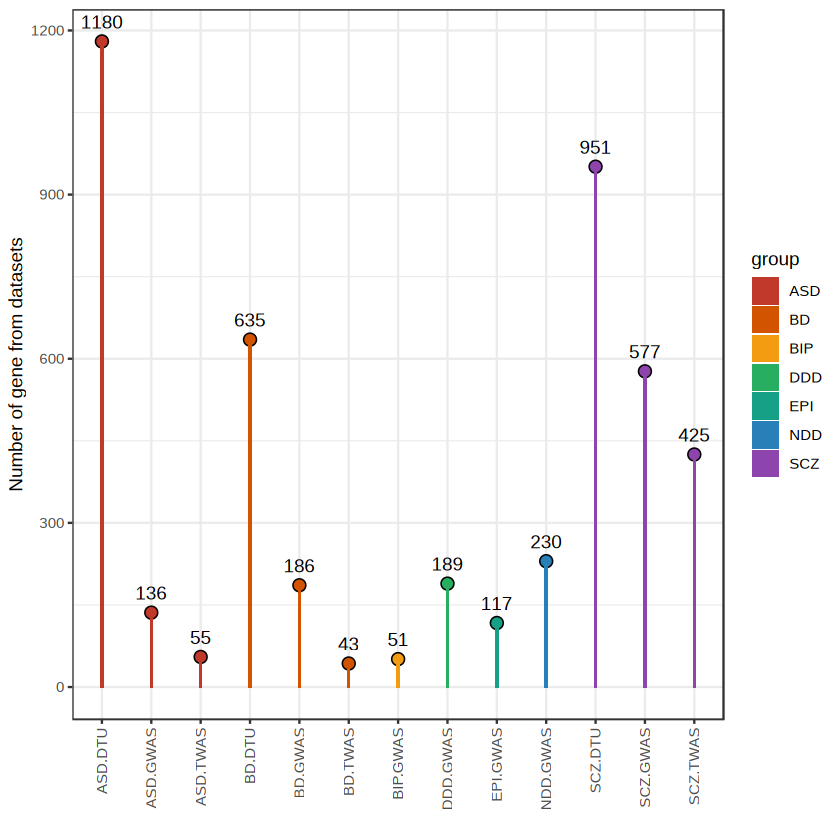

In [24]:
unique(refgdf$source)
hubsource = c('ASD.DTU','BD.DTU','SCZ.DTU','ASD.GWAS','BD.GWAS','SCZ.GWAS','NDD.GWAS','DDD.GWAS','BIP.GWAS','EPI.GWAS','ASD.TWAS','BD.TWAS',"SCZ.TWAS")
refgdf = refgdf[refgdf$gene_id %in% cmgeneid,]
refgdf.hub = refgdf[refgdf$source %in% hubsource,]
refgdf.hubst = refgdf.hub %>% group_by(source,group) %>% summarise(genen = length(unique(gene_id)))
p1.1 = ggplot(refgdf.hubst,aes(x = source,fill = group, y = genen)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_text(aes(label = genen),vjust = -1) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        scale_fill_flatui() +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("") + 
        ylab("Number of gene from datasets")
p1.1
ggexport(p1.1,filename = "result/figure6_snp_analysis/Disease_datasets_genestat_25_12_09.pdf",width = 5,height = 4)

In [60]:
#total DTU stat
dtumkdf.hub = qread("result/figure3/class_DTU_by_subclass_ttest_24_11_05.qs")
head(dtumkdf.hub)
colnames(dtumkdf.hub)[5] = "areatr"
head(dtumkdf.hub)

gene_id transcript_id  pvalue      dr         cluster qvalue
16  ABCC5   XM_005546512.2 0.001969214  0.1571313 GLU     1     
182 ANAPC4  XM_005554612.2 0.014178056  0.1214028 GLU     1     
248 APBB3   XM_005557979.2 0.048700128 -0.1000114 GLU     1     
286 ARFIP2  XM_005578789.2 0.000655739 -0.1232940 GLU     1     
350 ARVCF   XM_005567964.2 0.017739128 -0.1075129 GLU     1     
357 ASH2L   XM_005563066.2 0.000149255 -0.1061145 GLU     1

gene_id transcript_id  pvalue      dr         areatr qvalue
16  ABCC5   XM_005546512.2 0.001969214  0.1571313 GLU    1     
182 ANAPC4  XM_005554612.2 0.014178056  0.1214028 GLU    1     
248 APBB3   XM_005557979.2 0.048700128 -0.1000114 GLU    1     
286 ARFIP2  XM_005578789.2 0.000655739 -0.1232940 GLU    1     
350 ARVCF   XM_005567964.2 0.017739128 -0.1075129 GLU    1     
357 ASH2L   XM_005563066.2 0.000149255 -0.1061145 GLU    1

In [13]:
# summary(dtumkdf.hub$dr)
names(isosigls)

[1] "layer"       "region"      "lobe"        "subclass"    "class"      
[6] "subcortical"

In [14]:
#total DTU stat
isosigst = NULL
for(i in c(1:6)){
    isosigt = isosigls[[i]]
    isosigt = isosigt[isosigt$sig != "N",]
    isosigst = rbind(isosigst,isosigt[,c("gene_id","transcript_id","dr")])
    
}
# isosigst = rbind(isosigst,dtumkdf.hub[,c("gene_id","transcript_id","dr")])
length(unique(isosigst$gene_id))
length(unique(isosigst$transcript_id))

[1] 2933

[1] 5560

In [11]:
mkls = qread(file = "result/figure2/gene_marker_list_25_04_14.qs")
mkls.cl = qread(file = "result/figure3/gene_marker_list_cell_24_12_09.qs")
names(mkls.cl)
mkgenet = NULL
for(i in 1:length(mkls)){
    mklsi = mkls[[i]]
    colnames(mklsi)[6:7] = c("areaid","gene_id")
    mklsi = mklsi[mklsi$avg_log2FC > 1 & mklsi$p_val_adj < 0.05 & mklsi$pct.1 > 0.1, ]
    mkgenet = c(mkgenet,unique(mklsi$gene_id))
}
for(i in 1:length(mkls.cl)){
    mklsi = mkls.cl[[i]]
    colnames(mklsi)[6:7] = c("areaid","gene_id")
    mklsi = mklsi[mklsi$avg_log2FC > 1 & mklsi$p_val_adj < 0.05 & mklsi$pct.1 > 0.1, ]
    mkgenet = c(mkgenet,unique(mklsi$gene_id))
}
mkgenet = unique(mkgenet)
length(mkgenet)

[1] "subclass" "class"

[1] 6063

In [ ]:
length(unique(isosigst[isosigst$gene_id %in% mkgenet,]$gene_id))

In [466]:
#refGWAS = refGWAS[refGWAS$source %in% c(""),]

#isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_dedup_24_09_04.qs")

In [17]:
hubsource = c('ASD.DTU','BD.DTU','SCZ.DTU','ASD.GWAS','BD.GWAS','SCZ.GWAS','NDD.GWAS','DDD.GWAS',
              'BIP.GWAS','EPI.GWAS','ASD.TWAS','BD.TWAS',"SCZ.TWAS")

DiseaseEnrich = function(isosigt,refgdf){
    isosigt = isosigt[substr(isosigt$gene_id,1,9) != "BambuGene",]
    areatrs = unique(isosigt$areatr)
    goana = NULL
    refgdfi = refgdf
    sourceid = unique(refgdfi$source)
    for(i in 1:length(areatrs)){
        isosigii = isosigt[isosigt$areatr == areatrs[i],]
        hubgene = unique(isosigii$gene_id)
        for(j in 1:length(sourceid)){
            refgene = unique(refgdfi[refgdfi$source == sourceid[j],]$gene_id)
            goanai = FishEnrich(hubgene,refgene,cmgenen)
            goanai$group = sourceid[j]
            goanai$areatr = areatrs[i]
            goana = rbind(goana,goanai)
        }
    }
    goana$fdr = p.adjust(goana$p.value)
    goanaf = goana[goana$group %in% hubsource,]
    #goanaf
    #goanaf$group = MySplit(goanaf$group,"\\.",1)
    goanaf$group = factor(goanaf$group,levels = hubsource)
    goanaf$stars <- cut(goanaf$p.value, breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), label=c("***", "**", "*", ""))  # Create column of significance labels
    return(goanaf)
}
#subclass
isosigt = isosigls$subclass
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigt = isosigt[isosigt$gene_id %in% cmgeneid,]
goanaf.subuni = DiseaseEnrich(isosigt,refgdf)
goanaf.subuni$sample = "subclass"
#class
isosigt = isosigls$class
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
goanaf.class = DiseaseEnrich(isosigt,refgdf)
goanaf.class$sample = "class"

#layer
isosigt = isosigls$layer
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
goanaf.layer = DiseaseEnrich(isosigt,refgdf)
goanaf.layer$sample = "layer"

#lobe
isosigt = isosigls$lobe
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigt = isosigt[isosigt$gene_id %in% cmgeneid,]
goanaf.lobe = DiseaseEnrich(isosigt,refgdf)
goanaf.lobe$sample = "lobe"

#subcortical
isosigt = isosigls$subcortical
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigt = isosigt[isosigt$gene_id %in% cmgeneid,]
goanaf.subc = DiseaseEnrich(isosigt,refgdf)
goanaf.subc$sample = "subcortical"

goanaft = rbind(goanaf.subuni,goanaf.class,goanaf.layer,goanaf.lobe,goanaf.subc)


In [27]:
data6s$ref = refgdf
data6s$enrich = goanaft

file saved to result/figure5/Disease_enrich_analysis_25_12_09.pdf



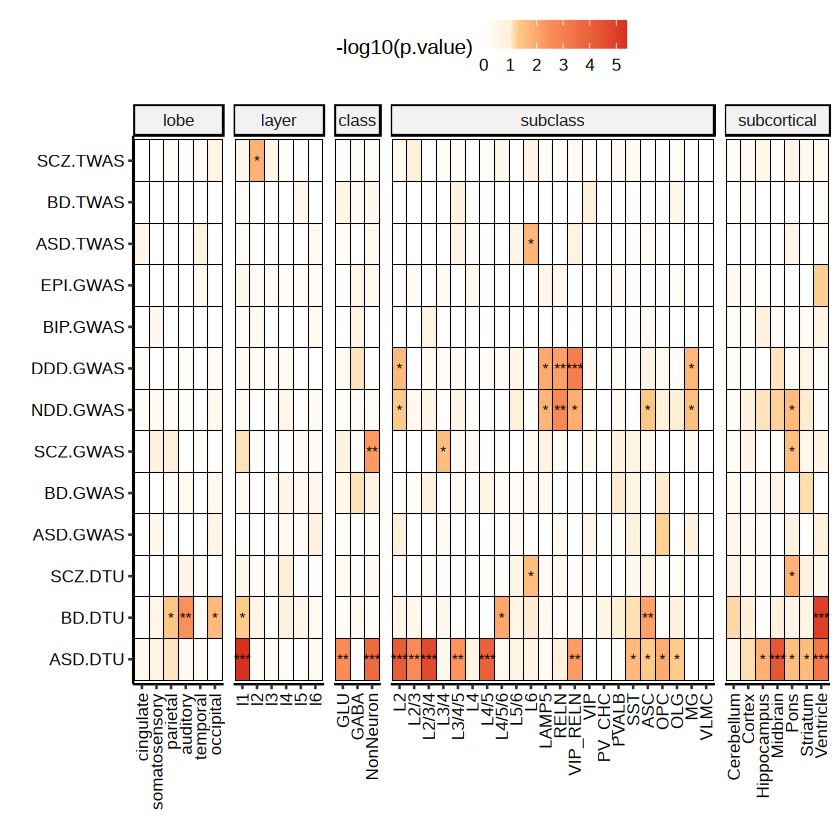

In [28]:
library(RColorBrewer)
goanaft$areatr = factor(goanaft$areatr,levels = c(lobeorder,layerorder,suborder,subcororder,"GLU","GABA","NonNeuron"))
goanaft$sample = factor(goanaft$sample,levels = c("lobe","layer","class","subclass","subcortical"))
goanaft$group = factor(goanaft$group,levels = hubsource)
maxp = max(-log10(goanaft$p.value))
ph = ggplot(goanaft,aes(x = areatr,y = group, fill = -log10(p.value))) + 
    geom_tile(color = "black") + 
    geom_text(aes(label=stars), color="black", size=3) + 
    theme_pubr() + 
    theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1,size = 10),
     axis.text.y = element_text(size = 10)) +
#    
    facet_grid(~sample,scale = "free",space = "free") +
#scale_color_gradient2(low = "blue", mid = "white",high = "red",midpoint = -log10(0.05)) + 
    scale_fill_gradientn(colours = c("white",brewer.pal(4,"OrRd")),
                        values = c(0, 1/maxp,(-log10(0.05))/maxp,2.5/maxp,1)) +
    xlab("") + ylab("")
ph
ggexport(ph,filename = "result/figure5/Disease_enrich_analysis_25_12_09.pdf",width = 8.5,height = 4)

#### Module explain

In [ ]:
isosigt = NULL
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigi$group = "subclass"
isosigt = rbind(isosigt,isosigi[,c("gene_id","areatr","group")])

dtumkdf.hub$group = "class"
isosigt = rbind(isosigt,dtumkdf.hub[,c("gene_id","areatr","group")])

isosigi = isosigls$layer
isosigi = isosigi[isosigi$sig != "N",]
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigi$group = "layer"
isosigt = rbind(isosigt,isosigi[,c("gene_id","areatr","group")])

isosigi = isosigls$lobe
isosigi = isosigi[isosigi$sig != "N",]
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigi$group = "lobe"
isosigt = rbind(isosigt,isosigi[,c("gene_id","areatr","group")])

isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$sig != "N",]
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigi$group = "subcortical"
isosigt = rbind(isosigt,isosigi[,c("gene_id","areatr","group")])

[1] "FXR1"     "PSMA4"    "SETD6"    "GLYCTK"   "DNAJA3"   "JKAMP"   
  [7] "ASPHD1"   "MPPED2"   "TYW5"     "AKT3"     "PARD6A"   "CLCN3"   
 [13] "LMAN2L"   "NDUFAF2"  "FNDC4"    "DYNC1I2"  "NOL4"     "LY6H"    
 [19] "GGNBP2"   "RABEP1"   "AGA"      "STAU2"    "GOPC"     "YIPF1"   
 [25] "ZNF112"   "EIF4B"    "SUGP2"    "SLC12A2"  "FAM107B"  "ELOVL1"  
 [31] "ST6GAL1"  "MAP2"     "PCDHB4"   "ITGAE"    "MRPS33"   "NUDC"    
 [37] "HSP90AB1" "SDR39U1"  "EFS"      "CINP"     "GGA2"     "MPP6"    
 [43] "AIMP2"    "NSMCE4A"  "ACBD5"    "DHRS11"   "LAMTOR3"  "DNAJC4"  
 [49] "ARPC3"    "HMGCR"    "NPRL2"    "RTN4"     "SPR"      "RBBP5"   
 [55] "MED28"    "PCDH17"   "CCDC92"   "HSDL2"    "LRIF1"    "SLC25A51"
 [61] "STAMBP"   "FAM98C"   "OSBPL2"   "RAMP2"    "PPP1R1B"  "DCLK1"   
 [67] "DYDC2"    "DUSP26"   "PSRC1"    "DZIP1"    "SDS"      "NAT10"   
 [73] "B4GALNT1" "KDELR2"   "TUBB2B"   "ARHGAP20" "THUMPD2"  "TDG"     
 [79] "ZSCAN29"  "GTF2A2"   "EMP3"     "CHAC2"    "ST6GAL2"  "CPLX2"   
 [85] "HOMER1"   "ZSCAN1"   "GRM1"     "GDPD1"    "PLCL2"    "ATP2B2"  
 [91] "FAIM"     "RLTPR"    "CCDC117"  "FDPS"     "PAQR6"    "ACOX1"   
 [97] "TNFSF13"  "ARHGEF3"  "GRM2"     "GRPEL2"   "CAMLG"    "REEP3"   
[103] "ZNF641"   "SRR"      "GNG4"     "CHTF8"    "NTSR2"    "METTL15" 
[109] "KCNAB3"   "PAIP1"    "FAM192A"  "SNX32"    "WDR25"    "PSMG4"   
[115] "NPM1"     "GPR3"     "LIMK2"    "HMCES"    "METTL7A"  "GLDN"    
[121] "CD47"     "MVB12B"   "KPNA5"    "PDLIM7"   "ZNF470"   "EME2"    
[127] "ZNF583"   "ECI2"     "PRMT6"    "RUFY2"    "BAG6"     "ACOT6"   
[133] "SRA1"     "TMEM110"  "ZSWIM7"   "ZNF883"   "B3GALT4"  "GATSL3"  
[139] "ZNF512"

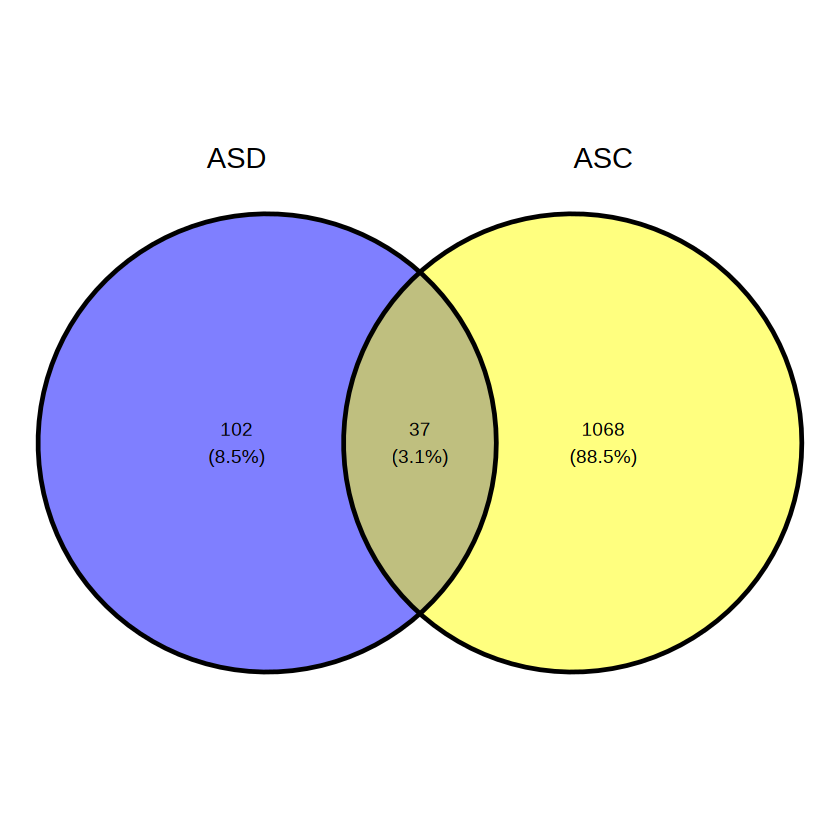

In [276]:
library(ggvenn)
isosigi = isosigls$subclass
hubgene1 = refgdf[refgdf$source == "SCZ.TWAS",]$gene_id
hubgene1 = hubgene1[hubgene1 %in% isosigi$gene_id]
hubgene1
#hubgene1
hubgene = isosigi[isosigi$sig != "N",]$gene_id
ggvenn(list("ASD" = hubgene1,"ASC" = hubgene))

In [26]:
casect = fsraw.cor[fsraw.cor$subclass != "" & fsraw.cor$subcortical %in% "Cortex",] %>% group_by(class,subclass,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(class,subclass,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)

`summarise()` has grouped output by 'class', 'subclass', 'gene_id'. You can
override using the `.groups` argument.


class subclass gene_id 1         2         3 4    groupid geneidn
1 GABA  LAMP5    CD47    0.8750000 0.0625000 0 0.00 11      1      
2 GABA  LAMP5    CDC42   0.8536585 0.1463415 0 0.00 11      8      
3 GABA  LAMP5    CUTA    0.2439024 0.7195122 0 0.00 11      5      
4 GABA  LAMP5    DNAJC4  0.3125000 0.3750000 0 0.25 11      3      
5 GABA  LAMP5    SYT1    0.6105675 0.3855186 0 0.00 11      7      
6 GABA  PVALB    BIN1    0.3846154 0.3846154 0 0.00 15      2

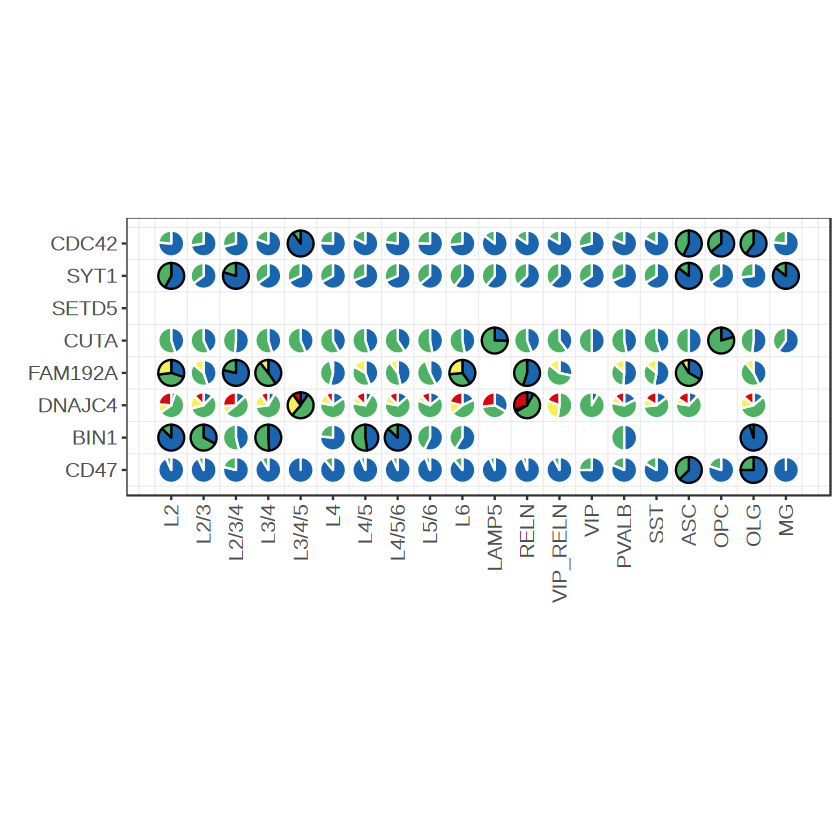

In [27]:
#caseg = genest[1:20,]$gene_id
#caseg = colnames(isosigimx)
caseg = c('CD47','BIN1','DNAJC4','FAM192A','CUTA','SETD5','SYT1','CDC42')
isosigi = rbind(isosigls$subclass,isosigls$layer,isosigls$lobe,isosigls$subcortical)
isosigi = isosigi[isosigi$sig != "N",]
isosigi2 = rbind(isosigls$subclass,isosigls$layer,isosigls$lobe,isosigls$subcortical)
isosigi2 = isosigi2[isosigi2$meanrelative > 0.1,]

casecti = casect[casect$gene_id %in% caseg & casect$transcript_id %in% isosigi2$transcript_id,]

casecti = casecti[casecti$genecount > 10,]
casecti = casecti[!casecti$subclass %in% c("PV_CHC"),]

casecti = casecti %>% group_by(gene_id) %>% mutate(id = as.character(as.numeric(as.factor(transcript_id))))
casecti$gene_tran = paste0(casecti$gene_id,"-",casecti$id)
library(scatterpie)
casectl = dcast(casecti,class+subclass+gene_id~id,value.var = "rate")
casectl[is.na(casectl)] = 0
casectl = casectl[order(casectl$class,casectl$subclass),]
casectl$groupid = as.numeric(factor(casectl$subclass,levels = suborder[suborder %in% casectl$subclass]))
casectl$geneidn = as.numeric(factor(casectl$gene_id,levels = caseg))
head(casectl)

library(patchwork)
ison = casecti %>% group_by(gene_id) %>% summarise(transn = length(unique(transcript_id)))
ison = max(ison$transn)
casectl$sig = 'N'
casectl[paste0(casectl$subclass,casectl$gene_id) %in% paste0(isosigi$areatr,isosigi$gene_id),]$sig = "Y"
#caseg = c("INTU",'DNAJC7',"TUSC3","GRIP1","CACNB4","FAM173A","KLC1","MPG","MTG2","EIF5A","ARID4A","SIVA1","IDH3B")
#caseg = c("MYL6",'NTRK2',"DBNDD2","DDRGK1","ARPP19","ARPP21")
casectl$gene_id = factor(casectl$gene_id,levels = caseg)
plt = ggplot() + 
      geom_scatterpie(data = casectl[casectl$gene_id %in% caseg, ],
                      aes(x = groupid, y = geneidn, group = groupid,color = sig,
                                           r = 0.4),
                      cols=colnames(casectl)[4:(4+ison-1)]) + 
      coord_fixed() +
      scale_x_continuous(breaks = c(1:length(unique(casectl$subclass))),labels = suborder[suborder %in% casectl$subclass]) +
      scale_y_continuous(breaks = c(1:length(caseg)),labels = caseg) +
      scale_color_manual(values = c("white","black")) +
      # geom_smooth(data = tem2, aes(x=x, y=y), se = F, method = 'loess',color = "black") +
      scale_fill_discreterainbow() +
      #annotate("text", x = 8, y = 7, label = caseg[i], hjust = 1.1, vjust = 1.1, size = 5, angle = 90) +
      ylab("") + xlab("") +
      theme_bw() + theme(legend.position="none",axis.text = element_text(size = 12),panel.grid.major = element_blank(),
                         axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
                        strip.background =element_rect(fill="white"))
plt
#ggexport(plt,filename = "result/figure4/case_subclass_isoform_rate_stat_pie_24_12_09.pdf",width = 6,height = 8)

Using gene_id as id variables



gene_id variable value sig group 
1  BIN1    ASD.DTU  0     N   source
2  CD47    ASD.DTU  1     Y   source
3  CDC42   ASD.DTU  0     N   source
4  CUTA    ASD.DTU  0     N   source
5  DNAJC4  ASD.DTU  0     N   source
6  FAM192A ASD.DTU  0     N   source
7  SYT1    ASD.DTU  0     N   source
8  BIN1    ASD.GWAS 0     N   source
9  CD47    ASD.GWAS 0     N   source
10 CDC42   ASD.GWAS 0     N   source
11 CUTA    ASD.GWAS 0     N   source
12 DNAJC4  ASD.GWAS 0     N   source
13 FAM192A ASD.GWAS 0     N   source
14 SYT1    ASD.GWAS 1     Y   source
15 BIN1    ASD.TWAS 0     N   source
16 CD47    ASD.TWAS 0     N   source
17 CDC42   ASD.TWAS 0     N   source
18 CUTA    ASD.TWAS 0     N   source
19 DNAJC4  ASD.TWAS 0     N   source
20 FAM192A ASD.TWAS 1     Y   source
21 SYT1    ASD.TWAS 0     N   source
22 BIN1    BD.DTU   1     Y   source
23 CD47    BD.DTU   0     N   source
24 CDC42   BD.DTU   1     Y   source
25 CUTA    BD.DTU   0     N   source
26 DNAJC4  BD.DTU   0     N   source
27 FAM192A BD.DTU   0     N   source
28 SYT1    BD.DTU   0     N   source
29 BIN1    DDD.GWAS 0     N   source
30 CD47    DDD.GWAS 0     N   source
31 CDC42   DDD.GWAS 0     N   source
32 CUTA    DDD.GWAS 0     N   source
33 DNAJC4  DDD.GWAS 0     N   source
34 FAM192A DDD.GWAS 0     N   source
35 SYT1    DDD.GWAS 1     Y   source
36 BIN1    NDD.GWAS 0     N   source
37 CD47    NDD.GWAS 0     N   source
38 CDC42   NDD.GWAS 1     Y   source
39 CUTA    NDD.GWAS 0     N   source
40 DNAJC4  NDD.GWAS 0     N   source
41 FAM192A NDD.GWAS 0     N   source
42 SYT1    NDD.GWAS 1     Y   source
43 BIN1    SCZ.GWAS 1     Y   source
44 CD47    SCZ.GWAS 1     Y   source
45 CDC42   SCZ.GWAS 0     N   source
46 CUTA    SCZ.GWAS 1     Y   source
47 DNAJC4  SCZ.GWAS 0     N   source
48 FAM192A SCZ.GWAS 0     N   source
49 SYT1    SCZ.GWAS 0     N   source
50 BIN1    SCZ.TWAS 0     N   source
51 CD47    SCZ.TWAS 1     Y   source
52 CDC42   SCZ.TWAS 0     N   source
53 CUTA    SCZ.TWAS 0     N   source
54 DNAJC4  SCZ.TWAS 1     Y   source
55 FAM192A SCZ.TWAS 1     Y   source
56 SYT1    SCZ.TWAS 0     N   source

file saved to result/figure5/NDD_DTU_GABA_case_pieplot_25_12_23.pdf



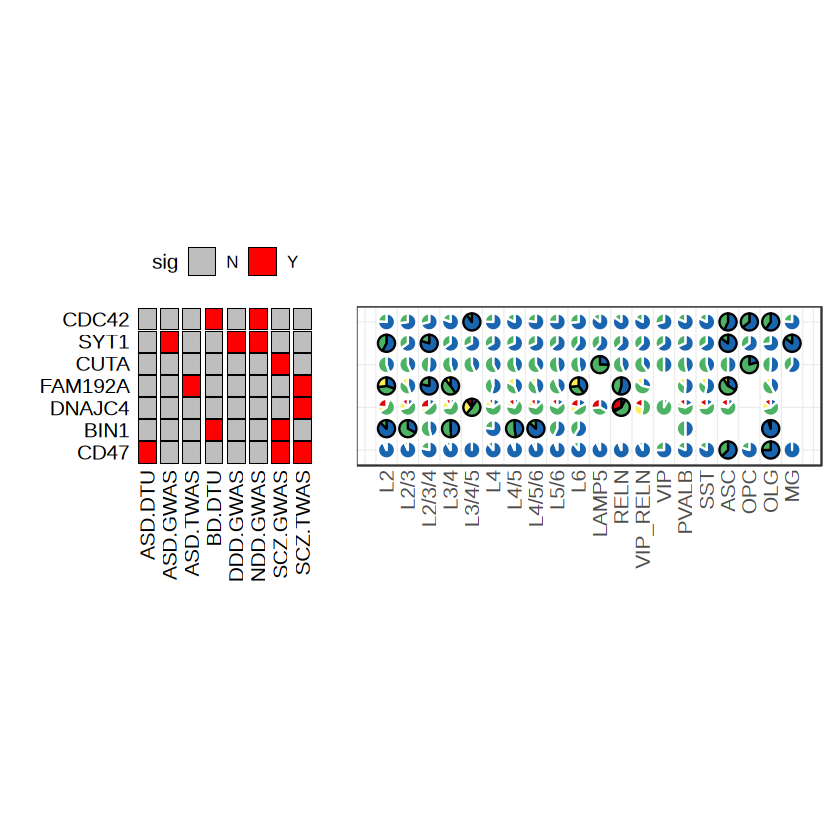

In [39]:
hubsource = c('ASD.DTU','BD.DTU','SCZ.DTU','ASD.GWAS','BD.GWAS','SCZ.GWAS','NDD.GWAS','DDD.GWAS',
              'BIP.GWAS','EPI.GWAS','ASD.TWAS','BD.TWAS',"SCZ.TWAS")
refgdf.hub = refgdf[refgdf$source %in% hubsource,]
refgdf.hubp = refgdf.hub[refgdf.hub$gene_id %in% caseg,]
refgdf.hubp = dcast(refgdf.hubp,gene_id~source, value.var = "source", 
                        fun.aggregate = function(x) length(unique(x)))
refgdf.hubp = melt(refgdf.hubp)
refgdf.hubp$sig = "N"
refgdf.hubp[refgdf.hubp$value > 0,]$sig = "Y"
refgdf.hubp$group = "source"
refgdf.hubp$gene_id = factor(refgdf.hubp$gene_id,levels = caseg)
refgdf.hubp
p1.0 = ggplot(refgdf.hubp,aes(x = variable,y = gene_id,fill = sig)) + 
    geom_tile(width = 0.8,height = 0.95,color = "black") + 
#scale_x_discrete(position = "top") +
    scale_fill_manual(values = c("grey","red")) +
    theme_pubr() + 
    theme(axis.line=element_blank(),axis.ticks = element_blank(),axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
     strip.text.x = element_text(margin = margin(0.5,0,0.5,0, "cm"))) +
coord_fixed() + 
    xlab("") + ylab("")
plt2 = p1.0 + plt + theme(axis.line=element_blank(),axis.ticks = element_blank(),
     axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),axis.text.y = element_blank()) + 
    xlab("") + ylab("")
plt2
ggexport(plt2,filename = "result/figure5/NDD_DTU_GABA_case_pieplot_25_12_23.pdf",width = 8,height = 6)

#### Cross species cases

In [ ]:
cd /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ref/cross_species/
liftoff -g gencode.v19.annotation.gtf GCF_000364345.1_Macaca_fascicularis_5.0_genomic.fa GRCh37.p13.genome.fa  -o gencode.v19.annotation.liftover.gtf -p 10
gffcompare -R  bambu_extended_annotations_novelname_fil_04_30.gtf -r gencode.v19.annotation.liftover.gtf -o bambu_macaca_vs_hg19lifted_25_03_16.gtf


In [ ]:
###compare human and mac5 isoform make modified mcaque gtf

human_gtf <- "../../software/refdata/GRCh38_gencode/genes/genes.gtf"
mouse_gtf <- "../../software/refdata/refdata-gex-mm10-2020-A/genes/genes.gtf"
human_txdb <- makeTxDbFromGFF(file = human_gtf,format = "gtf")
mouse_txdb <- makeTxDbFromGFF(file = mouse_gtf,format = "gtf")

GRanges object with 6 ranges and 8 metadata columns:
         seqnames    ranges strand |   source       type     score     phase
            <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1] NC_012670.1  620-2452      + |    Bambu transcript        NA      <NA>
  [2] NC_012670.1  620-1566      + |    Bambu exon              NA      <NA>
  [3] NC_012670.1 1633-2452      + |    Bambu exon              NA      <NA>
  [4] NC_012670.1 1637-2483      - |    Bambu transcript        NA      <NA>
  [5] NC_012670.1 1637-2300      - |    Bambu exon              NA      <NA>
  [6] NC_012670.1 2354-2483      - |    Bambu exon              NA      <NA>
              gene_id          transcript_id        transcript_name exon_number
          <character>            <character>            <character> <character>
  [1] BambuGene146379 BambuGene146379-WeiL.. BambuGene146379-WeiL..        <NA>
  [2] BambuGene146379 BambuGene146379-WeiL.. BambuGene146379-WeiL..           1
  [3] Bambu

V1   V2         V3          V4          V5   V6
1 chr1 CM001919.1 NC_022272.1 227,556,264 41.5 28
2 chr2 CM001920.1 NC_022273.1 192,460,366 39.5 20
3 chr3 CM001921.1 NC_022274.1 192,294,377 40.5 41
4 chr4 CM001922.1 NC_022275.1 170,955,103 39.5 69
5 chr5 CM001923.1 NC_022276.1 189,454,096 38.0 22
6 chr6 CM001924.1 NC_022277.1 181,584,905 39.5 15

[1] 1152247

[1] 1137349

ERROR: Error in getSeqlevelsReplacementMode(value, seqlevels(x)): the supplied 'seqlevels' must be a character vector with no NAs and no
  duplicates


In [27]:
library(readxl)
path = "ref/disease_gene/science.aat8127/aat8127_table_s1.xlsx"
disref = multiplesheets(path)
names(disref)

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
Warning message:
"Expecting numeric in N22318 / R22318C14: got 'NA'"
Warning message:
"Expecting numeric in O22318 / R22318C15: got 'NA'"
Warning message:
"Expecting numeric in P22318 / R22318C16: got 'NA'"
Warning message:
"Expecting numeric in Q22318 / R22318C17: got 'NA'"
Warning message:
"Expecting numeric in R22318 / R22318C18: got 'NA'"
Warning message:
"Expecting numeric in S22318 / R22318C19: got 'NA'"
Warning message:
"Expecting numeric in T22318 / R22318C20: got 'NA'"
Warning message:
"Expecting numeric in U22318 / R22318C21: got 'NA'"
Warning message:
"Expecting numeric in V22318 / R22318C22: got 'NA'"
Warning message:
"Expecting numeric in W22318 / R22318C23: got 'NA'"
Warning message:
"Expecting numeric in X22318 / R22318C24: got 'NA'"
Warning message:
"Expecting nu

[1] "README"               "DGE"                  "DTE"                 
[4] "DTU"                  "isoformOnlyDE"        "CellTypeEnrichment"  
[7] "RiskGeneEnrichment"   "sLDSR"                "CrossDisorderOverlap"

In [ ]:
gtf.fil = rtracklayer::import("ref/cross_species/bambu_extended_annotations_novelname_fil_04_30.gtf")
hgvmac.tmap = read.table("ref/cross_species/bambu_macaca_vs_hg19lifted_25_03_16.gtf.bambu_extended_annotations_novelname_fil_04_30.gtf.tmap",
                        header = T)
hgvmac.tmapf = hgvmac.tmap[hgvmac.tmap$class_code == "=",]
hgvmac.tmapf$ref_id = substr(hgvmac.tmapf$ref_id,1,nchar(hgvmac.tmapf$ref_id)-2)
trnumt = length(unique(gtf.fil$transcript_id))
trnumhit = length(unique(hgvmac.tmapf$qry_id))
trnumhit
trnumhit/trnumt

In [25]:
data6s$cross_species = hgvmac.tmapf

In [28]:
d2 = disref$DTU
d2g.ASD = d2[abs(d2$DTU.ASD.Value)> 1 & d2$DTU.ASD.p.value< 0.01,]$ensembl_transcript_id
d2g.SCZ = d2[abs(d2$DTU.SCZ.Value)> 1 & d2$DTU.SCZ.p.value < 0.01,]$ensembl_transcript_id
d2g.BD = d2[abs(d2$DTU.BD.Value)> 1 & d2$DTU.BD.p.value < 0.01,]$ensembl_transcript_id
length(d2g.ASD)
d2g.ASD = d2g.ASD[d2g.ASD %in% hgvmac.tmapf$ref_id]
length(d2g.ASD)
d2g.SCZ = d2g.SCZ[d2g.SCZ %in% hgvmac.tmapf$ref_id]
d2g.BD = d2g.BD[d2g.BD %in% hgvmac.tmapf$ref_id]
d2gls = list("ASD" = d2g.ASD,"SCZ" = d2g.SCZ, "BD" = d2g.BD)

Mydtuvsref = function(isosigi,d2gls){
    isosigi = merge(isosigi,hgvmac.tmapf[,c("ref_id","qry_id")],by.x = "transcript_id",by.y = "qry_id")
    isosigi.hub = isosigi[isosigi$sig != "N",]
    isosigi = isosigi[isosigi$transcript_id %in% isosigi.hub$transcript_id,]
    isosigcmp = NULL
    for(i in 1:length(d2gls)){
        isosigj = isosigi[isosigi$ref_id %in% d2gls[[i]],]
        d2.hub = d2[d2$ensembl_transcript_id %in% d2gls[[i]],
            c("external_gene_id","ensembl_transcript_id","DTU.ASD.Value",
              "DTU.SCZ.Value","DTU.BD.Value","DTU.ASD.p.value")]
        isosigcmpi = merge(d2.hub,isosigj,by.x = "ensembl_transcript_id",by.y = "ref_id")
        isosigcmpi$group = names(d2gls)[i]
        isosigcmp = rbind(isosigcmp,isosigcmpi)
    }
    return(isosigcmp)
}
isosigi = isosigls$subclass
isosigcmp.sb = Mydtuvsref(isosigi,d2gls)
isosigcmp.sb$level = "subclass"
isosigi = isosigls$subcortical
isosigcmp.sbc = Mydtuvsref(isosigi,d2gls)
isosigcmp.sbc$level = "subcortical"
isosigi = isosigls$layer
isosigcmp.ly = Mydtuvsref(isosigi,d2gls)
isosigcmp.ly$level = "layer"
isosigi = isosigls$region
isosigcmp.rg = Mydtuvsref(isosigi,d2gls)
isosigcmp.rg$level = "region"
isosigi = isosigls$lobe
isosigcmp.lb = Mydtuvsref(isosigi,d2gls)
isosigcmp.lb$level = "lobe"

length(unique(isosigcmp.rg$gene_id))
#isosigcmpt = rbind(isosigcmp.sb,isosigcmp.sbc)
isosigcmpt = rbind(isosigcmp.sb,isosigcmp.sbc,isosigcmp.ly,isosigcmp.rg,isosigcmp.lb)
length(unique(isosigcmpt$gene_id))
isosigcmpt %>% group_by(group) %>% summarise(genenum = length(unique(gene_id)))
isosigcmpt %>% group_by(level) %>% summarise(genenum = length(unique(gene_id)))
isosigcmpt.st2 = isosigcmpt %>% group_by(gene_id) %>% summarise(groupn = length(unique(group)))
nrow(isosigcmpt.st2[isosigcmpt.st2$groupn > 1,])
isosigcmpt.st2[isosigcmpt.st2$groupn > 2,]
##length(unique(isosigcmp$gene_id))
# isosigcmp.st = isosigcmp %>% group_by(areatr) %>% summarise(cor = cor(DTU.ASD.Value,dr),trannum = length(unique(transcript_id)))
# isosigcmp.st
unique(isosigcmpt$gene_id)

[1] 1991

[1] 543

[1] 142

[1] 265

group genenum
1 ASD    90    
2 BD     83    
3 SCZ   117

level       genenum
1 layer        47    
2 lobe         26    
3 region      142    
4 subclass    108    
5 subcortical 137

[1] 23

gene_id groupn
1 MDK     3     
2 PLPP2   3

[1] "LTA4H"        "RPN2"         "AP4B1"        "TATDN1"       "MED21"       
  [6] "RPL22L1"      "MFSD3"        "DDX54"        "SNX32"        "MRFAP1L1"    
 [11] "CRADD"        "TCAIM"        "SMARCE1"      "COPS8"        "SAP30BP"     
 [16] "WDR55"        "RPE"          "ANGEL2"       "PPARD"        "PJA1"        
 [21] "GPATCH2"      "PLEKHA1"      "TMEM56"       "SLC25A25"     "NTRK2"       
 [26] "XRN2"         "ACTR2"        "APOO"         "CDK14"        "RWDD1"       
 [31] "TDG"          "ALG13"        "TMEM106B"     "SLC35A2"      "YWHAH"       
 [36] "VGLL4"        "IL1RAP"       "FDPS"         "THRA"         "CCDC136"     
 [41] "RPS24"        "SMARCC2"      "SEC11A"       "ST6GAL1"      "HSCB"        
 [46] "APMAP"        "ACVR2A"       "RAMP3"        "WDR83"        "RSRP1"       
 [51] "SNRPC"        "ZNF337"       "APC"          "HACE1"        "SLC39A3"     
 [56] "RNF126"       "ARHGEF3"      "RGL1"         "NINJ2"        "ZNF471"      
 [61] "HMGCS1"       "SIVA1"        "TPM3"         "EIF5A"        "CLDND1"      
 [66] "NRXN1"        "MIA3"         "DDRGK1"       "MIER1"        "GDA"         
 [71] "DPCD"         "RCAN2"        "TEX30"        "SEPT8"        "AURKAIP1"    
 [76] "VLDLR"        "RNMT"         "EEF1B2"       "ZDHHC8"       "PPP1R7"      
 [81] "JMJD6"        "TTC19"        "RNF130"       "DERL2"        "GMIP"        
 [86] "ACOT8"        "ARL2BP"       "RPS12"        "CPSF3"        "MECR"        
 [91] "MAPKAP1"      "SLC25A26"     "CLTA"         "MTMR2"        "NMRK1"       
 [96] "PNISR"        "LOC101925321" "PLXDC2"       "C11H12orf73"  "CCP110"      
[101] "COPS2"        "SUPT5H"       "DAPK1"        "CAB39L"       "MFSD1"       
[106] "SPG20"        "MFN2"         "BEND5"        "RELT"         "RHBDL1"      
[111] "VASP"         "AIF1L"        "BFAR"         "RGS20"        "BCCIP"       
[116] "FABP5"        "CLTB"         "ZADH2"        "F8"           "INO80C"      
[121] "DPYSL3"       "LOC102134966" "C15H9orf9"    "MPZL1"        "SMYD2"       
[126] "DCLK1"        "PSIP1"        "SNCA"         "BAIAP2"       "NT5C3A"      
[131] "BECN1"        "CHPF2"        "TMEM161A"     "EFS"          "NUTF2"       
[136] "DECR1"        "GCHFR"        "TMEM206"      "CALB1"        "B3GAT3"      
[141] "EXOSC7"       "FBXO3"        "SRI"          "SAT2"         "PTS"         
[146] "LOC102114773" "LOC102128802" "STOX2"        "PMP22"        "SNAPC5"      
[151] "EDEM3"        "ACOT9"        "SUGP2"        "SNX10"        "TBCCD1"      
[156] "PSPC1"        "SNRPN"        "TM2D3"        "SPRED2"       "SESN1"       
[161] "PHACTR3"      "RALGPS2"      "CXCL12"       "MOG"          "LOC102122672"
[166] "PCNA"         "U2AF1"        "LOC102140649" "LOC102115867" "ATP1B3"      
[171] "RNF146"       "GNPNAT1"      "RASL11A"      "GCAT"         "MACROD1"     
[176] "CDH10"        "AIFM1"        "RNPEP"        "LOC102144128" "STX8"        
[181] "HNRNPD"       "PSMG1"        "SUPT7L"       "KLHDC9"       "MEAF6"       
[186] "APIP"         "FAM172A"      "ARPP21"       "C19H19orf24"  "SMIM19"      
[191] "LOC107131103" "PSMG4"        "C1H1orf52"    "CLCN3"        "CPNE3"       
[196] "SMIM5"        "IFT20"        "ZNF136"       "GYG1"         "NDUFAF5"     
[201] "KATNB1"       "MDK"          "SLC25A12"     "GSTO2"        "FADS3"       
[206] "ZNF587"       "AGPAT4"       "PLD4"         "LOC102122910" "PARP11"      
[211] "ZBED3"        "NTAN1"        "TDRP"         "MRPS35"       "PLLP"        
[216] "PLPP2"        "GALM"         "CERS6"        "DPM2"         "SRSF11"      
[221] "ANXA7"        "NET1"         "FBXW9"        "KCNC2"        "ABTB1"       
[226] "DGKB"         "SMIM4"        "MTX3"         "TMEM205"      "CTDSPL2"     
[231] "TYROBP"       "MARCH9"       "EMP3"         "ARL6"         "TMEM110"     
[236] "BOLA1"        "OLFM3"        "BCAS4"        "PLA2G5"       "MOSPD2"      
[241] "GEMIN8"       "FGF9"         "MICU2"        "GNG4"         "PIK3R3"      
[246] "ARRB1"        "TDRD7"     

`summarise()` has grouped output by 'level'. You can override using the
`.groups` argument.
file saved to result/figure5/Disease_conserve_dtu_stat_bar_25_12_18.pdf



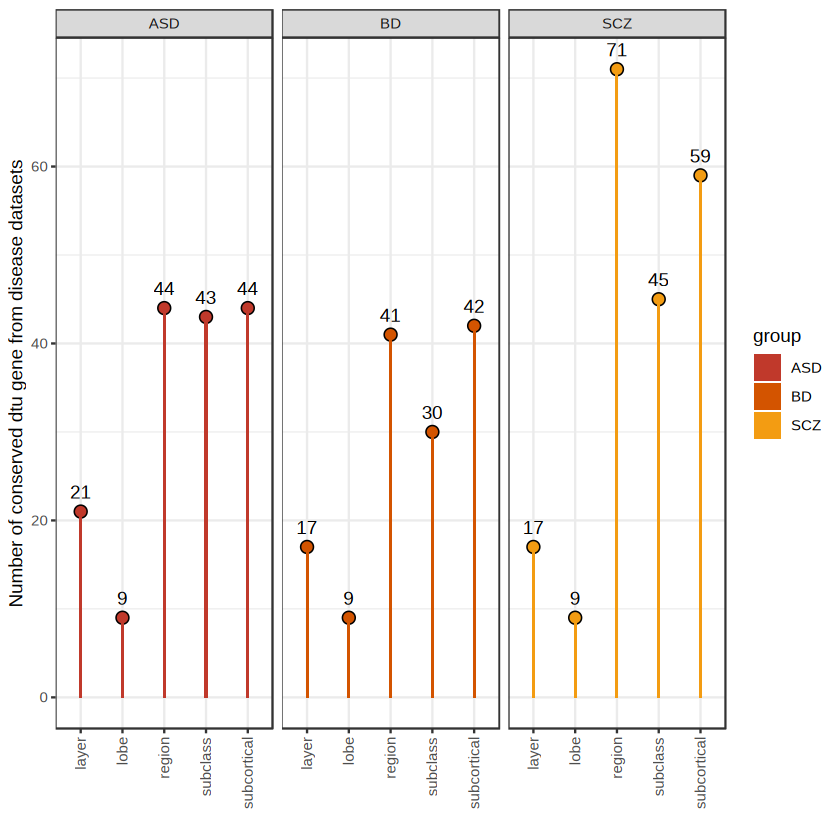

file saved to result/figure5/Disease_conserve_dtu_stat_tile_25_12_18.pdf

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


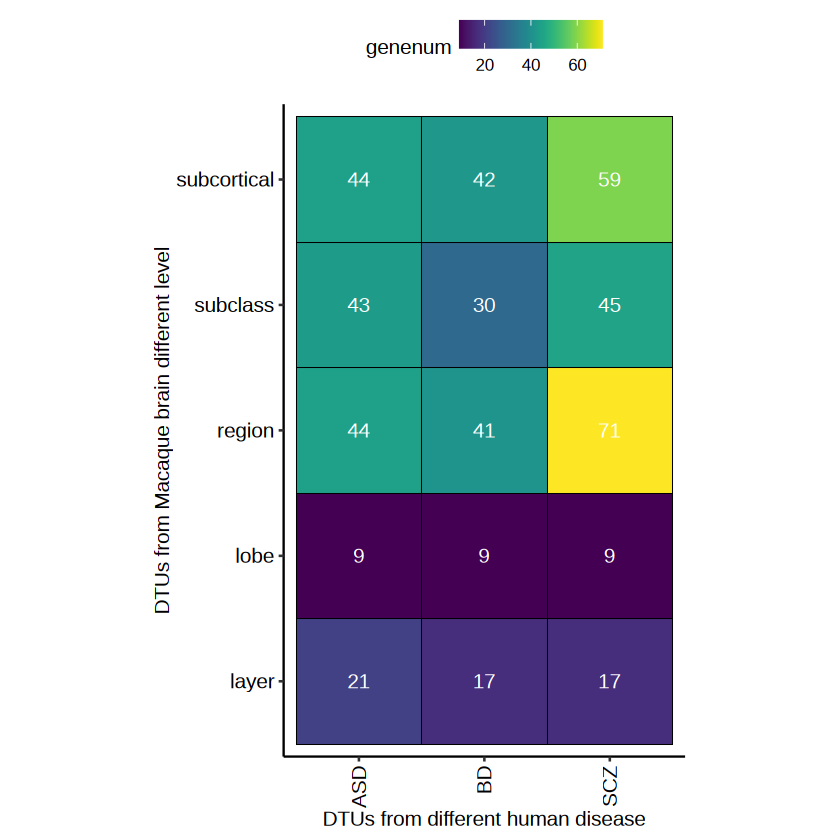

file saved to result/figure5/Disease_conserve_dtu_stat_venn_25_12_18.pdf



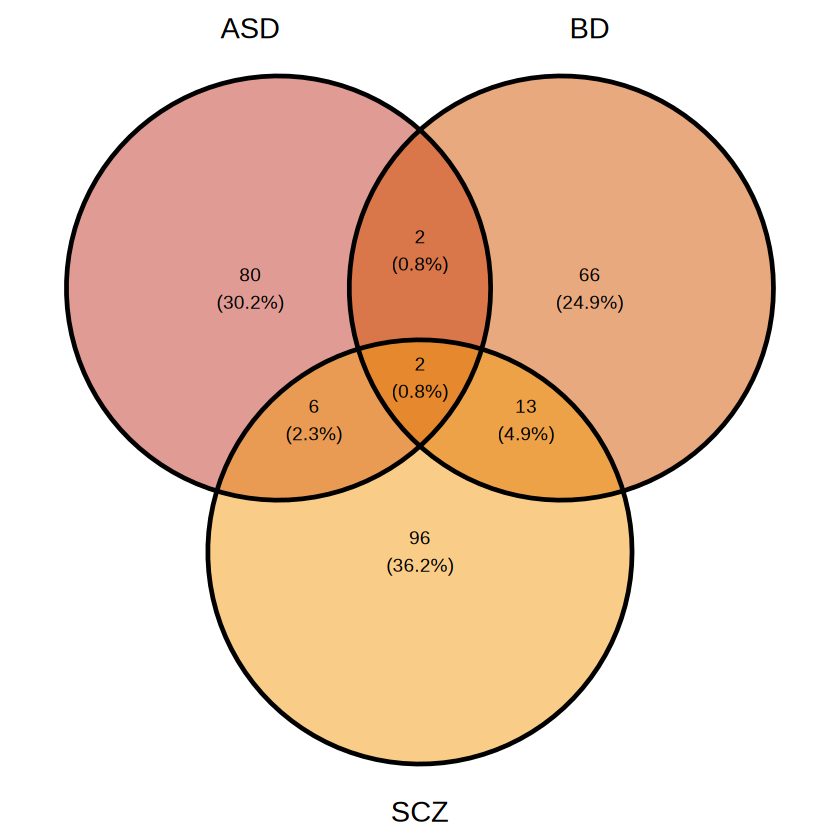

In [287]:
#disease associated FS DTU gene stat
isosigcmpt.st = isosigcmpt %>% group_by(level,group) %>% summarise(genenum = length(unique(gene_id)))
#ggplot(isosigcmpt.st,aes(x = level,fill = group,y = genenum)) + geom_bar(stat = "identity",position = "dodge")
p1.2 = ggplot(isosigcmpt.st,aes(x = level,fill = group,y = genenum)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_text(aes(label = genenum),vjust = -1) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        facet_grid(~group) +
        scale_fill_flatui() +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("") + 
        ylab("Number of conserved dtu gene from disease datasets")
p1.2
ggexport(p1.2,filename = "result/figure5/Disease_conserve_dtu_stat_bar_25_12_18.pdf",width = 5,height = 4)

p1.2.1 = ggplot(isosigcmpt.st,aes(y = level,x = group,fill = genenum)) + 
        geom_tile(color = "black") +
        geom_text(aes(label = genenum),color = "white") +
        scale_fill_viridis(option = "D") +
        coord_fixed() +
        theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + ylab("DTUs from Macaque brain different level") + 
        xlab("DTUs from different human disease")
p1.2.1
ggexport(p1.2.1,filename = "result/figure5/Disease_conserve_dtu_stat_tile_25_12_18.pdf",width = 5,height = 4)


fsdtuds = list("ASD" = unique(isosigcmpt[isosigcmpt$group == "ASD",]$gene_id),
              "BD" = unique(isosigcmpt[isosigcmpt$group == "BD",]$gene_id),
              "SCZ" = unique(isosigcmpt[isosigcmpt$group == "SCZ",]$gene_id))
p1.3 = ggvenn(fsdtuds) + scale_fill_flatui()
p1.3
ggexport(p1.3,filename = "result/figure5/Disease_conserve_dtu_stat_venn_25_12_18.pdf",width = 5,height = 4)

In [293]:
d1 = disref$DGE
d1g.ASD = d1[abs(d1$ASD.log2FC)> 1 & d1$ASD.p.value< 0.01,]
d1g.SCZ = d1[abs(d1$SCZ.log2FC)> 1 & d1$SCZ.p.value < 0.01,]
d1g.BD = d1[abs(d1$BD.log2FC)> 1 & d1$BD.p.value < 0.01,]
d1gls = list("ASD" = d1g.ASD,"SCZ" = d1g.SCZ, "BD" = d1g.BD)

d2 = disref$DTU
# d2g.ASD = d2[abs(d2$DTU.ASD.Value) > 1 & d2$DTU.ASD.p.value< 0.01,]
# d2g.ASD = d2[d2$external_gene_id %in% d2g.ASD$external_gene_id,]
# d2g.SCZ = d2[abs(d2$DTU.SCZ.Value) > 1 & d2$DTU.SCZ.p.value < 0.01,]
# d2g.SCZ = d2[d2$external_gene_id %in% d2g.SCZ$external_gene_id,]
# d2g.BD = d2[abs(d2$DTU.BD.Value) > 1 & d2$DTU.BD.p.value < 0.01,]
#d2g.BD = d2[d2$external_gene_id %in% d2g.BD$external_gene_id,]
d2g.ASD = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.ASD$value = d2g.ASD$DTU.ASD.Value
d2g.SCZ = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.SCZ$value = d2g.SCZ$DTU.SCZ.Value
d2g.BD = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.BD$value = d2g.BD$DTU.BD.Value
d2gls = list("ASD" = d2g.ASD,"SCZ" = d2g.SCZ, "BD" = d2g.BD)

CalDsscore = function(d2gi,fsraw.block.hub,isost){
    d2gi = d2gi[,c("external_gene_id","ensembl_transcript_id","value")]
    d2gi = merge(d2gi,hgvmac.tmapf,by.x = "ensembl_transcript_id",by.y = "ref_id")
    d2gi = unique(d2gi[,c("qry_gene_id","qry_id","value")])
    # spds.score = fsraw.block.hub[fsraw.block.hub$gene_id %in% d2gi$qry_gene_id,]
    # #spds.score = merge(fsraw.block.hub,d2gi,by.x = "transcript_id",by.y = "qry_id")
    # spds.score = spds.score %>% group_by(subcortical,layer,region,xid,yid,blockid,gene_id) %>% 
    #                         mutate(relative = readnum/sum(readnum))
    # spds.score = merge(spds.score,isost[,c("gene_id","transcript_id","meanrelative")],by = c("gene_id","transcript_id"))
    # spds.score$dr = spds.score$relative - spds.score$meanrelative 
    spds.score = merge(fsraw.block.hub,d2gi,by.x = "transcript_id",by.y = "qry_id")
    spds.score = spds.score[!is.na(spds.score$value),]
    spds.score = spds.score %>% group_by(subcortical,layer,region,xid,yid,blockid) %>% 
            summarise(readnumt = sum(readnum),genenum = length(unique(gene_id)),score = sum(value*readnum)/readnumt)
            #summarise(readnumt = sum(readnum),score = cor(dr,value),genenum = length(unique(gene_id)))
    # spds.score$type = "N"
    # spds.score[spds.score$value > 0,]$type = "Up"
    # spds.score[spds.score$value < 0,]$type = "Down"
    # fsraw.block.hub$score = 0
    # fsraw.block.hub[fsraw.block.hub$transcript_id %in% d2gi$qry_id,]$score = 1
    # #fsraw.block.hub[fsraw.block.hub$transcript_id %in% d2gi[d2gi$value < (-1),]$qry_id,]$score = -1
    # spds.score = spds.score %>% group_by(subcortical,layer,region,xid,yid,blockid) %>% 
    #     summarise(readnumt = sum(readnum),genenum = length(unique(gene_id)),score = sum(value*readnum)/readnumt)
    # spds.score = spds.score %>% group_by(subcortical,layer,region,xid,yid,blockid,type) %>% 
    #     summarise(readnum = sum(readnum),score = readnum/readnumt,readnumt = readnumt[1],genenum = genenum[1])
    return(spds.score)
    
}

CalDsscoreG = function(d2gi,fsraw.block.hub){
    fsraw.block.hub$score = 0
    fsraw.block.hub[fsraw.block.hub$gene_id %in% d2gi$gene_name,]$score = 1
    spds.score = fsraw.block.hub %>% group_by(subcortical,layer,region,xid,yid,blockid) %>% 
        summarise(score = sum(score*readnum)/sum(readnum),readnumt = sum(readnum),
                  genenum = length(unique(gene_id)))
    return(spds.score)
}
spds.scz = CalDsscore(d2gls$SCZ,fsraw.block.hub,isost)
spds.asd = CalDsscore(d2gls$ASD,fsraw.block.hub,isost)
spds.bd = CalDsscore(d2gls$BD,fsraw.block.hub,isost)

# spds.scz.g = CalDsscoreG(d1gls$SCZ,fsraw.block.hub)
# spds.asd.g = CalDsscoreG(d1gls$ASD,fsraw.block.hub)
# spds.bd.g = CalDsscoreG(d1gls$BD,fsraw.block.hub)

`summarise()` has grouped output by 'subcortical', 'layer', 'region', 'xid',
'yid'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'subcortical', 'layer', 'region', 'xid',
'yid'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'subcortical', 'layer', 'region', 'xid',
'yid'. You can override using the `.groups` argument.


In [289]:
#in celltype
fsraw.cell = fsraw.cor[fsraw.cor$subclass != "",] %>% 
    group_by(class,subclass,gene_id,transcript_id) %>% 
    summarise(readnum = length(readid))
d2g.ASD = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.ASD$value = d2g.ASD$DTU.ASD.Value
d2g.SCZ = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.SCZ$value = d2g.SCZ$DTU.SCZ.Value
d2g.BD = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.BD$value = d2g.BD$DTU.BD.Value
d2gls = list("ASD" = d2g.ASD,"SCZ" = d2g.SCZ, "BD" = d2g.BD)

CalDsscoreCell = function(d2gi,fsraw.cell){
    d2gi = d2gi[,c("external_gene_id","ensembl_transcript_id","value")]
    d2gi = merge(d2gi,hgvmac.tmapf,by.x = "ensembl_transcript_id",by.y = "ref_id")
    d2gi = unique(d2gi[,c("qry_gene_id","qry_id","value")])
  
    spds.score = merge(fsraw.cell,d2gi,by.x = "transcript_id",by.y = "qry_id")
    spds.score = spds.score[!is.na(spds.score$value),]
    spds.score = spds.score %>% group_by(class,subclass) %>% 
            summarise(readnumt = sum(readnum),genenum = length(unique(gene_id)),score = sum(value*readnum)/readnumt)
    return(spds.score)
}
spds.scz.c = CalDsscoreCell(d2gls$SCZ,fsraw.cell)
spds.asd.c = CalDsscoreCell(d2gls$ASD,fsraw.cell)
spds.bd.c = CalDsscoreCell(d2gls$BD,fsraw.cell)

`summarise()` has grouped output by 'class', 'subclass', 'gene_id'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'class'. You can override using the
`.groups` argument.


In [ ]:
spds.scz.c$group = "SCZ"
spds.asd.c$group = "ASD"
spds.bd.c$group = "BD"
spdst.c = rbind(spds.scz.c,spds.asd.c,spds.bd.c)

groupid = c("ASD","SCZ","BD")
ptls = list()
for(i in 1:length(groupid)){
    pti = ggplot(spdst.c[spdst.c$readnumt > 1000 & spdst.c$group == groupid[i],],aes(x = class, y = score,fill = group))+
     # geom_jitter(shape=21,size=1,width=0.1) +
      #geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      facet_grid(~group) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform disease similarity score(IDS)") + xlab("")
    ptls[[i]] = pti
}

ptt = ggarrange(plotlist = ptls,nrow = 1)
ptt

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to result/figure5/spatial_isoform_disease_associated_point_SCZ_25_12_18.pdf

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."


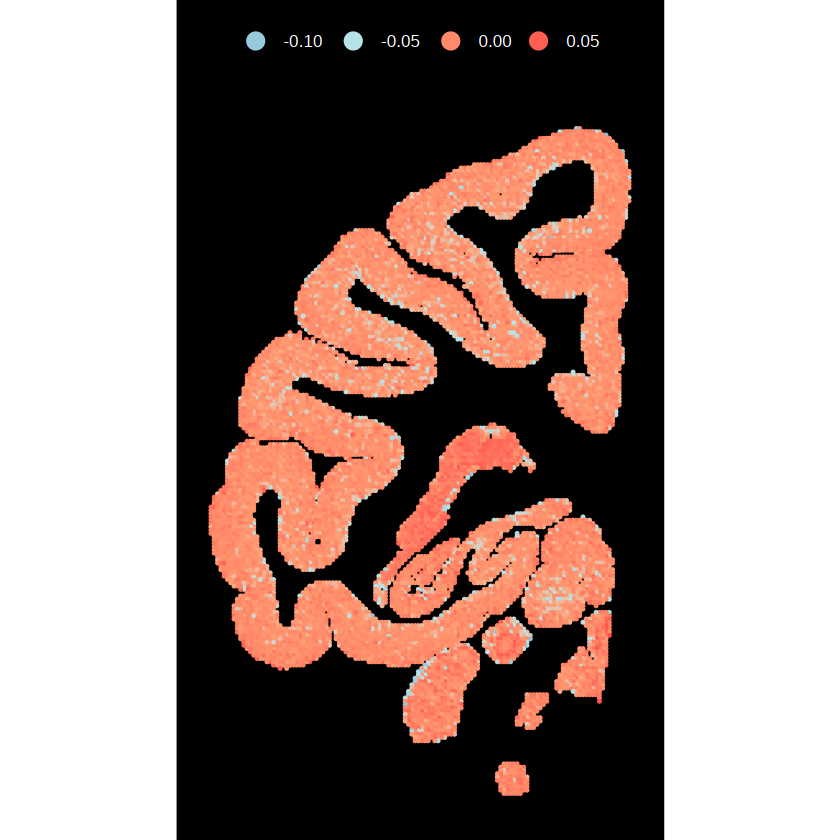

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to result/figure5/spatial_isoform_disease_associated_point_ASD_25_12_18.pdf

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."


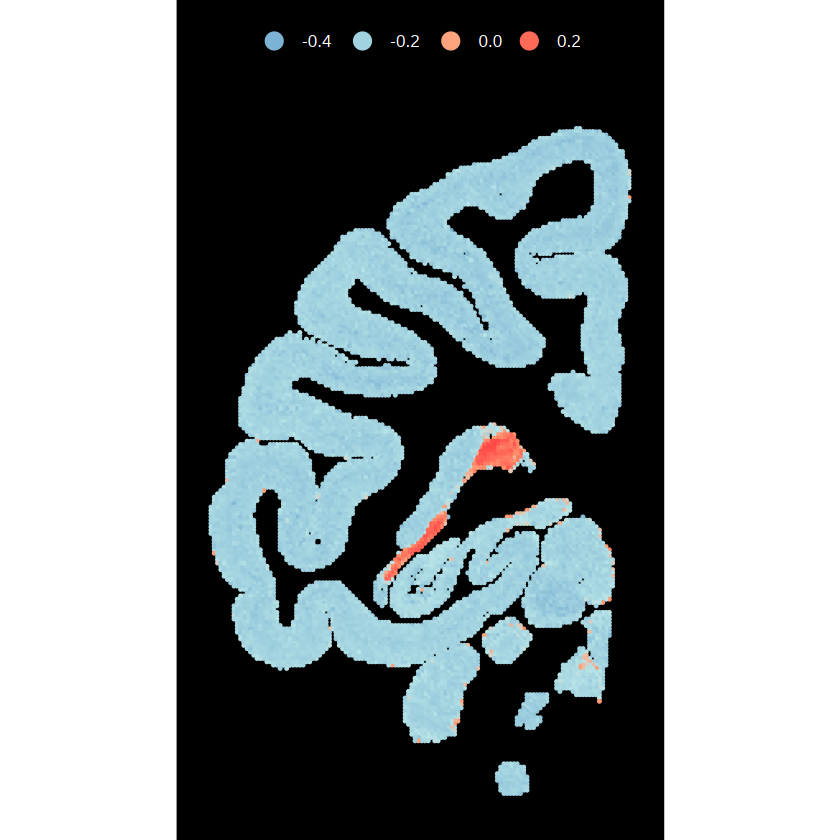

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to result/figure5/spatial_isoform_disease_associated_point_BD_25_12_18.pdf



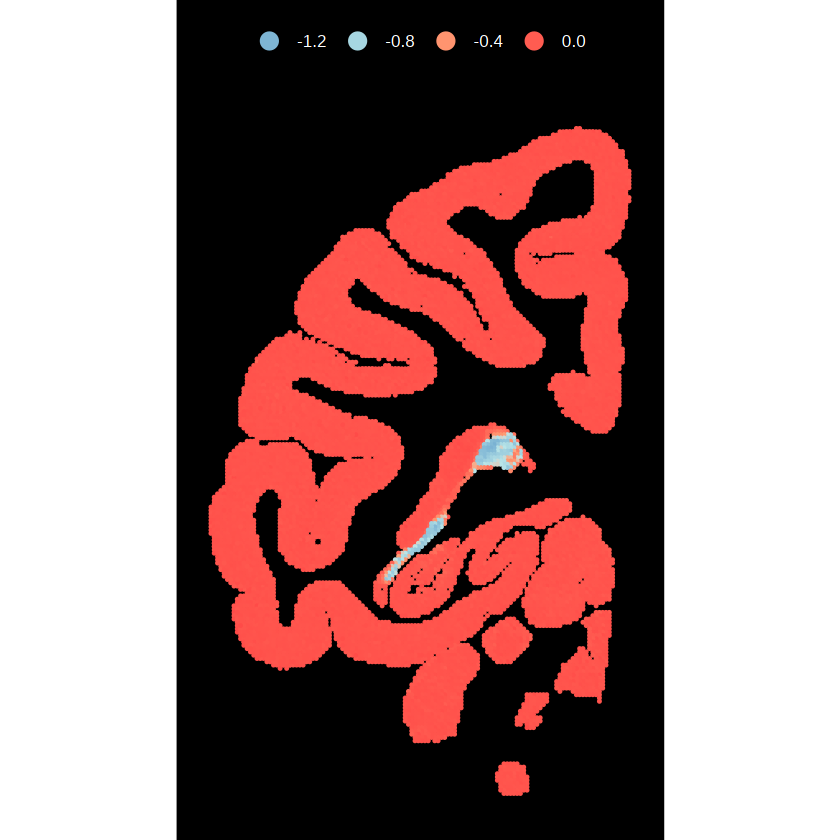

In [294]:
colfunc1 <- colorRampPalette(c("#7AB2D3", "#B9E5E8"))
col1 = colfunc1(5)
colfunc2 <- colorRampPalette(c("#FF9C73", "#FF4545"))
col2 = colfunc2(5)

pmkpti = ggplot(spds.scz[spds.scz$readnumt > 1000,],aes(x = xid, y = yid,color = score)) +
      geom_point(size = 0.001) +
      theme_void() + 
      scale_colour_gradientn(colours = c(col1,col2)) +
        #limits = c(-0.5, 0.25) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 1),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
      coord_fixed()
pmkpti
ggexport(pmkpti,filename = "result/figure5/spatial_isoform_disease_associated_point_SCZ_25_12_18.pdf", width = 4,height = 6)

pmkpti = ggplot(spds.asd[spds.asd$readnumt > 1000,],aes(x = xid, y = yid,color = score)) +
      geom_point(size = 0.001) +
      theme_void() + 
      scale_colour_gradientn(colours = c(col1,col2)) +
        #limits = c(-0.5, 0.25) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 1),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
      coord_fixed()
pmkpti
ggexport(pmkpti,filename = "result/figure5/spatial_isoform_disease_associated_point_ASD_25_12_18.pdf", width = 4,height = 6)

pmkpti = ggplot(spds.bd[spds.bd$readnumt > 1000,],aes(x = xid, y = yid,color = score)) +
      geom_point(size = 0.001) +
      theme_void() + 
      scale_colour_gradientn(colours = c(col1,col2)) +
        #limits = c(-0.5, 0.25) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 1),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
      coord_fixed()
pmkpti
ggexport(pmkpti,filename = "result/figure5/spatial_isoform_disease_associated_point_BD_25_12_18.pdf", width = 4,height = 6)

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
file saved to result/figure5/spatial_isoform_disease_associated_point_total_boxplot_25_12_18.pdf



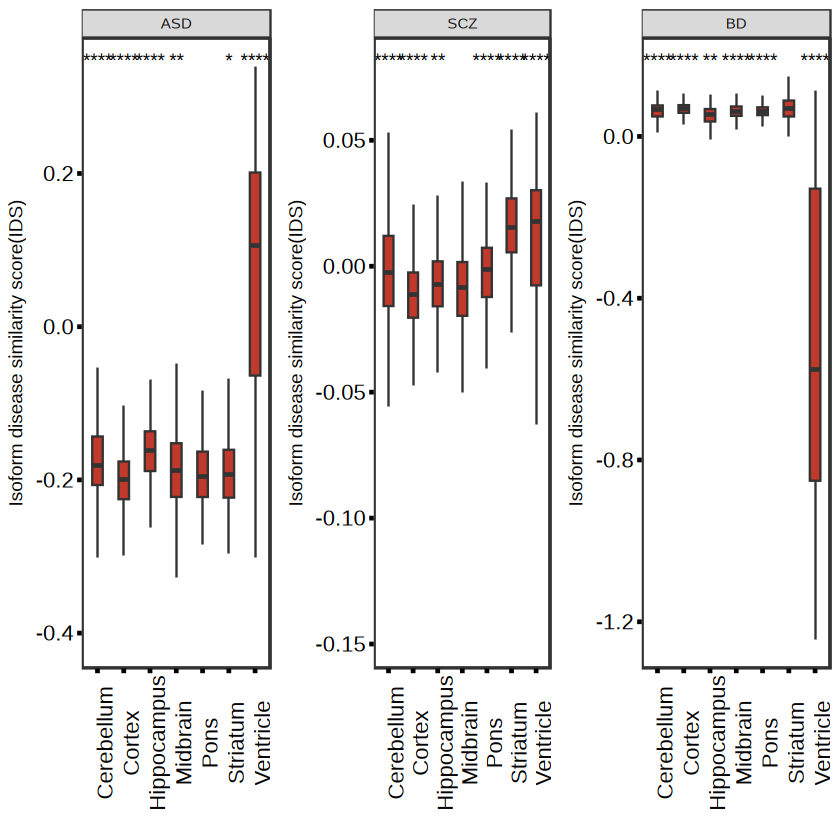

In [295]:
#spds.score.st = spds.score %>% group_by(subcortical) %>% summarise(scorem = mean(score))
spds.scz$group = "SCZ"
spds.asd$group = "ASD"
spds.bd$group = "BD"
spdst = rbind(spds.scz,spds.asd,spds.bd)

groupid = c("ASD","SCZ","BD")
ptls = list()
for(i in 1:length(groupid)){
    pti = ggplot(spdst[spdst$readnumt > 1000 & spdst$group == groupid[i],],aes(x = subcortical, y = score,fill = group))+
     # geom_jitter(shape=21,size=1,width=0.1) +
      #geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      facet_grid(~group) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform disease similarity score(IDS)") + xlab("")
    ptls[[i]] = pti
}

ptt = ggarrange(plotlist = ptls,nrow = 1)
ptt
ggexport(ptt,filename = "result/figure5/spatial_isoform_disease_associated_point_total_boxplot_25_12_18.pdf", width = 8,height = 4)

file saved to result/figure5/spatial_isoform_disease_associated_point_total_layer_boxplot_25_03_20.pdf



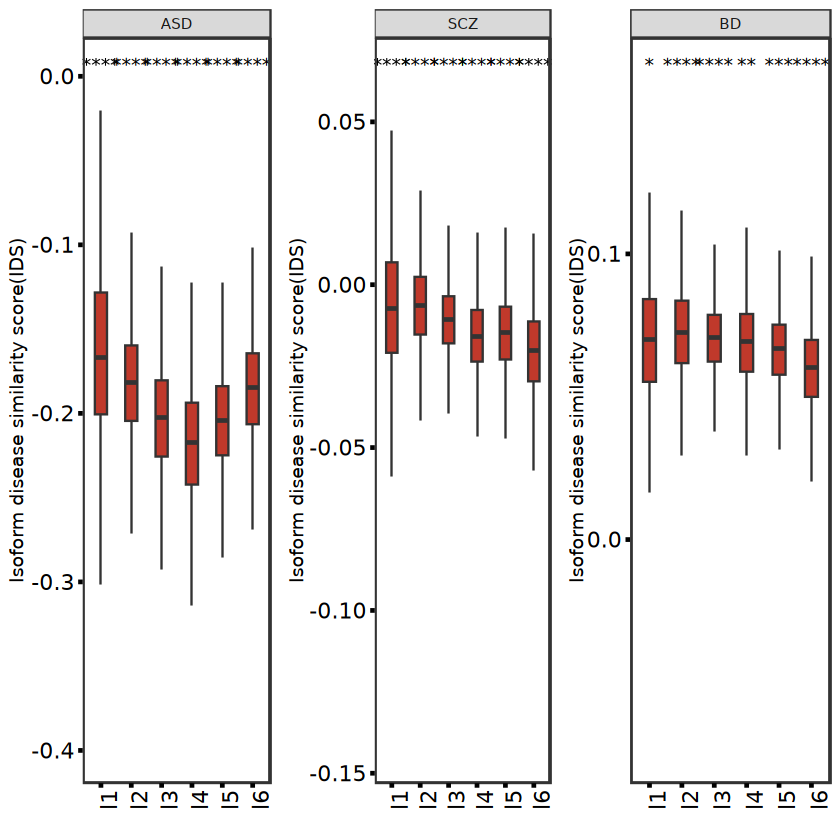

In [1081]:
#spds.score.st = spds.score %>% group_by(subcortical) %>% summarise(scorem = mean(score))
ptls = list()
for(i in 1:length(groupid)){
    pti = ggplot(spdst[spdst$readnumt > 1000 & spdst$group == groupid[i] & spdst$layer %in% paste0("l",1:6),],
                 aes(x = layer, y = score,fill = group))+
     # geom_jitter(shape=21,size=1,width=0.1) +
      #geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      facet_grid(~group) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform disease similarity score(IDS)") + xlab("")
    ptls[[i]] = pti
}

ptt = ggarrange(plotlist = ptls,nrow = 1)
ptt
ggexport(ptt,filename = "result/figure5/spatial_isoform_disease_associated_point_total_layer_boxplot_25_03_20.pdf", width = 8,height = 4)

##### Spatial and single cell case of MYL6 and CDC42

In [ ]:
regionorder = c("29","30","23a","23b","31","23c","1|2","PE","PEa","VIP","LIPv","LIPd","PG","7op","CM","AI","CL","CPB","TPO",
               "PGa","FST","V4t","V4","TEO","TEpd","TEpv","TFO","V3v","V2","v23b")

In [840]:
TotalIsouse = function(transt){
    transt = transt[!is.na(transt$areatr),]
    transt = transt[transt$areatr != "",]
    transt$relative = transt$count/transt$genecount
    transtf = transt[transt$genecount > 10,]
    transtf = transt %>% group_by(transcript_id) %>% 
      mutate(meanrelative = mean(relative),
             otherrelative = (sum(relative) - relative)/(n() - 1))
    #transtf = transtf[which(transtf$meanrelative > 0.05),]

    # transtf = transtf %>% group_by(transcript_id) %>% 
    #    filter(length(unique(areatr)) > 1)
    # transtf = transtf %>% group_by(gene_id) %>% 
    #   filter(length(unique(transcript_id))>1)

    transtf$dr = transtf$relative - transtf$otherrelative
    return(transtf)
}

isosigi1 = TotalIsouse(transtls$subclass)
isosigi1$group = "subclass"
isosigi2 = TotalIsouse(transtls$class)
isosigi2$group = "class"
isosigi3 = TotalIsouse(transtls$layer)
isosigi3$group = "layer"
isosigi4 = TotalIsouse(transtls$subcortical)
isosigi4$group = "subcortical"
isosigi5 = TotalIsouse(transtls$region)
isosigi5$group = "region"
isosigi5$areatr = paste0("region-",isosigi5$areatr)
isosigt = rbind(isosigi1,isosigi2,isosigi3,isosigi4,isosigi5)
isosigt$areatr = factor(isosigt$areatr,c(suborder,c("GLU","GABA","NonNeuron"),layerorder,
                                         subcororder,paste0("region-",regionorder)))
isosigt = merge(isosigt,hgvmac.tmapf[,c("ref_id","qry_id")],by.x = "transcript_id",by.y = "qry_id")

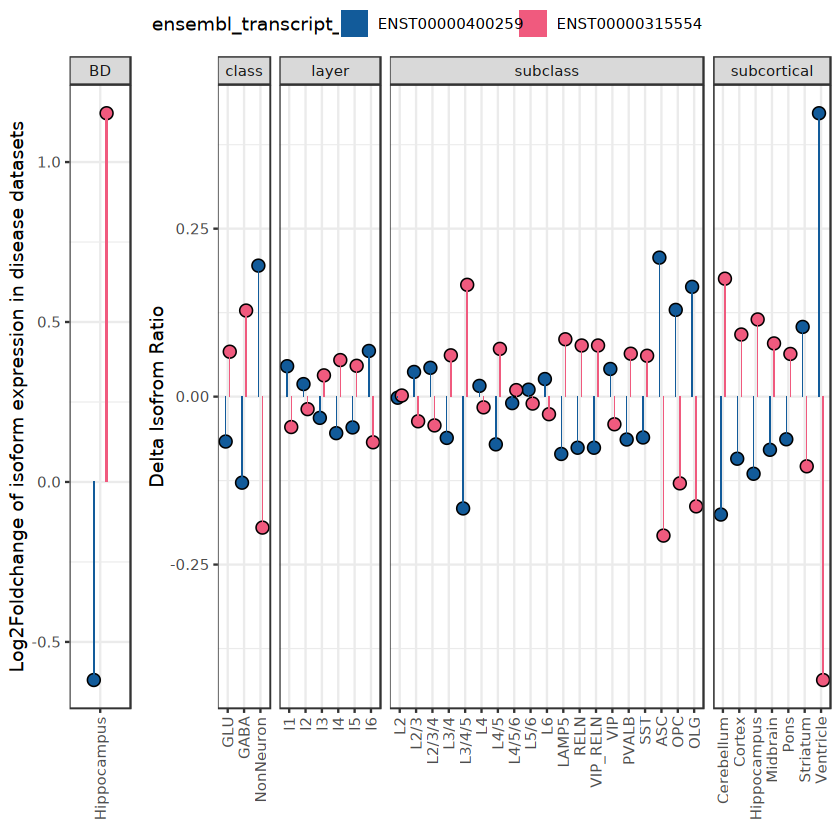

file saved to result/figure5/cross_species_case_subclass_stat_CDC42_25_03_15.pdf

file saved to result/figure5/cross_species_case_subclass_stat_MYL6_25_03_15.pdf



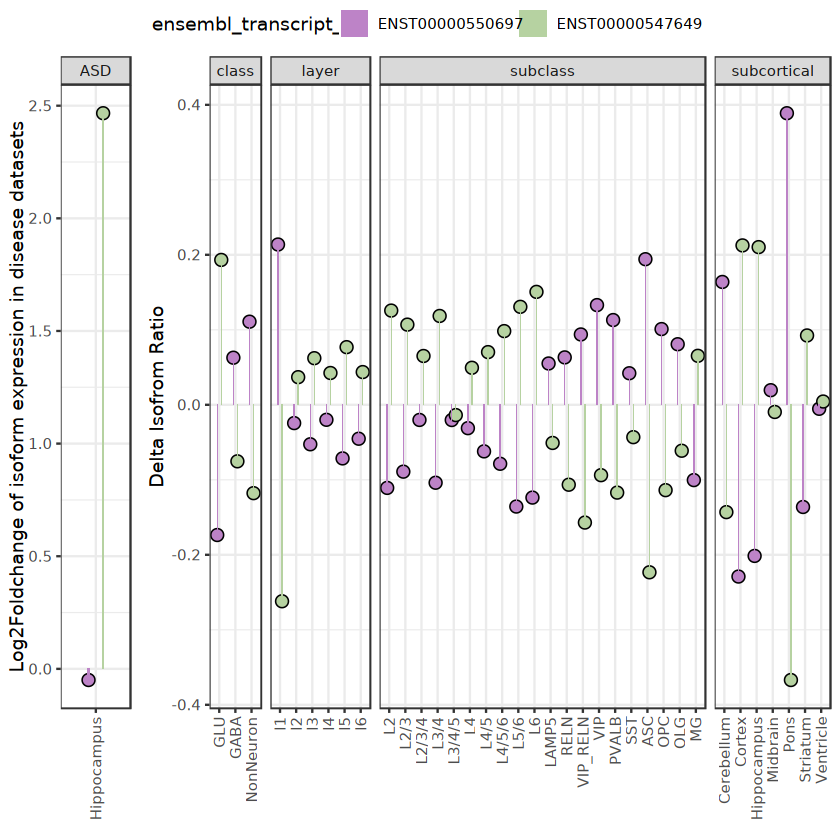

In [752]:

CrossSplicePlot = function(d2,geneid,transidref,isosigi,mycolors,diseaseid){
    refcase = d2[d2$ensembl_transcript_id %in% transidref,]
    refcase = refcase[,c("external_gene_id","ensembl_transcript_id","value")]
    #refcase = melt(refcase)
    refcase$xid = "Hippocampus"
    refcase$ensembl_transcript_id = factor(refcase$ensembl_transcript_id,levels = transidref)
    refcase$group = diseaseid
    p1.0 = ggplot(refcase,aes(x = xid,y = value,fill = ensembl_transcript_id)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        scale_fill_manual(values = mycolors) +
        facet_grid(~group,scales = "free",space = "free") +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) +
        xlab("") + 
    ylab("Log2Foldchange of isoform expression in disease datasets")
    #print(p1.0)

    isosigi = isosigi[isosigi$ref_id %in% transidref,]
    isosigi$ref_id = factor(isosigi$ref_id,levels = transidref)
    isosigi = isosigi[order(isosigi$ref_id),]
    isosigi$transcript_id = factor(isosigi$transcript_id,levels = unique(isosigi$transcript_id))
    
    p1.1 = ggplot(isosigi,aes(x = areatr,fill = transcript_id, y = dr)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        facet_grid(~group,scales = "free",space = "free") +
        scale_fill_manual(values = mycolors) +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("") + ylab("Delta Isofrom Ratio")
    p1.t = ggarrange(p1.0,p1.1,widths = c(0.3,1.5),common.legend = T)
    return(p1.t)
    
}
d2$value = d2$DTU.BD.Value
geneid = "CDC42"
mycolors = c("#125B9A","#F05A7E")
transidref = c("ENST00000400259","ENST00000315554")
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt,mycolors,"BD")
pt1

d2$value = d2$DTU.ASD.Value
geneid = "MYL6"
mycolors = c("#BD83C7","#B6D2A1")
transidref = c("ENST00000550697","ENST00000547649")
pt2 = CrossSplicePlot(d2,geneid,transidref,isosigt,mycolors,"ASD")
pt2

ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_CDC42_25_03_15.pdf",width = 7,height = 3)
ggexport(pt2,filename = "result/figure5/cross_species_case_subclass_stat_MYL6_25_03_15.pdf",width = 7,height = 3)

In [806]:
#isosigls$subclass[isosigls$subclass$gene_id == "CLTB",]
transidref = c("ENST00000397265","ENST00000305108")
unique(isosigt[isosigt$ref_id %in% transidref,c("transcript_id","ref_id")])

transcript_id  ref_id         
463760 XM_005569730.2 ENST00000305108
463826 XM_005569731.2 ENST00000397265

file saved to result/figure5/cross_species_case_subclass_stat_CLTA_ASD_25_03_15.pdf



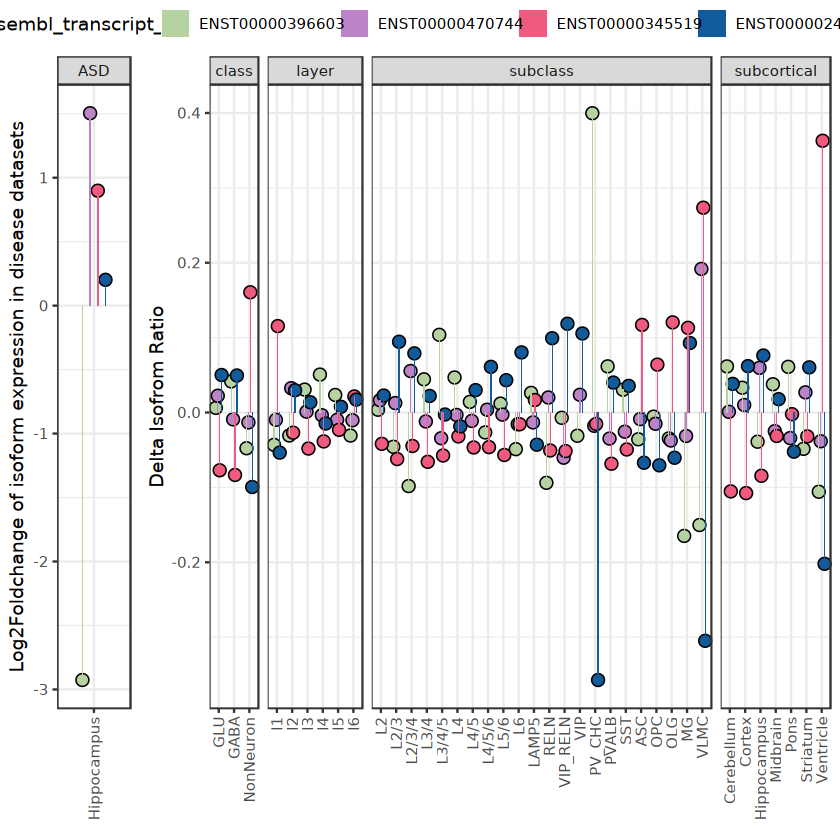

file saved to result/figure5/cross_species_case_subclass_stat_CLTA_BD_25_03_15.pdf



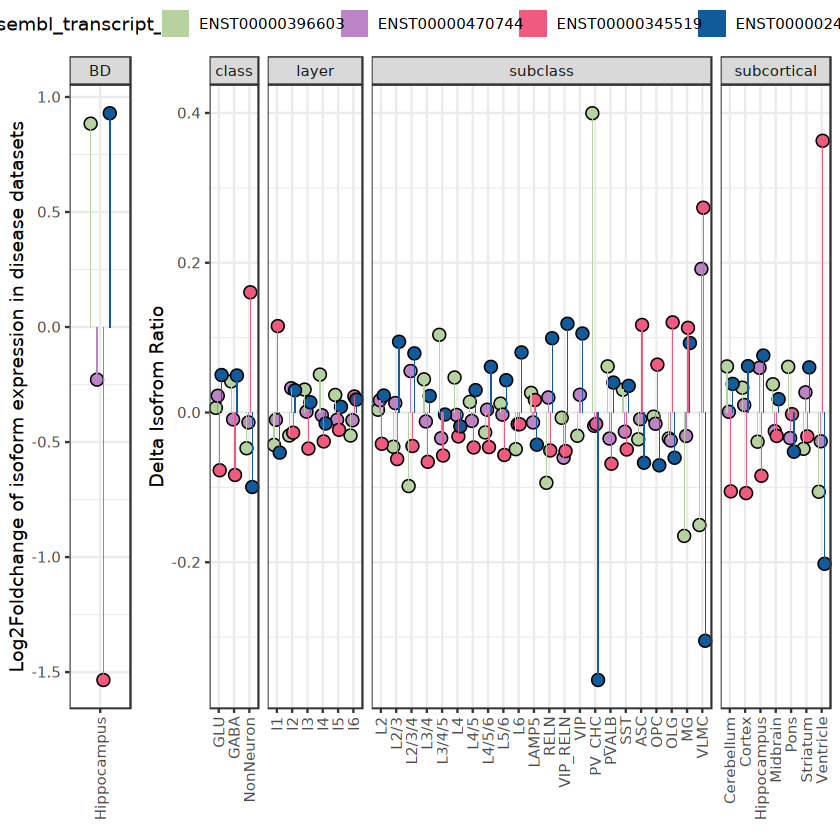

file saved to result/figure5/cross_species_case_subclass_stat_CLTB_ASD_25_03_15.pdf



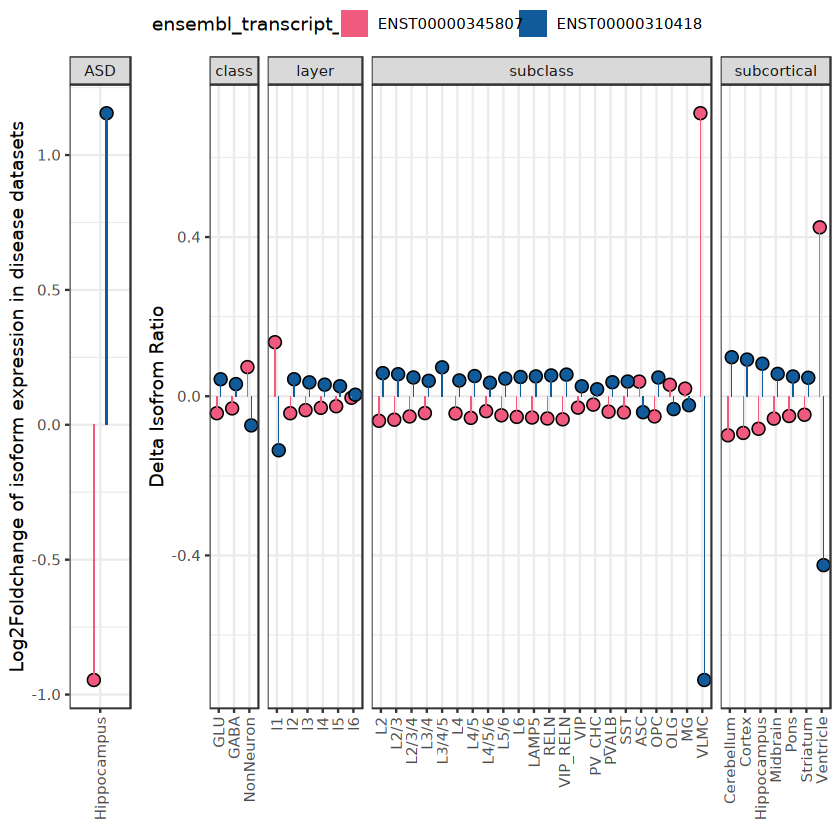

file saved to result/figure5/cross_species_case_subclass_stat_NINJ2_SCZ_25_03_15.pdf



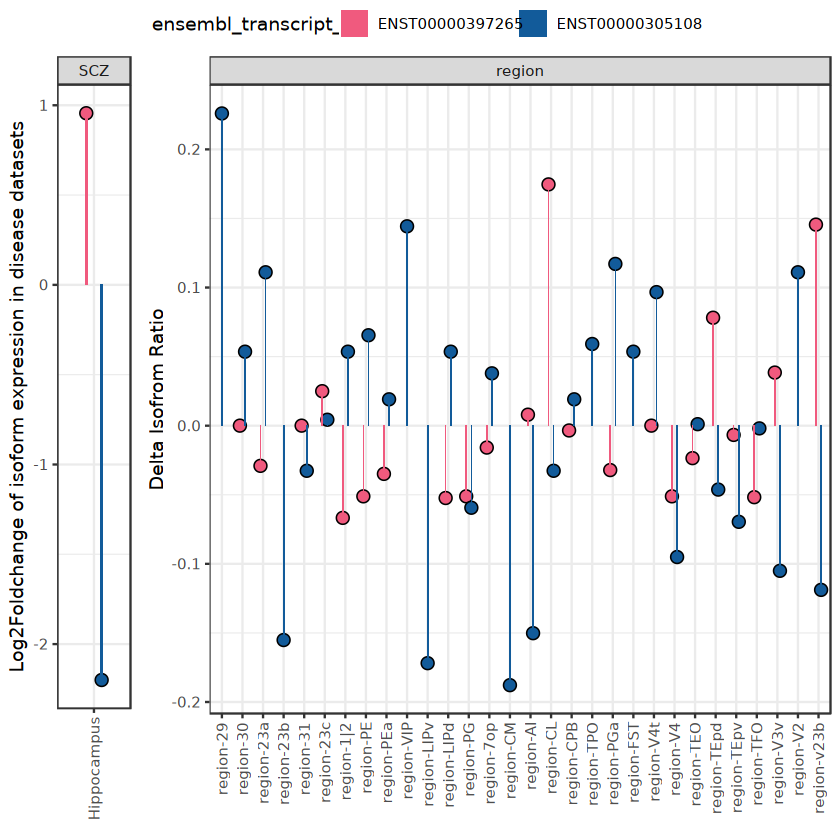

In [863]:
d2$value = d2$DTU.ASD.Value
geneid = "CLTA"
mycolors = c("#B6D2A1","#BD83C7","#F05A7E","#125B9A")
transidref = c("ENST00000396603","ENST00000470744","ENST00000345519","ENST00000242285")
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group != "region",],mycolors,"ASD")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_CLTA_ASD_25_03_15.pdf",width = 12,height = 4)

d2$value = d2$DTU.BD.Value
transidref = c("ENST00000396603","ENST00000470744","ENST00000345519","ENST00000242285")
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group != "region",],mycolors,"BD")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_CLTA_BD_25_03_15.pdf",width = 12,height = 4)

geneid = "CLTB"
mycolors = c("#F05A7E","#125B9A")
transidref = c("ENST00000345807","ENST00000310418")
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group != "region",],mycolors,"ASD")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_CLTB_ASD_25_03_15.pdf",width = 12,height = 4)

geneid = "NINJ2"
mycolors = c("#F05A7E","#125B9A")
transidref = c("ENST00000397265","ENST00000305108")
d2$value = d2$DTU.SCZ.Value
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group == "region",],mycolors,"SCZ")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_NINJ2_SCZ_25_03_15.pdf",width = 12,height = 4)


# d2$value = d2$DTU.ASD.Value
# geneid = "RWDD1"
# mycolors = c("#F05A7E","#125B9A")
# transidref = c("ENST00000487832","ENST00000392526")
# pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt,mycolors,"BD")
# pt1


file saved to result/figure5/cross_species_case_region_stat_SNRPN_SCZ_25_03_15.pdf



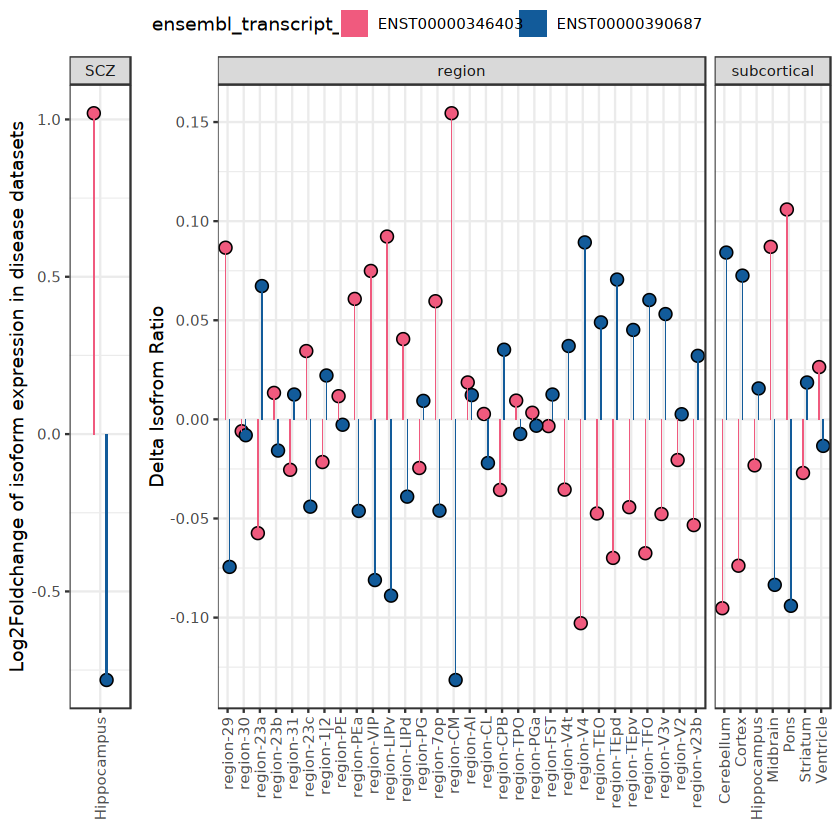

file saved to result/figure5/cross_species_case_subclass_stat_SNRPN_SCZ_25_03_15.pdf



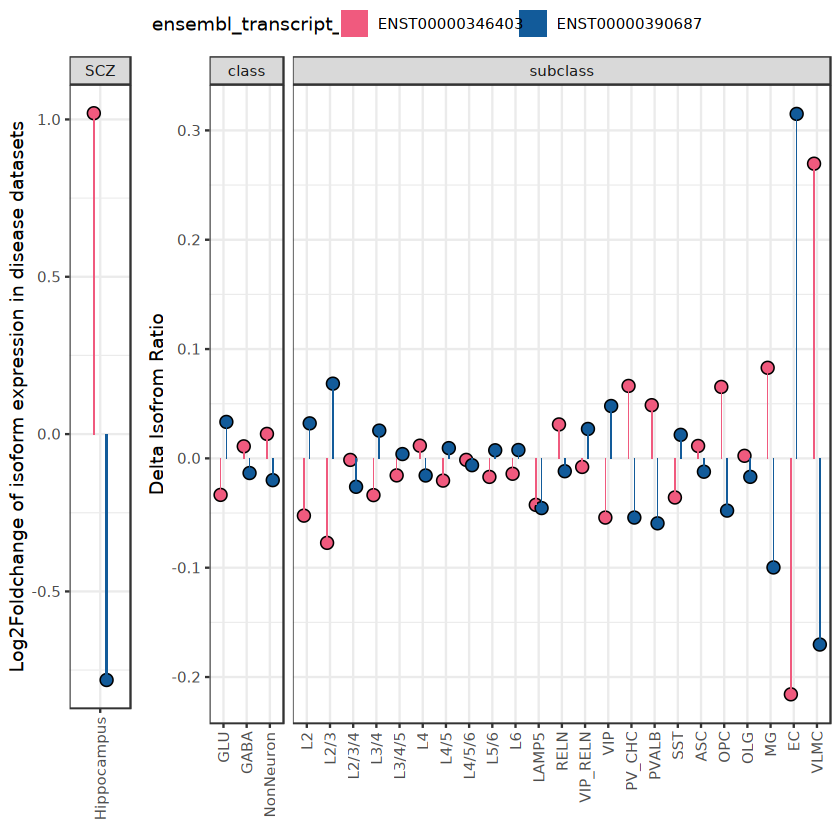

In [865]:
geneid = "SNRPN"
mycolors = c("#F05A7E","#125B9A")
transidref = c("ENST00000346403","ENST00000390687")
d2$value = d2$DTU.SCZ.Value
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group %in% c("region","subcortical"),],mycolors,"SCZ")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_region_stat_SNRPN_SCZ_25_03_15.pdf",width = 12,height = 4)

geneid = "SNRPN"
mycolors = c("#F05A7E","#125B9A")
transidref = c("ENST00000346403","ENST00000390687")
d2$value = d2$DTU.SCZ.Value
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group %in% c("subclass","class"),],mycolors,"SCZ")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_SNRPN_SCZ_25_03_15.pdf",width = 10,height = 4)


In [846]:
#unique(isosigcmpt[isosigcmpt$gene_id %in% "RSRP1",c("transcript_id","ref_id")])
hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "SNRPN",]

ref_gene_id        ref_id          class_code qry_gene_id qry_id        
32782 ENSG00000128739.16 ENST00000346403 =          SNRPN       XM_005558943.2
32784 ENSG00000128739.16 ENST00000390687 =          SNRPN       NM_001287684.1
      num_exons FPKM TPM cov len  major_iso_id   ref_match_len
32782 10        0    0   0   1304 XM_015452467.1 1304         
32784 10        0    0   0   1278 XM_015452467.1 1527

file saved to result/figure5/SNRPN-spatial_reads_point_25_03_18.pdf



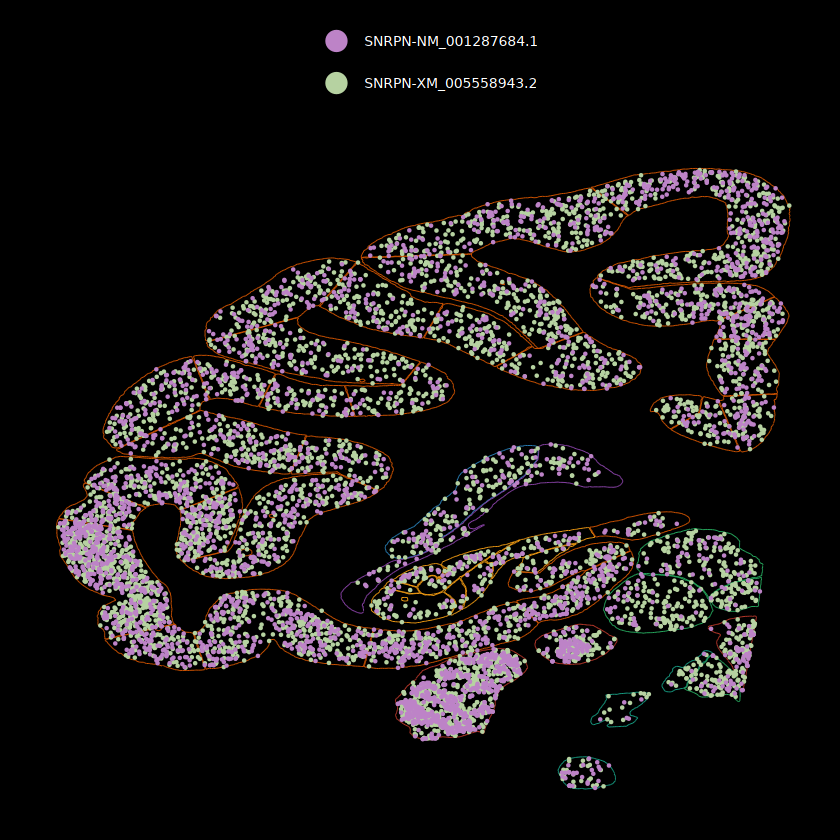

In [852]:
mycolor =  c('#BD83C7','#B6D2A1')
geneex = "SNRPN"
hubtrans = c("SNRPN-NM_001287684.1","SNRPN-XM_005558943.2")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 1,mycolor,0.1)
pci
ggexport(pci,filename = "result/figure5/SNRPN-spatial_reads_point_25_03_18.pdf", width = 4,height = 6)

Using external_gene_id, ensembl_transcript_id as id variables



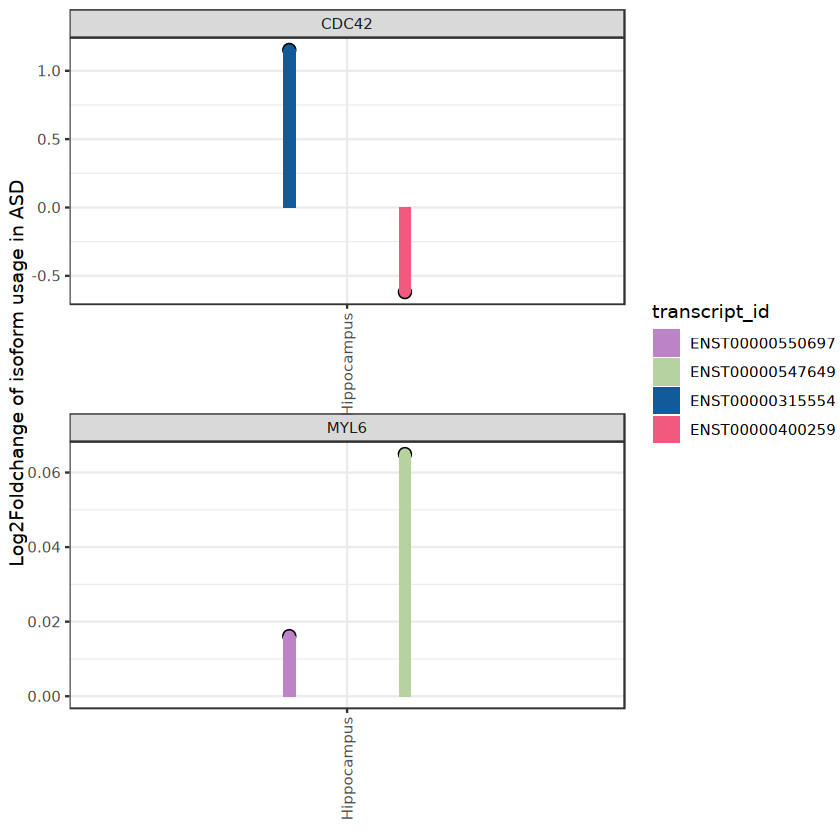

In [620]:
refcase = d2[d2$ensembl_transcript_id %in% c("ENST00000547649","ENST00000550697","ENST00000400259","ENST00000315554"),]
#MYL6-WeiLab-2 CDC42-WeiLab-1
mycolors = c("#B6D2A1","#BD83C7","#F05A7E","#125B9A")
names(mycolors) = c("ENST00000547649","ENST00000550697","ENST00000400259","ENST00000315554")

refcase = refcase[,c("external_gene_id","ensembl_transcript_id","DTU.BD.Value")]
refcase = melt(refcase)
colnames(refcase) = c("gene_id","transcript_id","sample","value")
refcase$xid = "Hippocampus"
refcase$transcript_id = factor(refcase$transcript_id,levels = c("ENST00000550697","ENST00000547649",
                                                                "ENST00000315554","ENST00000400259"))
p1.0 = ggplot(refcase,aes(x = xid,y = value,fill = transcript_id)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        scale_fill_manual(values = mycolors) +
        facet_wrap(~gene_id,ncol = 1,scales = "free") +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) +
        xlab("") + 
    ylab("Log2Foldchange of isoform usage in ASD")
p1.0
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2", "CDC42-WeiLab-1", "NM_001283401.1"),]
#isosigi


file saved to result/figure5/cross_species_case_subclass_stat_25_03_15.pdf



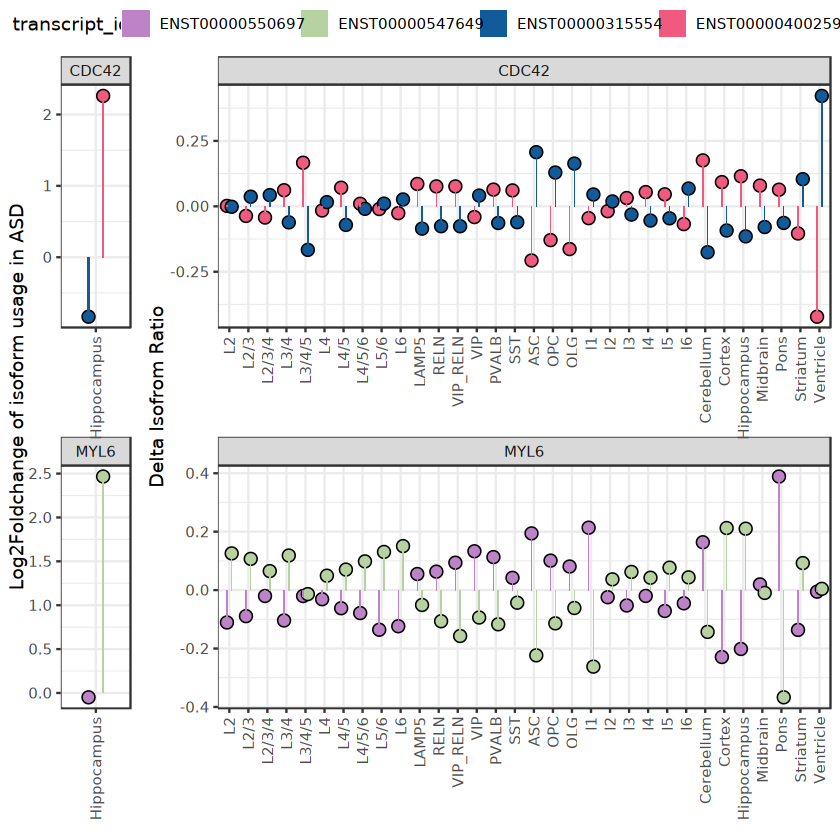

In [283]:
names(mycolors) = c("MYL6-WeiLab-2","MYL6-WeiLab-1", "CDC42-WeiLab-1", "NM_001283401.1")
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2", "CDC42-WeiLab-1", "NM_001283401.1"),]
isosigi = isosigi %>% group_by(areatr) %>% filter(length(unique(transcript_id)) == 4)
isosigi$group = "subclass"

isosigi2 = isosigls$layer
isosigi2 = isosigi2[isosigi2$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2", "CDC42-WeiLab-1", "NM_001283401.1"),]
isosigi2$group = "layer"

isosigi3 = isosigls$subcortical
isosigi3 = isosigi3[isosigi3$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2", "CDC42-WeiLab-1", "NM_001283401.1"),]
isosigi3$group = "subcortical"

isosigi = rbind(isosigi,isosigi2,isosigi3)
isosigi$areatr = factor(isosigi$areatr,c(suborder,layerorder,subcororder))
p1.1 = ggplot(isosigi,aes(x = areatr,fill = transcript_id, y = dr)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        facet_wrap(~gene_id,ncol = 1,scales = "free") +
        scale_fill_manual(values = mycolors) +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("") + ylab("Delta Isofrom Ratio")
p1.t = ggarrange(p1.0,p1.1,widths = c(0.3,1.5),common.legend = T)
p1.t
ggexport(p1.t,filename = "result/figure5/cross_species_case_subclass_stat_25_03_15.pdf",width = 7,height = 5.5)

In [290]:
gtf.ms = rtracklayer::import("ref/mouse.gencode.vM36.annotation.gtf.gz")
hubtrans = c("ENST00000550697.6","ENST00000547649.5")
#"gencode.v19.annotation.gtf.gz"
gtf.hp = rtracklayer::import("ref/human.gencode.v47.annotation.gtf.gz")
hubtrans = c("ENST00000550697.6","ENST00000547649.5")
gtf.hp[gtf.hp$gene_name == "MYL6" & gtf.hp$transcript_id %in% hubtrans,]
unique(gtf.ms[gtf.ms$gene_name == "Myl6",]$transcript_name)

GRanges object with 36 ranges and 22 metadata columns:
       seqnames            ranges strand |   source        type     score
          <Rle>         <IRanges>  <Rle> | <factor>    <factor> <numeric>
   [1]    chr12 56158359-56161579      + |   HAVANA transcript         NA
   [2]    chr12 56158359-56158404      + |   HAVANA exon               NA
   [3]    chr12 56158402-56158404      + |   HAVANA CDS                NA
   [4]    chr12 56158402-56158404      + |   HAVANA start_codon        NA
   [5]    chr12 56158684-56158711      + |   HAVANA exon               NA
   ...      ...               ...    ... .      ...         ...       ...
  [32]    chr12 56161387-56161574      + |   HAVANA  exon              NA
  [33]    chr12 56161387-56161412      + |   HAVANA  CDS               NA
  [34]    chr12 56161413-56161415      + |   HAVANA  stop_codon        NA
  [35]    chr12 56158362-56158401      + |   HAVANA  UTR               NA
  [36]    chr12 56161413-56161574      + |   HAVANA  UTR 

[1] NA         "Myl6-201" "Myl6-213" "Myl6-212" "Myl6-202" "Myl6-206"
 [7] "Myl6-209" "Myl6-211" "Myl6-205" "Myl6-203" "Myl6-214" "Myl6-208"
[13] "Myl6-215" "Myl6-207" "Myl6-210" "Myl6-204"

In [292]:
library(ggbio)
library(ggtranscript)

#Txrefplot(gtfdf)
Txrefplot = function(gtfdf,groupid,mycolor = NULL){
    tartrans = gtfdf[gtfdf$type == "exon",]
    tartrans = tartrans[order(tartrans$transcript_name),]
    tartrans$orid = as.numeric(tartrans$transcript_name)
#    tartrans$group = NA
    tartranstx = tartrans %>% group_by(transcript_name,orid) %>% 
      summarise(start = min(start),end = max(end))
    #tartranstx$group = NA
    mylim = c(min(tartranstx$start)-1000,max(tartranstx$end)+1000)
    library(ggh4x)
    if(is.null(mycolor)){
        no_of_colors = length(unique(tartrans$transcript_name)) 
        colorful_palette = distinctColorPalette(no_of_colors) 
        names(colorful_palette) = levels(tartrans$transcript_name)
    }else{
        colorful_palette = mycolor
        names(colorful_palette) = levels(tartrans$transcript_name)
    }
    
    pc = ggplot() +
      geom_range(data = tartrans,
                 aes(xstart = start,xend = end,
                     y = orid,
                     fill = transcript_name,color = transcript_name),
                 size = 0.2) +
      geom_intron(data = to_intron(tartrans,
                                   "transcript_name"),
                  aes(xstart = start,xend = end,y = orid,strand = strand,color = transcript_name),
                  size = 0.2,
                  arrow.min.intron.length = 200,
                  arrow = arrow(length=unit(0.3,"cm"))) +
      geom_text(data = tartranstx,
                aes(x = (start + end) / 2,y = orid+0.5,
                    label = transcript_name),
                size = 5, vjust = -0.1, color = "black") +
     # facet_grid2(group~.,scales = "free",
     #             strip = strip_themed(
     #               text_y = facetcol
    #            )) +
      #facet_wrap(group~.,scales = "free",ncol = 1,strip.position = "left") +
      scale_x_continuous(limits = mylim)+
      scale_color_manual(values = colorful_palette) +
      scale_fill_manual(values = colorful_palette) +
      # scale_fill_discreterainbow() +
      # scale_color_discreterainbow() +
      theme_bw() + 
      ggtitle(groupid) +
      theme(legend.position = "none",panel.grid = element_blank(),
            axis.text.y = element_blank(),axis.ticks.y = element_blank(),
            panel.spacing = unit(0,'lines'),
            strip.background = element_rect(fill = NA,color = NA),
            strip.placement = "outside",
            plot.title = element_text(hjust = 0.5)) + xlab("") + ylab("")
    pc
    return(pc)
}

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
Warning message:
"Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead."
file saved to result/figure5/MYL6-cross_species_sliced_compare_25_03_18.pdf



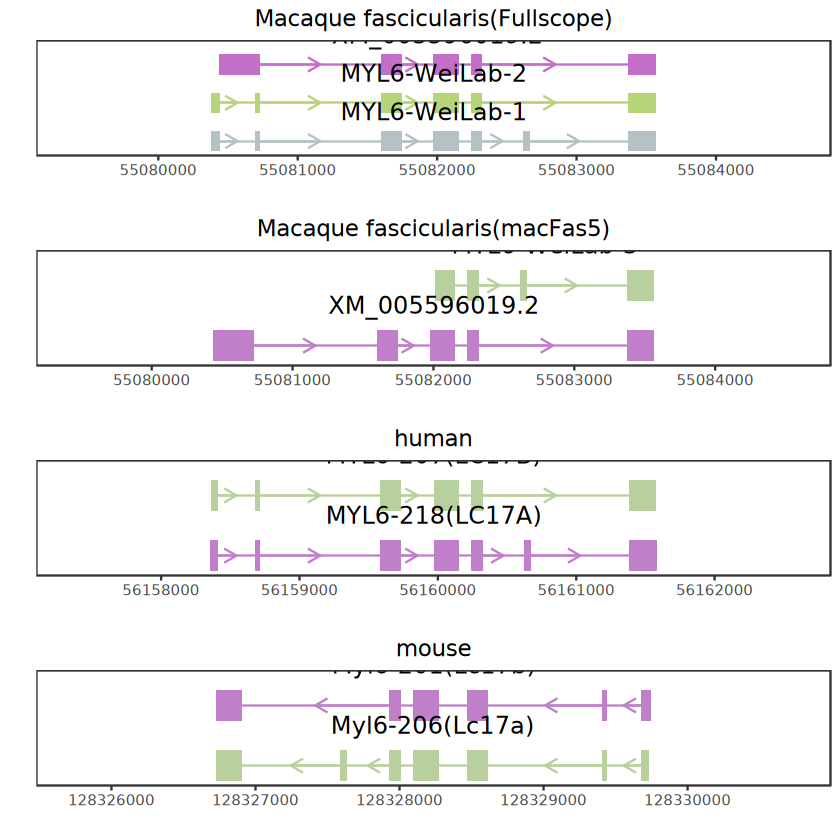

R packages available

Packages in library '/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library':

abind                   Combine Multidimensional Arrays
ade4                    Analysis of Ecological Data: Exploratory and
                        Euclidean Methods in Environmental Sciences
admixtools              Inferring demographic history from genetic data
amap                    Another Multidimensional Analysis Package
annotate                Annotation for microarrays
AnnotationDbi           Manipulation of SQLite-based annotations in
                        Bioconductor
AnnotationFilter        Facilities for Filtering Bioconductor
                        Annotation Resources
AnnotationHub           Client to access AnnotationHub resources
anytime                 Anything to 'POSIXct' or 'Date' Converter
ape                     Analyses of Phylogenetics and Evolution
aplot                   Decorate a 'ggplot' with Associated Information
arrow             

In [296]:
library()
geneex = "MYL6"
hubtrans = c("MYL6-WeiLab-1","MYL6-WeiLab-2","XM_005596019.2")
gtfdf = as.data.frame(gtf[which(gtf$gene_id == geneex & gtf$transcript_name %in% hubtrans),])
gtfdf$transcript_name = factor(gtfdf$transcript_name,levels = c("MYL6-WeiLab-1","MYL6-WeiLab-2","XM_005596019.2"))
groupid = "Macaque fascicularis(Fullscope)"
pc1 = Txrefplot(gtfdf,groupid)

geneex = "MYL6"
hubtrans = c("XM_005596019.2","MYL6-WeiLab-3")
gtfdf = as.data.frame(gtf[which(gtf$gene_id == geneex & gtf$transcript_name %in% hubtrans),])
gtfdf$transcript_name = factor(gtfdf$transcript_name,levels = c("XM_005596019.2","MYL6-WeiLab-3"))
groupid = "Macaque fascicularis(macFas5)"
pc2 = Txrefplot(gtfdf,groupid)

#human
hubtrans = c("ENST00000550697.6","ENST00000547649.5")
gtfdf.hp = as.data.frame(gtf.hp[gtf.hp$gene_name == "MYL6" & gtf.hp$transcript_id %in% hubtrans,])
gtfdf.hp[gtfdf.hp$transcript_name == "MYL6-218",]$transcript_name = paste0(gtfdf.hp[gtfdf.hp$transcript_name == "MYL6-218",]$transcript_name,
                                                                          ("(LC17A)"))
gtfdf.hp[gtfdf.hp$transcript_name == "MYL6-207",]$transcript_name = paste0(gtfdf.hp[gtfdf.hp$transcript_name == "MYL6-207",]$transcript_name,
                                                                          ("(LC17B)"))
#https://www.ncbi.nlm.nih.gov/nuccore/NM_079423.4
#https://www.ncbi.nlm.nih.gov/nuccore/NM_021019.5
gtfdf.hp$transcript_name = factor(gtfdf.hp$transcript_name,levels = c("MYL6-218(LC17A)","MYL6-207(LC17B)")) 
groupid = "human"
pc3 = Txrefplot(gtfdf.hp,groupid)

#mouse
hubtrans = c("Myl6-206","Myl6-201")
gtfdf.ms = as.data.frame(gtf.ms[gtf.ms$gene_name == "Myl6" & gtf.ms$transcript_name %in% hubtrans,])
gtfdf.ms[gtfdf.ms$transcript_name == "Myl6-206",]$transcript_name = paste0(gtfdf.ms[gtfdf.ms$transcript_name == "Myl6-206",]$transcript_name,
                                                                          ("(Lc17a)"))
gtfdf.ms[gtfdf.ms$transcript_name == "Myl6-201",]$transcript_name = paste0(gtfdf.ms[gtfdf.ms$transcript_name == "Myl6-201",]$transcript_name,
                                                                          ("(Lc17b)"))
hubtrans = c("Myl6-206(Lc17a)","Myl6-201(Lc17b)")
gtfdf.ms = gtfdf.ms[order(gtfdf.ms$transcript_name),]
# gtfdf.ms$start = -gtfdf.ms$start
# gtfdf.ms$end = -gtfdf.ms$end
# gtfdf.ms$strand = "+"
gtfdf.ms$transcript_name = factor(gtfdf.ms$transcript_name,levels = hubtrans) 
groupid = "mouse"
pc4 = Txrefplot(gtfdf.ms,groupid)
pct = ggarrange(pc1,pc2,pc3,pc4,ncol = 1)
pct
ggexport(pct,filename = "result/figure5/MYL6-cross_species_sliced_compare_25_03_18.pdf",width = 8,height = 6)

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


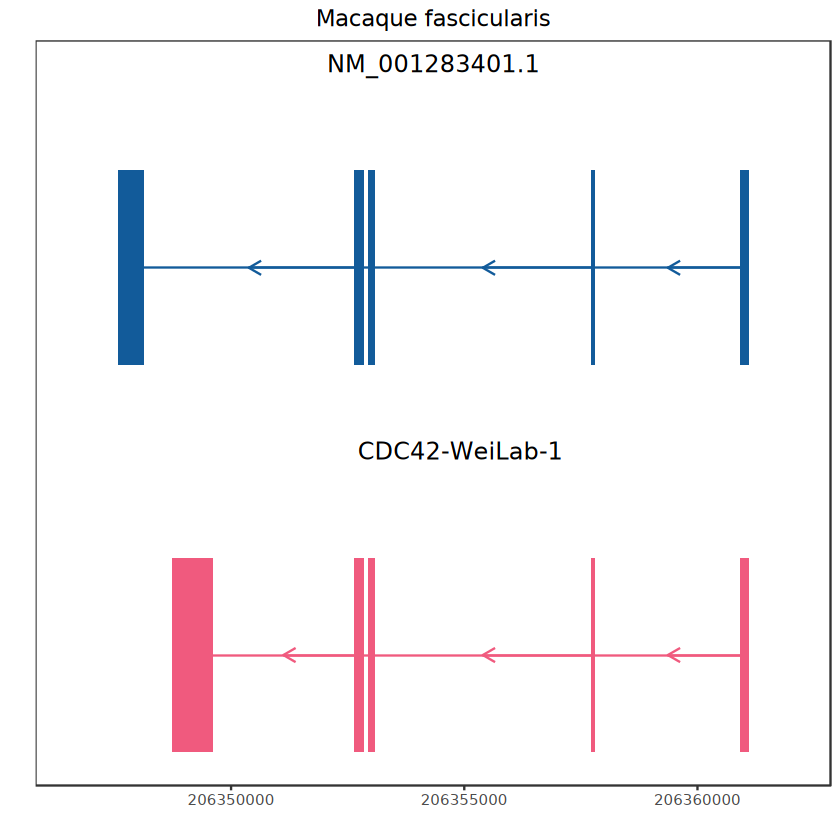

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


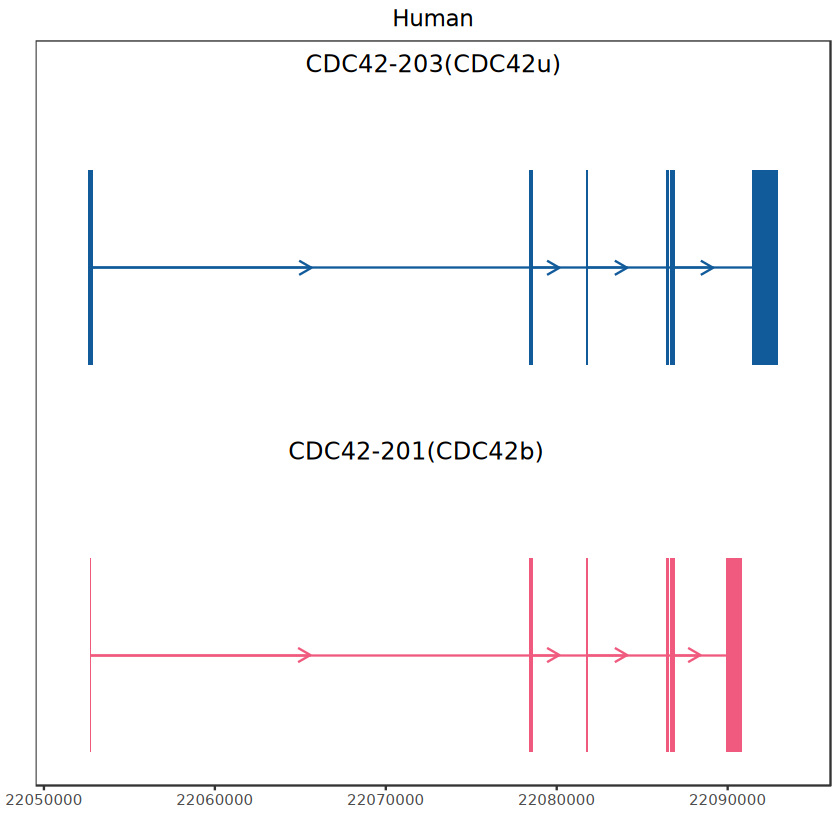

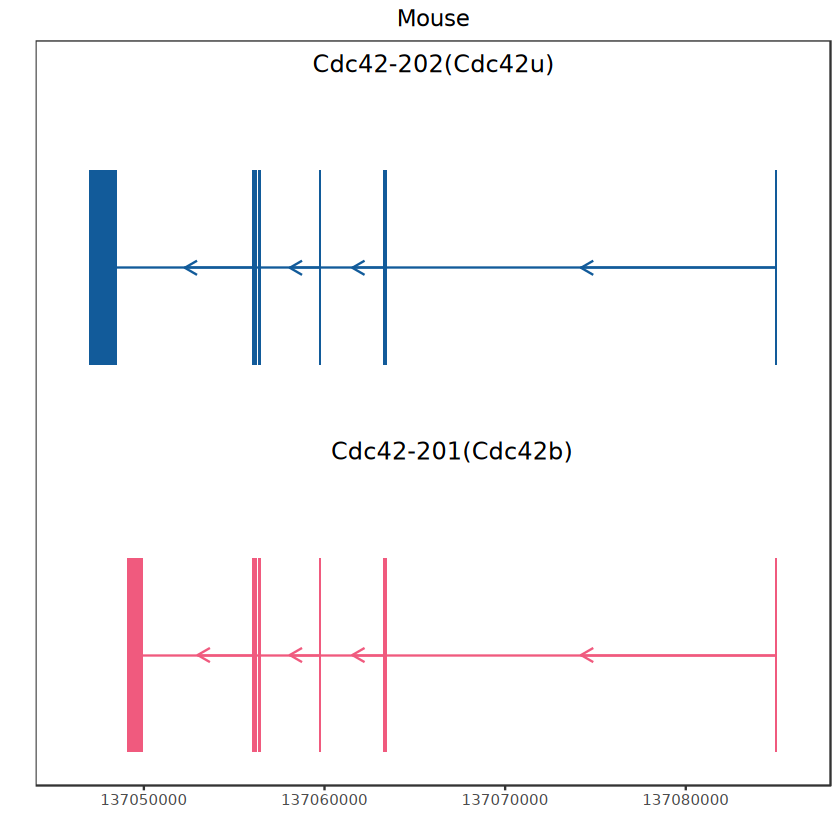

file saved to result/figure5/CDC42-cross_species_sliced_compare_24_12_24.pdf



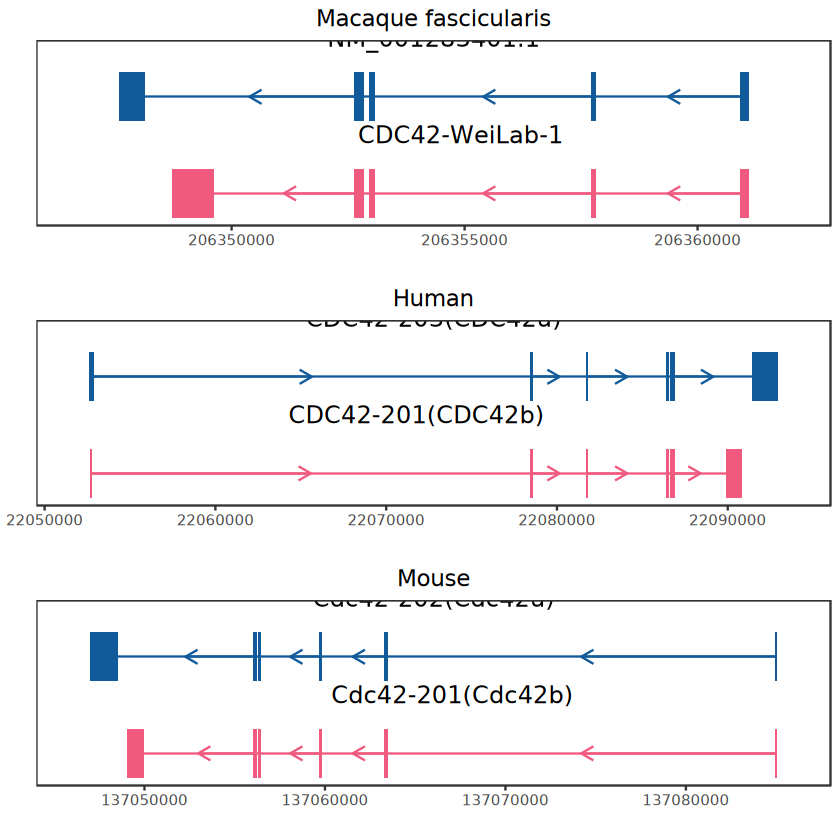

In [146]:
#"ENST00000400259","ENST00000315554"
#"CDC42b" "CDC42u"
geneex = "CDC42"
mycolor = c("#F05A7E","#125B9A")
#hubtrans = c("MYL6-WeiLab-1","MYL6-WeiLab-2")
gtfdf = as.data.frame(gtf[which(gtf$gene_id == geneex),])
gtfdf$transcript_name = factor(gtfdf$transcript_name,levels = c("CDC42-WeiLab-1","NM_001283401.1"))
groupid = "Macaque fascicularis"
pc1 = Txrefplot(gtfdf,groupid,mycolor)
pc1

hubtrans = c("ENST00000400259.5","ENST00000315554.15")
#gtf.hp[gtf.hp$gene_name == "CDC42" & gtf.hp$transcript_id %in%  hubtrans & gtf.hp$type == "transcript",]
gtfdf.hp.hub = as.data.frame(gtf.hp[gtf.hp$gene_name == "CDC42" & gtf.hp$transcript_id %in% hubtrans,])
gtfdf.hp.hub[gtfdf.hp.hub$transcript_name == "CDC42-203",]$transcript_name = paste0(gtfdf.hp.hub[gtfdf.hp.hub$transcript_name == "CDC42-203",]$transcript_name,
                                                                          "(CDC42u)")
gtfdf.hp.hub[gtfdf.hp.hub$transcript_name == "CDC42-201",]$transcript_name = paste0(gtfdf.hp.hub[gtfdf.hp.hub$transcript_name == "CDC42-201",]$transcript_name,
                                                                          "(CDC42b)")
gtfdf.hp.hub$transcript_name = factor(gtfdf.hp.hub$transcript_name,levels = c("CDC42-201(CDC42b)","CDC42-203(CDC42u)")) 
#gtfdf.hp.hub$transcript_name = factor(gtfdf.hp.hub$transcript_name,levels = unique(gtfdf.hp.hub$transcript_name)) 
groupid = "Human"
pc2 = Txrefplot(gtfdf.hp.hub,groupid,mycolor)
pc2
#hubtrans = c("ENST00000400259.5","ENST00000315554.15")
#gtf.hp[gtf.hp$gene_name == "CDC42" & gtf.hp$transcript_id %in%  hubtrans & gtf.hp$type == "transcript",]
gtfdf.ms.hub = as.data.frame(gtf.ms[gtf.ms$gene_name == "Cdc42",])
#unique(gtfdf.ms.hub$transcript_name)
gtfdf.ms.hub = gtfdf.ms.hub[!is.na(gtfdf.ms.hub$transcript_name),]
#unique(gtfdf.ms.hub$transcript_name)
gtfdf.ms.hub[gtfdf.ms.hub$transcript_name == "Cdc42-202",]$transcript_name = paste0(gtfdf.ms.hub[gtfdf.ms.hub$transcript_name == "Cdc42-202",]$transcript_name,
                                                                          "(Cdc42u)")
gtfdf.ms.hub[gtfdf.ms.hub$transcript_name == "Cdc42-201",]$transcript_name = paste0(gtfdf.ms.hub[gtfdf.ms.hub$transcript_name == "Cdc42-201",]$transcript_name,
                                                                          "(Cdc42b)")
gtfdf.ms.hub$transcript_name = factor(gtfdf.ms.hub$transcript_name,levels = c("Cdc42-201(Cdc42b)","Cdc42-202(Cdc42u)")) 
# gtfdf.ms.hub$transcript_name = factor(gtfdf.ms.hub$transcript_name,levels = unique(gtfdf.ms.hub$transcript_name)) 
groupid = "Mouse"
pc3 = Txrefplot(gtfdf.ms.hub,groupid,mycolor)
pc3
pct = ggarrange(pc1,pc2,pc3,ncol = 1)
pct
ggexport(pct,filename = "result/figure5/CDC42-cross_species_sliced_compare_24_12_24.pdf",width = 6,height = 6)

In [1089]:
#unique(isosigcmpt[isosigcmpt$gene_id %in% "RSRP1",c("transcript_id","ref_id")])
hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "SNRPN",]

ref_gene_id        ref_id          class_code qry_gene_id qry_id        
32782 ENSG00000128739.16 ENST00000346403 =          SNRPN       XM_005558943.2
32784 ENSG00000128739.16 ENST00000390687 =          SNRPN       NM_001287684.1
      num_exons FPKM TPM cov len  major_iso_id   ref_match_len
32782 10        0    0   0   1304 XM_015452467.1 1304         
32784 10        0    0   0   1278 XM_015452467.1 1527

In [1100]:
gtfdf

seqnames    start   end     width  strand source type       score phase
1  NC_022278.1 2811954 2812094    141 +      Bambu  exon       NA    NA   
2  NC_022278.1 2815604 2815759    156 +      Bambu  exon       NA    NA   
3  NC_022278.1 2837895 2960384 122490 +      Bambu  transcript NA    NA   
4  NC_022278.1 2837895 2838066    172 +      Bambu  exon       NA    NA   
5  NC_022278.1 2871791 2871857     67 +      Bambu  exon       NA    NA   
6  NC_022278.1 2871791 2871857     67 +      Bambu  exon       NA    NA   
7  NC_022278.1 2899442 2899561    120 +      Bambu  exon       NA    NA   
8  NC_022278.1 2899442 2899561    120 +      Bambu  exon       NA    NA   
9  NC_022278.1 2944051 2944146     96 +      Bambu  exon       NA    NA   
10 NC_022278.1 2944051 2944146     96 +      Bambu  exon       NA    NA   
11 NC_022278.1 2944051 2944146     96 +      Bambu  exon       NA    NA   
12 NC_022278.1 2944051 2944146     96 +      Bambu  exon       NA    NA   
13 NC_022278.1 2949770 2949920    151 +      Bambu  exon       NA    NA   
14 NC_022278.1 2956142 2956287    146 +      Bambu  exon       NA    NA   
15 NC_022278.1 2956218 2956287     70 +      Bambu  exon       NA    NA   
16 NC_022278.1 2957144 2957295    152 +      Bambu  exon       NA    NA   
17 NC_022278.1 2957144 2957295    152 +      Bambu  exon       NA    NA   
18 NC_022278.1 2958100 2958211    112 +      Bambu  exon       NA    NA   
19 NC_022278.1 2958100 2958211    112 +      Bambu  exon       NA    NA   
20 NC_022278.1 2958100 2958211    112 +      Bambu  exon       NA    NA   
21 NC_022278.1 2958664 2958816    153 +      Bambu  exon       NA    NA   
22 NC_022278.1 2958664 2958816    153 +      Bambu  exon       NA    NA   
23 NC_022278.1 2959568 2959706    139 +      Bambu  exon       NA    NA   
24 NC_022278.1 2959568 2959706    139 +      Bambu  exon       NA    NA   
25 NC_022278.1 2959994 2960119    126 +      Bambu  exon       NA    NA   
26 NC_022278.1 2959994 2960119    126 +      Bambu  exon       NA    NA   
27 NC_022278.1 2960208 2960336    129 +      Bambu  exon       NA    NA   
28 NC_022278.1 2960208 2960384    177 +      Bambu  exon       NA    NA   
   gene_id transcript_id  transcript_name exon_number
1  SNRPN   XM_015452467.1 NA              2          
2  SNRPN   XM_015452467.1 NA              3          
3  SNRPN   XM_015452466.1 NA              NA         
4  SNRPN   XM_015452466.1 NA              1          
5  SNRPN   XM_015452467.1 NA              4          
6  SNRPN   XM_015452466.1 NA              2          
7  SNRPN   XM_015452467.1 NA              5          
8  SNRPN   XM_015452466.1 NA              3          
9  SNRPN   XM_015452466.1 NA              4          
10 SNRPN   XM_005558943.2 XM_005558943.2  2          
11 SNRPN   NM_001287684.1 NM_001287684.1  2          
12 SNRPN   XM_015452469.1 NA              2          
13 SNRPN   NM_001287684.1 NM_001287684.1  3          
14 SNRPN   XM_015452467.1 NA              8          
15 SNRPN   XM_005558943.2 XM_005558943.2  4          
16 SNRPN   XM_015452467.1 NA              9          
17 SNRPN   NM_001287684.1 NM_001287684.1  5          
18 SNRPN   XM_015452467.1 NA              10         
19 SNRPN   NM_001287684.1 NM_001287684.1  6          
20 SNRPN   XM_015452469.1 NA              5          
21 SNRPN   NM_001287684.1 NM_001287684.1  7          
22 SNRPN   XM_015452469.1 NA              6          
23 SNRPN   NM_001287684.1 NM_001287684.1  8          
24 SNRPN   XM_015452469.1 NA              7          
25 SNRPN   NM_001287684.1 NM_001287684.1  9          
26 SNRPN   XM_015452469.1 NA              8          
27 SNRPN   NM_001287684.1 NM_001287684.1  10         
28 SNRPN   XM_015452469.1 NA              9

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


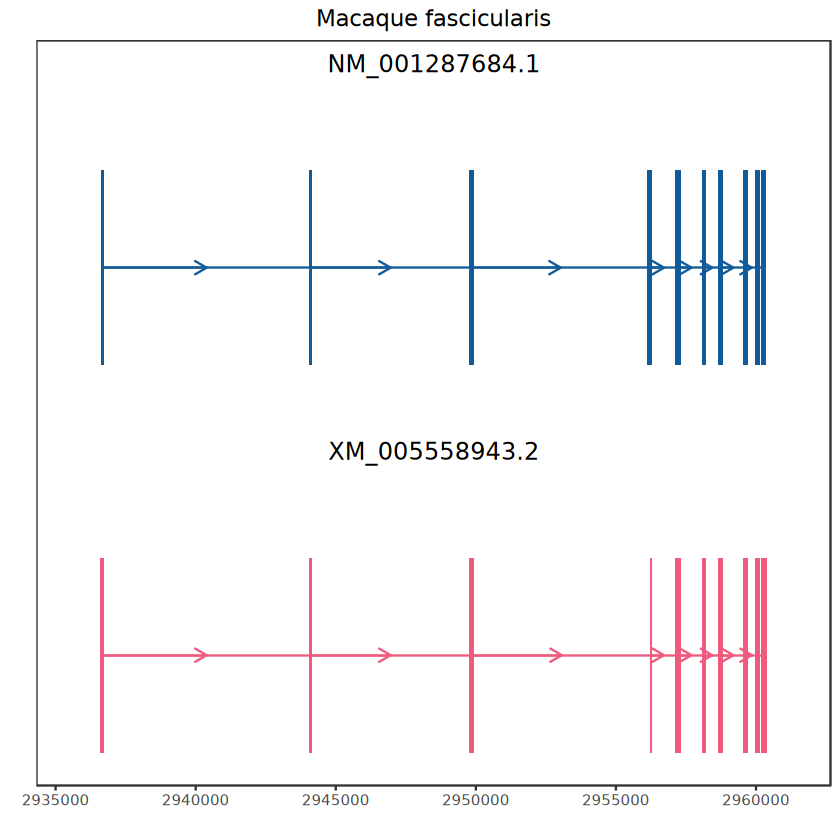

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


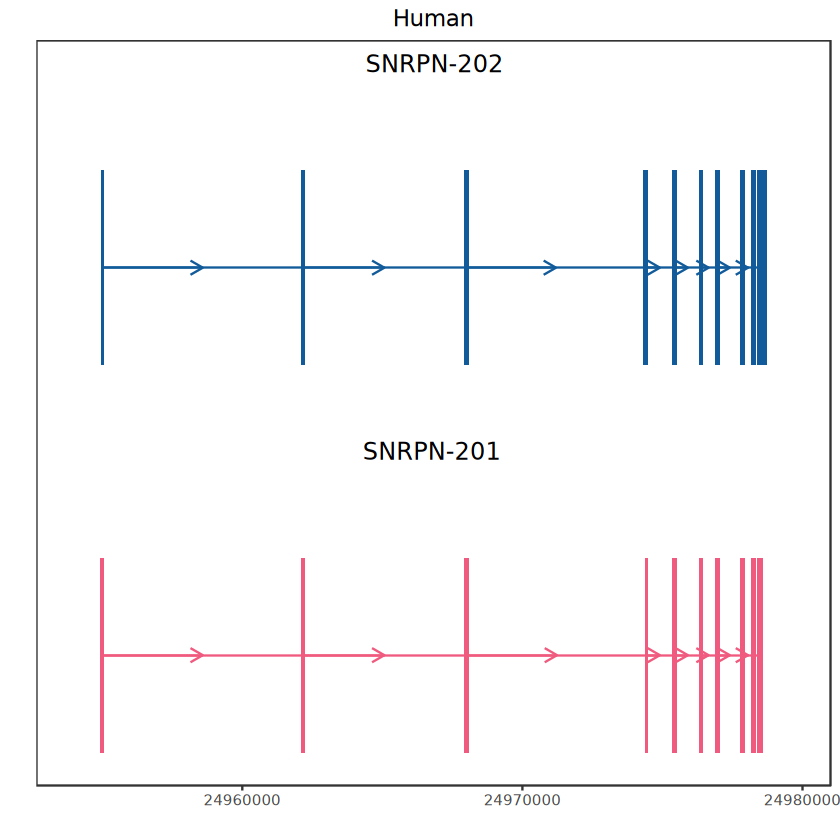

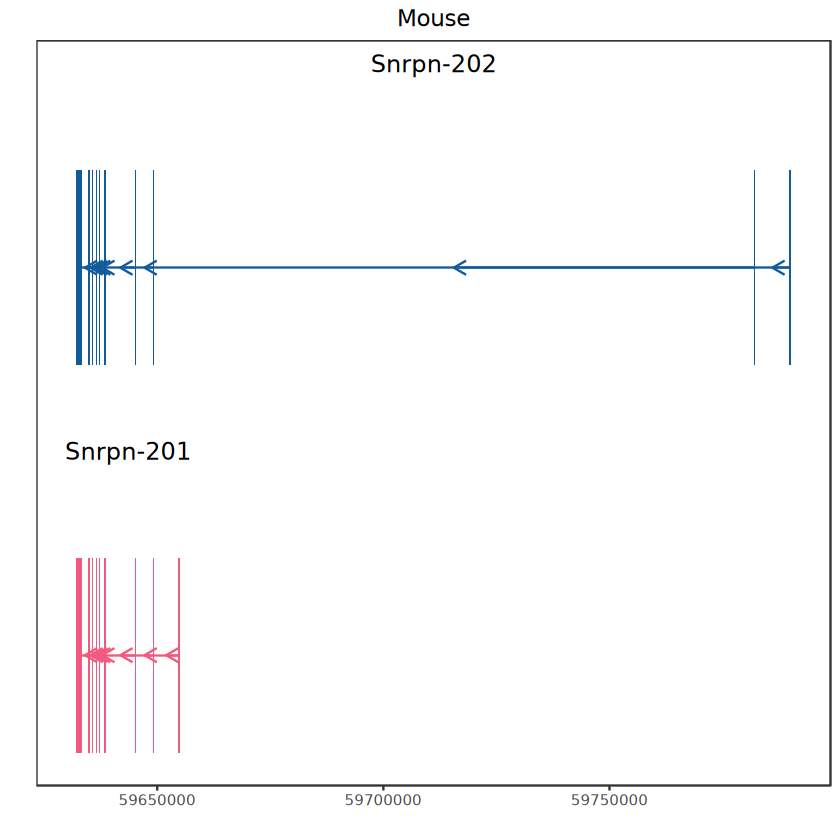

file saved to result/figure5/SNRPN-cross_species_sliced_compare_25_03_24.pdf



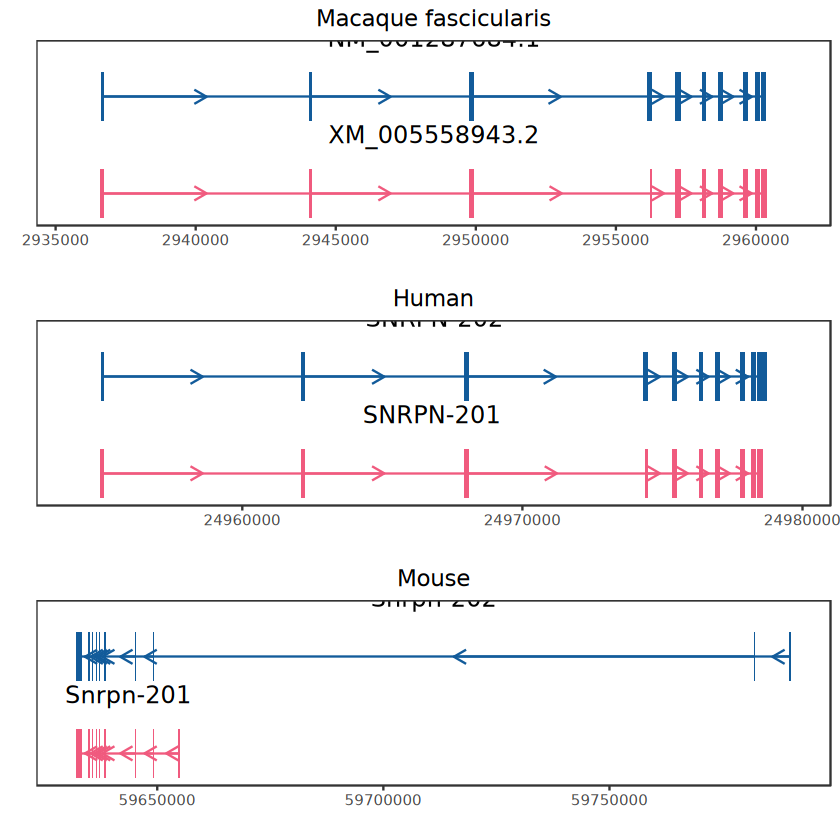

In [1102]:
#"ENST00000346403","ENST00000390687"
#"CDC42b" "CDC42u"
geneex = "SNRPN"
mycolor = c("#F05A7E","#125B9A")
gtfdf = as.data.frame(gtf[gtf$gene_id == geneex & gtf$transcript_id %in% c("XM_005558943.2","NM_001287684.1"),])
gtfdf$transcript_name = factor(gtfdf$transcript_id,levels = c("XM_005558943.2","NM_001287684.1"))
groupid = "Macaque fascicularis"
pc1 = Txrefplot(gtfdf,groupid,mycolor)
pc1

hubtrans = c("ENST00000346403.10","ENST00000390687.9")
gtfdf.hp.hub = as.data.frame(gtf.hp[gtf.hp$gene_name == "SNRPN" & gtf.hp$transcript_id %in% hubtrans,])
gtfdf.hp.hub$transcript_name = factor(gtfdf.hp.hub$transcript_name,levels = c("SNRPN-201","SNRPN-202")) 
#gtfdf.hp.hub$transcript_name = factor(gtfdf.hp.hub$transcript_name,levels = unique(gtfdf.hp.hub$transcript_name)) 
groupid = "Human"
pc2 = Txrefplot(gtfdf.hp.hub,groupid,mycolor)
pc2
gtfdf.ms.hub = as.data.frame(gtf.ms[gtf.ms$gene_name == "Snrpn",])
#unique(gtfdf.ms.hub$transcript_name)
gtfdf.ms.hub = gtfdf.ms.hub[!is.na(gtfdf.ms.hub$transcript_name),]
#unique(gtfdf.ms.hub$transcript_name)
gtfdf.ms.hub$transcript_name = factor(gtfdf.ms.hub$transcript_name,levels = unique(gtfdf.ms.hub$transcript_name)) 
groupid = "Mouse"
pc3 = Txrefplot(gtfdf.ms.hub,groupid,mycolor)
pc3
pct = ggarrange(pc1,pc2,pc3,ncol = 1)
pct
ggexport(pct,filename = "result/figure5/SNRPN-cross_species_sliced_compare_25_03_24.pdf",width = 6,height = 6)

In [ ]:
geneex = "MYL6"
fsraw.cor.hub = fsraw.cor[!fsraw.cor$subclass %in% c("PV_CHC","VLMC"),]
grtdfl = BuildPlotBed(fsraw.cor.hub,longbed,"subclass",geneex,NULL)
grtdfl = grtdfl[grtdfl$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2"),]
grtdfl = grtdfl %>% group_by(readid) %>% filter(n()> 1)
grtdfl$group = factor(grtdfl$group,levels = suborder)
pci = tryCatch(IsoformReadPlot(gtf, grtdfl,geneex,onlyhub = T), error = function(e) NULL)
pci
ggexport(pci,filename = "result/figure5/dtu_case_ls_disease_MYL6_gene_readsplice_24_11_21.pdf",
           width = 5,height = 10)

In [307]:
rgb(189,131,199,maxColorValue = 255)
rgb(182,210,161,maxColorValue = 255)

rgb(240,90,126,maxColorValue = 255)
rgb(18,91,154,maxColorValue = 255)
c("CDC42-FS-1","NM_001283401.1")

[1] "#BD83C7"

[1] "#B6D2A1"

[1] "#F05A7E"

[1] "#125B9A"

[1] "CDC42-FS-1"     "NM_001283401.1"

In [324]:
mycolor =  c('#BD83C7','#B6D2A1')
geneex = "MYL6"
hubtrans = c("MYL6-WeiLab-1","MYL6-WeiLab-2")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 1,mycolor,0.2)
ggexport(pci,filename = "result/figure5/MYL6-spatial_reads_point_25_03_18.pdf", width = 4,height = 6)

file saved to result/figure5/MYL6-spatial_reads_point_25_03_18.pdf



### Calculate disease score

In [39]:
library(disgenet2r)
# install_gitlab("medbio/disgenet2r")
# library(disgenet2r)
api_key <- "eb9ed2ef-250a-4cfe-ad51-d67cc23cc9d3"
Sys.setenv(DISGENET_API_KEY= api_key)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggvenn package.
  Please report the issue to the authors."


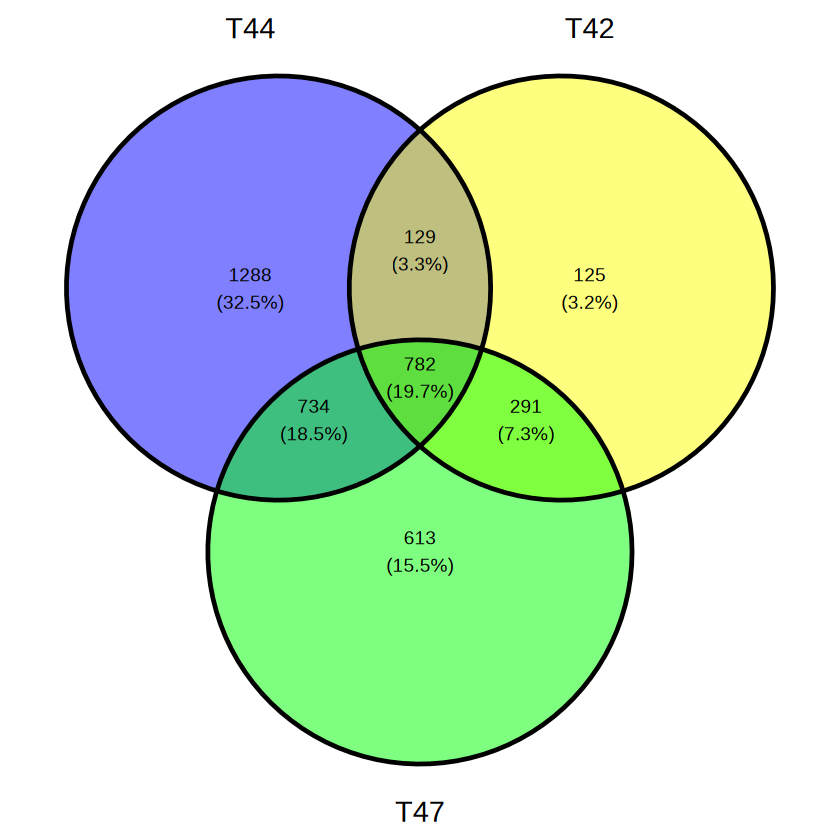

In [71]:
#total DTU stat
isosigst = NULL
for(i in c(1:6)){
    isosigt = isosigls[[i]]
    isosigt = isosigt[isosigt$sig != "N",]
    isosigt = unique(isosigt[,c("gene_id","areatr","dr")])
    isosigt$group = names(isosigls)[i]
    isosigst = rbind(isosigst,isosigt) 
}

isosigst.t42 = NULL
for(i in c(1:6)){
    isosigt = isosigls.t42[[i]]
    isosigt = isosigt[isosigt$sig != "N",]
    isosigt = unique(isosigt[,c("gene_id","areatr","dr")])
    isosigt$group = names(isosigls.t42)[i]
    isosigst.t42 = rbind(isosigst.t42,isosigt) 
}

isosigst.t47 = NULL
for(i in c(1:6)){
    isosigt = isosigls.t47[[i]]
    isosigt = isosigt[isosigt$sig != "N",]
    isosigt = unique(isosigt[,c("gene_id","areatr","dr")])
    isosigt$group = names(isosigls.t47)[i]
    isosigst.t47 = rbind(isosigst.t47,isosigt) 
}
ggvenn::ggvenn(list("T44" = isosigst$gene_id,
                    "T42" = isosigst.t42$gene_id,
                   "T47" = isosigst.t47$gene_id))

In [ ]:
isosigi = isosigls[[1]]
isosigi.t44 = isosigi[isosigi$sig != "N",]
isosigi = isosigls.t42[[1]]
isosigi.t42 = isosigi[isosigi$sig != "N",]
isosigi = isosigls.t47[[1]]
isosigi.t47 = isosigi[isosigi$sig != "N",]
ggvenn::ggvenn(list("T44" = isosigi.t44$gene_id,
                    "T42" = isosigi.t42$gene_id,
                   "T47" = isosigi.t47$gene_id))

In [76]:
gene_list <- unique(Reduce(intersect,list(isosigst$gene_id,isosigst.t42$gene_id,isosigst.t47$gene_id)))
length(gene_list)

[1] 782

In [ ]:
results_dft = NULL
batch = as.integer(length(gene_list)/10)
batch
for(i in 1:batch){
    if(10*batch[i] < length(gene_list)){
        gene_listi = gene_list[1 + 10*(batch[i]-1): 10*batch[i]]
    }else{
        gene_listi = gene_list[1 + 10*(batch[i]-1): length(gene_list)]
    }
    gene_disease_data <- gene2disease(
    gene = gene_listi,
      database = "CURATED",
      score = c(0.1, 1) 
    )
    print(batch[i])
    results_df <- gene_disease_data@qresult
    nrow(results_df)
    neuro_results <- results_df %>%
    filter(grepl(diseaseClasses_HPO,pattern = "nervous") | grepl(diseaseClasses_MSH,pattern = "Mental"))
    nrow(neuro_results)
    results_dft = rbind(results_dft,neuro_results)
}

qsave(results_dft,file = "result/figure6_snp_analysis/disgenet2r_gene_disease_annotation_neuron_filter_df.qs")

[1] 78

Warning message in gene2disease(gene = gene_listi, database = "CURATED", score = c(0.1, :
"Removing duplicates from input genes list."


In [ ]:
gene_neuro_score_max <- neuro_results %>%
  group_by(gene_symbol) %>%
  summarise(
    max_neuro_score = max(score, na.rm = TRUE),
    num_neuro_diseases = n_distinct(diseaseid) 
  ) %>%
  arrange(desc(max_neuro_score))

print(gene_neuro_score_max)

gene_neuro_score_avg <- neuro_results %>%
  group_by(gene_symbol) %>%
  summarise(
    avg_neuro_score = mean(score, na.rm = TRUE), 
    weighted_score = sum(score) / sqrt(n()),    
    num_neuro_diseases = n_distinct(diseaseid)
  ) %>%
  arrange(desc(weighted_score))

print(gene_neuro_score_avg)

In [ ]:

write.csv(gene_neuro_score_avg, "gene_neuro_disease_scores.csv", row.names = FALSE)


library(ggplot2)

ggplot(gene_neuro_score_avg, aes(x = reorder(gene_symbol, -weighted_score), y = weighted_score)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_text(aes(label = num_neuro_diseases), vjust = -0.5, size = 3) +
  labs(title = "基因与神经疾病关联强度评分",
       x = "基因",
       y = "加权关联分数",
       caption = "柱上数字表示关联的神经疾病数量") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Splicing factor correlation analysis

In [9]:
unique(refgdf$group)
#refgdf[refgdf$group == "SP",]
refsp = refgdf[refgdf$group %in% c("SP","RBP","TF"),]
length(unique(refsp$gene_id))
#unique(refsp$gene_id)

[1] "ASD"   "NDD"   "SCZ"   "BIP"   "EPI"   "DDD"   "hGPCR" "OPD"   "TF"   
[10] "RBP"   "SP"    "BD"

[1] 1754

In [ ]:

library(readxl)
library(dplyr)
library(purrr)

folder_path <- "/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ref/disease_gene/RBP_targeted/" 

file_list <- list.files(path = folder_path, 
                         pattern = "\\.xls$", 
                         full.names = TRUE)  

list_of_data <- map(file_list, read.table)
verified_df <- bind_rows(list_of_data)
head(verified_df)
colnames(verified_df) = unlist(verified_df[1,])
verified_df = verified_df[verified_df$RBP != "RBP",]
verified_df$paired = paste0(verified_df$geneName,"-",verified_df$RBP)
verified_df


Attaching package: 'purrr'


The following object is masked from 'package:XVector':

    compact


The following object is masked from 'package:GenomicRanges':

    reduce


The following object is masked from 'package:IRanges':

    reduce


The following object is masked from 'package:data.table':

    transpose




V1     V2              V3       V4             V5         V6        
1 RBP    geneID          geneName geneType       clusterNum clipExpNum
2 ALYREF ENSG00000186063 AIDA     protein_coding 2          1         
3 ATXN2  ENSG00000186063 AIDA     protein_coding 3          1         
4 CDK1   ENSG00000186063 AIDA     protein_coding 1          2         
5 CHTOP  ENSG00000186063 AIDA     protein_coding 3          3         
6 CNBP   ENSG00000186063 AIDA     protein_coding 1          1         
  V7        V8           V9          V10           V11          V12         
1 clipIDnum HepG2(shRNA) K562(shRNA) HepG2(CRIPSR) K562(CRIPSR) pancancerNum
2 2         NA           NA          NA            NA           20          
3 5         NA           NA          NA            NA           28          
4 2         NA           NA          NA            NA           21          
5 3         NA           NA          NA            0.155        19          
6 1         NA           NA          NA            NA           19

RBP       geneID          geneName geneType       clusterNum clipExpNum
2   ALYREF    ENSG00000186063 AIDA     protein_coding 2          1         
3   ATXN2     ENSG00000186063 AIDA     protein_coding 3          1         
4   CDK1      ENSG00000186063 AIDA     protein_coding 1          2         
5   CHTOP     ENSG00000186063 AIDA     protein_coding 3          3         
6   CNBP      ENSG00000186063 AIDA     protein_coding 1          1         
7   CPSF2     ENSG00000186063 AIDA     protein_coding 1          1         
8   CPSF7     ENSG00000186063 AIDA     protein_coding 1          1         
9   CSTF2     ENSG00000186063 AIDA     protein_coding 13         4         
10  CSTF2T    ENSG00000186063 AIDA     protein_coding 8          4         
11  DDX3X     ENSG00000186063 AIDA     protein_coding 1          9         
12  DDX54     ENSG00000186063 AIDA     protein_coding 3          4         
13  DHX36     ENSG00000186063 AIDA     protein_coding 4          3         
14  EIF3A     ENSG00000186063 AIDA     protein_coding 1          1         
15  EIF3B     ENSG00000186063 AIDA     protein_coding 1          1         
16  ELAVL1    ENSG00000186063 AIDA     protein_coding 28         19        
17  ELAVL3    ENSG00000186063 AIDA     protein_coding 2          6         
18  EWSR1     ENSG00000186063 AIDA     protein_coding 3          3         
19  FAM120A   ENSG00000186063 AIDA     protein_coding 1          3         
20  FUS       ENSG00000186063 AIDA     protein_coding 3          6         
21  FXR2      ENSG00000186063 AIDA     protein_coding 1          1         
22  G3BP1     ENSG00000186063 AIDA     protein_coding 3          3         
23  GEMIN5    ENSG00000186063 AIDA     protein_coding 1          1         
24  GRSF1     ENSG00000186063 AIDA     protein_coding 1          3         
25  GTF2F1    ENSG00000186063 AIDA     protein_coding 1          4         
26  HNRNPA2B1 ENSG00000186063 AIDA     protein_coding 4          2         
27  HNRNPC    ENSG00000186063 AIDA     protein_coding 5          7         
28  HNRNPD    ENSG00000186063 AIDA     protein_coding 1          1         
29  HNRNPH1   ENSG00000186063 AIDA     protein_coding 1          1         
30  HNRNPK    ENSG00000186063 AIDA     protein_coding 1          1         
31  HNRNPL    ENSG00000186063 AIDA     protein_coding 2          2         
⋮   ⋮         ⋮               ⋮        ⋮              ⋮          ⋮         
619 CPSF2     ENSG00000183785 TUBA8    protein_coding 1          1         
620 CSTF2     ENSG00000183785 TUBA8    protein_coding 1          1         
621 CSTF2T    ENSG00000183785 TUBA8    protein_coding 1          1         
622 DDX3X     ENSG00000183785 TUBA8    protein_coding 3          3         
623 EIF3A     ENSG00000183785 TUBA8    protein_coding 2          2         
624 ELAVL1    ENSG00000183785 TUBA8    protein_coding 3          3         
625 FIP1L1    ENSG00000183785 TUBA8    protein_coding 2          1         
626 FUS       ENSG00000183785 TUBA8    protein_coding 1          1         
627 HDLBP     ENSG00000183785 TUBA8    protein_coding 1          1         
628 HNRNPA2B1 ENSG00000183785 TUBA8    protein_coding 1          1         
629 IGF2BP1   ENSG00000183785 TUBA8    protein_coding 2          2         
630 IGF2BP2   ENSG00000183785 TUBA8    protein_coding 2          2         
631 IGF2BP3   ENSG00000183785 TUBA8    protein_coding 3          2         
632 MBNL1     ENSG00000183785 TUBA8    protein_coding 1          1         
633 MBNL2     ENSG00000183785 TUBA8    protein_coding 1          1         
634 MOV10     ENSG00000183785 TUBA8    protein_coding 1          1         
635 MSI1      ENSG00000183785 TUBA8    protein_coding 1          1         
636 PTBP1     ENSG00000183785 TUBA8    protein_coding 1          1         
637 RBM10     ENSG00000183785 TUBA8    protein_coding 1          1         
638 RBM15     ENSG00000183785 TUBA8    protein_coding 2          2         
639 RBM15B    ENSG00000183785 TUBA8    protein_codin

In [61]:
#load ngs count
ngscount = qread("data/gene_mx_total/spatial_genecount_ngs_combined_genecount_25_10_15.qs")
head(ngscount)
ngscount.bl = ngscount %>% group_by(subcortical,layer,lobe,region,blockid,gene_id) %>% summarise(genecount = sum(genecount))
ngscount.cl = ngscount %>% group_by(subcortical,layer,lobe,region,class,subclass,gene_id) %>% summarise(genecount = sum(genecount))
head(ngscount.bl)
ngscount.cl$metacell = paste0(ngscount.cl$layer,"-",ngscount.cl$region,"-",ngscount.cl$lobe,"-",
                             ngscount.cl$subcortical,"-",ngscount.cl$class,"-",ngscount.cl$subclass)
ngscount.bl$metacell = paste0(ngscount.bl$layer,"-",ngscount.bl$region,"-",ngscount.bl$lobe,"-",
                              ngscount.bl$subcortical,"-",ngscount.bl$blockid)

layer lobe region subcortical blockid     class subclass gene_id genecount
1 HC    NA   CA1    Hippocampus 26600_82600                AARSD1  1        
2 HC    NA   CA1    Hippocampus 26600_82600                ACAA1   1        
3 HC    NA   CA1    Hippocampus 26600_82600                ACHE    1        
4 HC    NA   CA1    Hippocampus 26600_82600                ACP1    1        
5 HC    NA   CA1    Hippocampus 26600_82600                ACP6    1        
6 HC    NA   CA1    Hippocampus 26600_82600                ACTB    2        
  metacell                           
1 HC-CA1-NA-Hippocampus-26600_82600--
2 HC-CA1-NA-Hippocampus-26600_82600--
3 HC-CA1-NA-Hippocampus-26600_82600--
4 HC-CA1-NA-Hippocampus-26600_82600--
5 HC-CA1-NA-Hippocampus-26600_82600--
6 HC-CA1-NA-Hippocampus-26600_82600--

`summarise()` has grouped output by 'subcortical', 'layer', 'lobe', 'region',
'blockid'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'subcortical', 'layer', 'lobe', 'region',
'class', 'subclass'. You can override using the `.groups` argument.


subcortical layer lobe region blockid     gene_id genecount
1 Cerebellum  cb    NA   cb     15400_87400 AAK1     3       
2 Cerebellum  cb    NA   cb     15400_87400 ABCA1    3       
3 Cerebellum  cb    NA   cb     15400_87400 ABCB1    3       
4 Cerebellum  cb    NA   cb     15400_87400 ABHD12   3       
5 Cerebellum  cb    NA   cb     15400_87400 ABLIM3   3       
6 Cerebellum  cb    NA   cb     15400_87400 ACADS   12

In [62]:
ngscount.bl$metacell = paste0(ngscount.bl$layer,"-",ngscount.bl$region,"-",ngscount.bl$lobe,"-",
                              ngscount.bl$subcortical,"-",ngscount.bl$blockid)
ngscount.cl$metacell = paste0(ngscount.cl$layer,"-",ngscount.cl$region,"-",ngscount.cl$lobe,"-",
                             ngscount.cl$subcortical,"-",ngscount.cl$class,"-",ngscount.cl$subclass)

In [201]:
qsave(list("block" = ngscount.bl,"celltype" = ngscount.cl),
      file = "result/figure_revision/ngscount_bin200_genemx_25_10_21.qs")

In [22]:
#normalize by seurat
NormGenecount = function(ngscount.cl){
    genemx = dcast(ngscount.cl,gene_id~metacell,value.var = "genecount",fun.aggregate = sum)
    genemx = genemx[!is.na(genemx$gene_id),]
    gene_names = genemx$gene_id
    rownames(genemx) = genemx$gene_id;genemx = genemx[,-1]
    genemx_norm <- as.matrix(genemx)
    scale_factor <- 10000
    genemx_norm <- log1p(t(t(genemx_norm) / colSums(genemx_norm)) * scale_factor)
    genemx_norm = as.data.frame(genemx_norm)
    #genemx_norm <- data.frame(gene_id = gene_names, genemx_norm)
    colnames(genemx_norm) <- colnames(genemx) 
    return(genemx_norm)
}

# genemx.cl = NormGenecount(ngscount.cl)
# genemx.bl = NormGenecount(ngscount.bl)
# qsave(list("block" = genemx.bl,"celltype" = genemx.bl),
#       file = "result/figure_revision/SF_DTU_cor_analysis_bin200_genemx_25_10_21.qs")
# head(genemx.cl)

In [23]:
ngscount.bl = qread("result/figure_revision/ngscount_bin200_genemx_25_10_21.qs")$block
ngscount.bl$metacell = paste0(ngscount.bl$layer,"-",ngscount.bl$region,"-",ngscount.bl$lobe,"-",
                              ngscount.bl$subcortical,"-",ngscount.bl$blockid)
genemx.bl = NormGenecount(ngscount.bl)
#genemx.cl.hub = genemx.cl[rownames(genemx.cl) %in% refsp$gene_id,]
genemx.bl.hub = genemx.bl[rownames(genemx.bl) %in% refsp$gene_id,]
#genemx.cl.hub = t(genemx.cl.hub)
genemx.bl.hub = t(genemx.bl.hub)

In [54]:
qsave(genemx.bl.hub,"result/figure_revision/ngscount_bin200_genemx_RBP_25_12_12.qs")

In [145]:
#build bin 200 dtu data to detect SF/RBP
#for cortext celltype
ra = 200
fsraw.cor$xid = as.integer(fsraw.cor$x/(ra*2)) * ra * 2 + ra
fsraw.cor$yid = as.integer(fsraw.cor$y/(ra*2)) * ra * 2 + ra
fsraw.cor$blockid = paste0(fsraw.cor$xid,"_",fsraw.cor$yid)
transtl.bl = fsraw.cor %>% group_by(layer,lobe,region,blockid,subcortical,gene_id) %>% 
        mutate(genecount = length(unique(readid))) %>% 
        group_by(gene_id,transcript_id,layer,lobe,region,blockid,subcortical) %>% 
        summarise(count = length(unique(readid)),
                  genecount = unique(genecount))
transtl.bl$metacell = paste0(transtl.bl$layer,"-",transtl.bl$region,"-",transtl.bl$lobe,"-",transtl.bl$subcortical,"-",transtl.bl$blockid)
transtl.bl$relative = transtl.bl$count/transtl.bl$genecount

# transtl.cl = fsraw.cor %>% group_by(layer,subclass,subcortical,gene_id) %>% 
#         mutate(genecount = length(unique(readid))) %>% 
#         group_by(gene_id,transcript_id,layer,subclass,subcortical) %>% 
#         summarise(count = length(unique(readid)),
#                   genecount = unique(genecount))
# transtl.cl$metacell = paste0(transtl.cl$layer,"-",transtl.cl$subcortical,"-",transtl.cl$subclass)
# transtl.cl$relative = transtl.cl$count/transtl.cl$genecount

transtl.cl = fsraw.cor %>% group_by(layer,lobe,region,subcortical,class,subclass,gene_id) %>% 
        mutate(genecount = length(unique(readid))) %>% 
        group_by(gene_id,transcript_id,layer,lobe,region,class,subclass,subcortical) %>% 
        summarise(count = length(unique(readid)),
                  genecount = unique(genecount))
transtl.cl$metacell = paste0(transtl.cl$layer,"-",transtl.cl$region,"-",transtl.cl$lobe,"-",
                             transtl.cl$subcortical,"-",transtl.cl$class,"-",transtl.cl$subclass)
transtl.cl$relative = transtl.cl$count/transtl.cl$genecount
qsave(list("block" = transtl.bl,"cell" = transtl.cl),file = "data/spatial_isoform_ratio_fs_bin200_metacell_25_12_11.qs")
# transtf = transtl %>% group_by(transcript_id) %>% 
#        filter(length(unique(areatr)) > 1)


`summarise()` has grouped output by 'gene_id', 'transcript_id', 'layer',
'lobe', 'region', 'class', 'subclass'. You can override using the `.groups`
argument.


In [57]:
# transtls = qread(file = "data/spatial_isoform_ratio_fs_bin200_metacell_25_12_11.qs")
# transtl.bl = transtls$block
# head(transtl.bl)
# alldtu = NULL
# for(i in 1:6){
#     isosigi = isosigls[[i]]
#     isosigi.hub = isosigi[isosigi$sig != "N",]
#     alldtu = unique(c(isosigi.hub$transcript_id,alldtu))
# }
# length(alldtu)
# nrow(transtl.bl)
# transtl.bl = transtl.bl[transtl.bl$transcript_id %in% alldtu,]
# nrow(transtl.bl)
# transtl.bl.st = transtl.bl %>% group_by(transcript_id) %>% summarise(metan = length(unique(metacell)))
# summary(transtl.bl.st$metan)
transtl.bl.st = transtl.bl.st[transtl.bl.st$metan > 1000,]
nrow(transtl.bl.st)
transtl.bl = transtl.bl[transtl.bl$transcript_id %in% transtl.bl.st$transcript_id,]
# isosigi = isosigi %>% group_by(gene_id) %>% filter(mean(genecount[!duplicated(areatr)]) > 300)
# isosigi.hub = isosigi[isosigi$transcript_id %in% isosigi.hub$transcript_id,]
# length(unique(isosigi.hub$gene_id))
# unique(isosigi.hub$gene_id)
# fsraw.cor.hub = fsraw.cor[fsraw.cor$gene_id %in% isosigi.hub$gene_id,]
qsave(transtl.bl,file = "data/spatial_isoform_ratio_fs_bin200_metacell_filter_25_12_11.qs")

[1] 1920

In [ ]:
qsave(genemx.bl.hub,"result/figure_revision/ngscount_bin200_genemx_RBP_25_12_12.qs")
qsave(transtl.bl,file = "data/spatial_isoform_ratio_fs_bin200_metacell_filter_25_12_11.qs")

In [25]:
options(dplyr.summarise.inform = FALSE)
MakeTFCor = function(transtl,genemx.hub){
    genemx.hub <- data.frame(
      metacell = rownames(genemx.hub),
      genemx.hub,
      stringsAsFactors = FALSE,
      check.names = FALSE
    )
    metacelln = length(unique(transtl$metacell))
    transtl = transtl %>% group_by(transcript_id) %>% filter(length(metacell) > metacelln/4)
    cmpdf = merge(transtl[,c("gene_id","transcript_id","metacell","relative")], genemx.hub,by = "metacell")
    metacelln = length(unique(cmpdf$metacell))
    cordf = NULL
    for(i in 1:(ncol(genemx.hub) - 1)){
        cmpdfi = cmpdf[,c(1:4,i+4)]
        genei = colnames(cmpdfi)[5]
        colnames(cmpdfi)[5] = "SF"
        cmpdfi = cmpdfi[!is.na(cmpdfi$SF) & !is.na(cmpdfi$relative),]
        cmpdfi = cmpdfi[!is.nan(cmpdfi$SF) & !is.nan(cmpdfi$relative),]
        cmpdfi = cmpdfi %>% group_by(gene_id,transcript_id) %>% 
                        filter(sum(SF != 0) > 10 & sum(relative != 0) > 10)
        if(nrow(cmpdfi) == 0) next;
        cordfi = cmpdfi %>% group_by(gene_id,transcript_id) %>% 
                        filter(length(unique(metacell)) > metacelln/4) %>% 
                        summarise(cor = cor(relative,SF),
                                  pvalue = cor.test(relative,SF)$p.value)
        cordfi$SF = genei
        cordf = rbind(cordf,cordfi)
    }
    return(cordf)
}

cordf.bl = MakeTFCor(transtl.bl,genemx.bl.hub)
nrow(cordf.bl)
#cordf.cl = MakeTFCor(transtl.cl,genemx.cl.hub)
#summary(cordf.cl$cor)
#cordfls = list("celltype" = cordf.cl,"block" = cordf.bl)
qsave(cordf.bl,file = "result/figure_revision/SF_DTU_cor_analysis_bin200_celltype_25_12_11.qs")

[1] 483061

In [301]:
cordfls = qread("result/figure_revision/SF_DTU_cor_analysis_bin200_celltype_25_10_17.qs")

In [302]:
FilterCordf = function(cordf){
    cordf$padj = p.adjust(cordf$pvalue)
    cordf = cordf[!is.na(cordf$cor),]
    cordf.fil = cordf[cordf$padj < 0.05,]
    cordf.fil = cordf[cordf$transcript_id %in% cordf.fil$transcript_id &
                      cordf$SF %in% cordf.fil$SF,]
    # cordf.fil = cordf.fil %>% group_by(gene_id,SF) %>% filter(sum(cor > 0) > 0 & sum(cor < 0) > 0)
    # cordf.fil = cordf[cordf$transcript_id %in% cordf.fil$transcript_id &
    #                   cordf$SF %in% cordf.fil$SF,]
    
    #nrow(cordf.fil)
    cordf.fil = cordf.fil %>% group_by(SF) %>% filter(max(abs(cor)) > 0.25)
    cordf.fil = cordf.fil %>% group_by(gene_id) %>% filter(max(abs(cor)) > 0.25)
    cordf.fil = cordf.fil %>% group_by(SF,gene_id,transcript_id) %>% mutate(maxcor = max(abs(cor)))
    cordf.fil = cordf.fil %>% group_by(SF,gene_id) %>% filter(max(abs(cor)) == maxcor)
    return(cordf.fil)
}
# cordf.cl = cordfls$celltype
# cordf.bl = cordfls$block
# cordf.cl.fil = FilterCordf(cordf.cl)
# head(cordf.cl.fil)
cordf.bl.fil = FilterCordf(cordf.bl)
nrow(cordf.bl.fil)
#library(ggvenn)
#ggvenn(list("bl" = cordf.bl.fil$SF,"cl" = cordf.cl.fil$SF))

[1] 128

In [303]:
cordf.bl$padj = p.adjust(cordf.bl$pvalue)
nrow(cordf.bl[cordf.bl$padj < 0.05,])
nrow(cordf.bl.fil)

[1] 15123

[1] 128

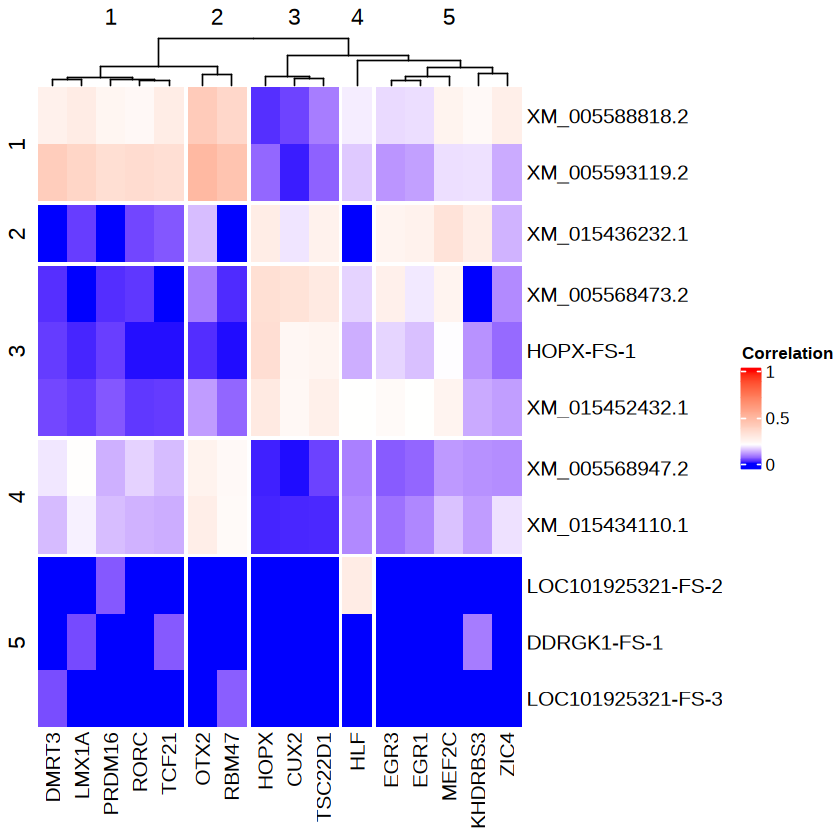

In [ ]:
library(ComplexHeatmap)
library(circlize)
cordf.fil = cordf.bl.fil

all_vars <- unique(c(cordf.fil$gene_id, cordf.fil$SF))


mat_cor = dcast(cordf.fil,transcript_id~SF,value.var = "cor",fun.aggregate = sum)
rownames(mat_cor) = mat_cor$transcript_id;mat_cor = mat_cor[,-1]
mat_cor = as.matrix(mat_cor)

mat_p = dcast(cordf.fil,transcript_id~SF,value.var = "padj",fun.aggregate = mean,fill = 1)
rownames(mat_p) = mat_p$transcript_id;mat_p = mat_p[,-1]
mat_p = as.matrix(mat_p)


col_fun <- colorRamp2(c(-1, 0, 1), c("blue", "white", "red"))


pt = Heatmap(mat_cor, 
        name = "Correlation", 
        col = col_fun,
        show_row_dend = FALSE,column_split = 8,row_split = 5, 

        cluster_rows = TRUE,
        cluster_columns = TRUE,
        show_row_names = TRUE,
        show_column_names = TRUE,
        heatmap_legend_param = list(title = "Correlation"))
#dev.off()
col_fun <- colorRamp2(c(0, 0.2, 1), c("blue", "white", "red"))
pt = Heatmap(abs(mat_cor), 
        name = "Correlation", 
        col = col_fun,
        show_row_dend = FALSE,column_split = 5,row_split = 5,
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        show_row_names = TRUE,
        show_column_names = TRUE,
        heatmap_legend_param = list(title = "Correlation"))
print(pt)

In [297]:
head(transtl.bl)
ggplot(transtl.case[transtl.case$gene_id == "RCAN2",],x = transcript_id,y = relative)

gene_id transcript_id  layer lobe region blockid     subcortical count
1 A4GALT  XM_015457101.1 HC    NA   proS   26000_83600 Hippocampus 1    
2 A4GALT  XM_015457101.1 cb    NA   cb     17200_90000 Cerebellum  1    
3 A4GALT  XM_015457101.1 cb    NA   cb     23600_91600 Cerebellum  2    
4 A4GALT  XM_015457101.1 cb    NA   cb     24400_98000 Cerebellum  1    
5 A4GALT  XM_015457101.1 cb    NA   cb     26000_94000 Cerebellum  4    
6 A4GALT  XM_015457101.1 cb    NA   cb     28400_93200 Cerebellum  1    
  genecount metacell                           relative
1 1         HC-proS-NA-Hippocampus-26000_83600 1       
2 1         cb-cb-NA-Cerebellum-17200_90000    1       
3 2         cb-cb-NA-Cerebellum-23600_91600    1       
4 1         cb-cb-NA-Cerebellum-24400_98000    1       
5 4         cb-cb-NA-Cerebellum-26000_94000    1       
6 1         cb-cb-NA-Cerebellum-28400_93200    1

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the ele

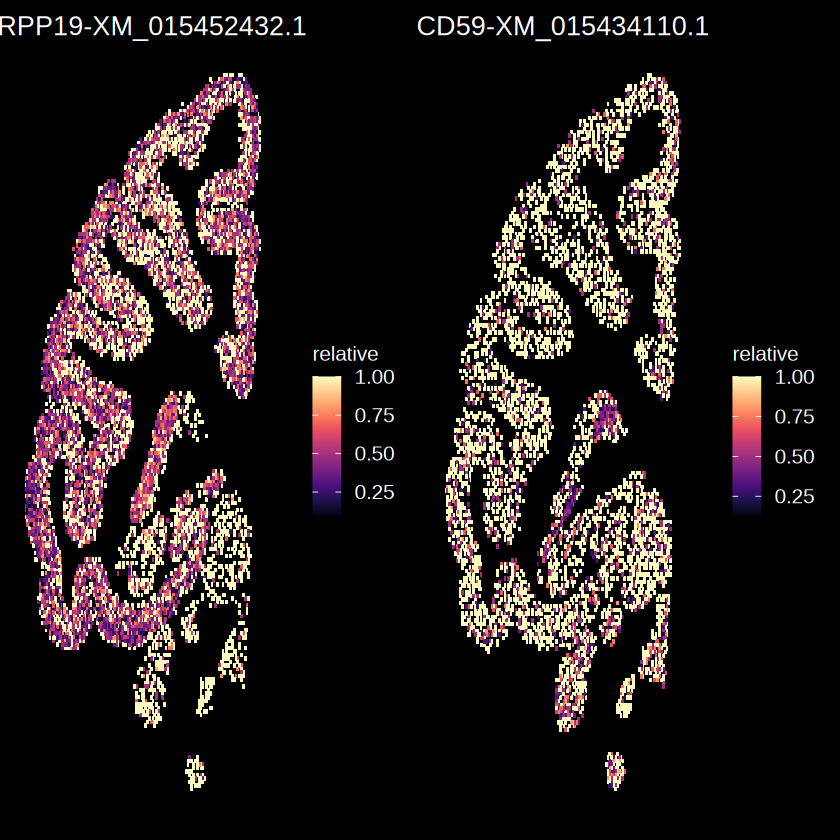

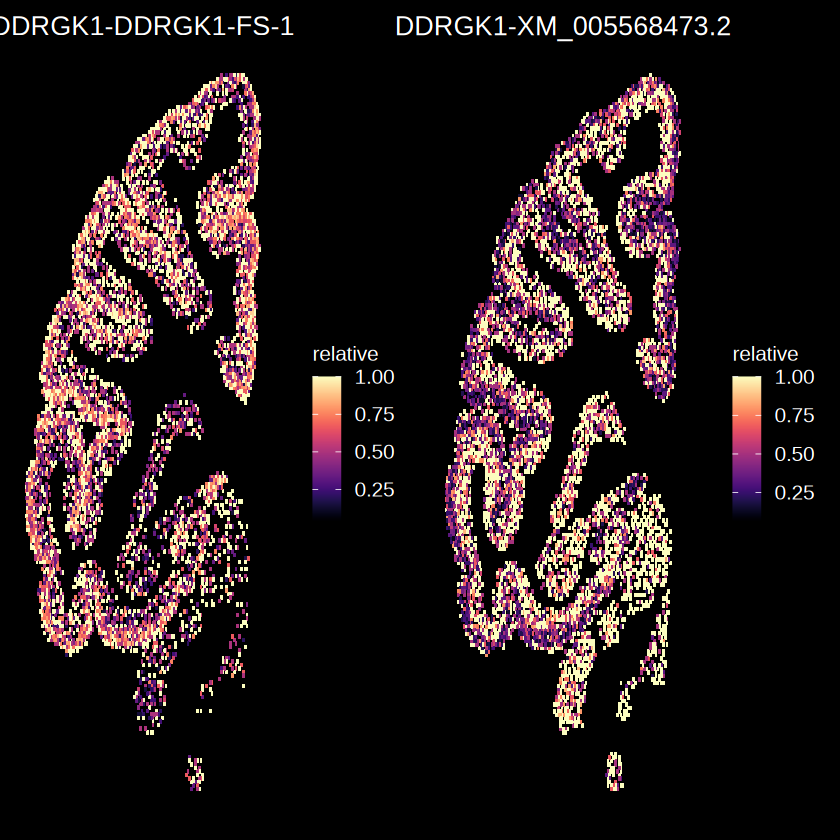

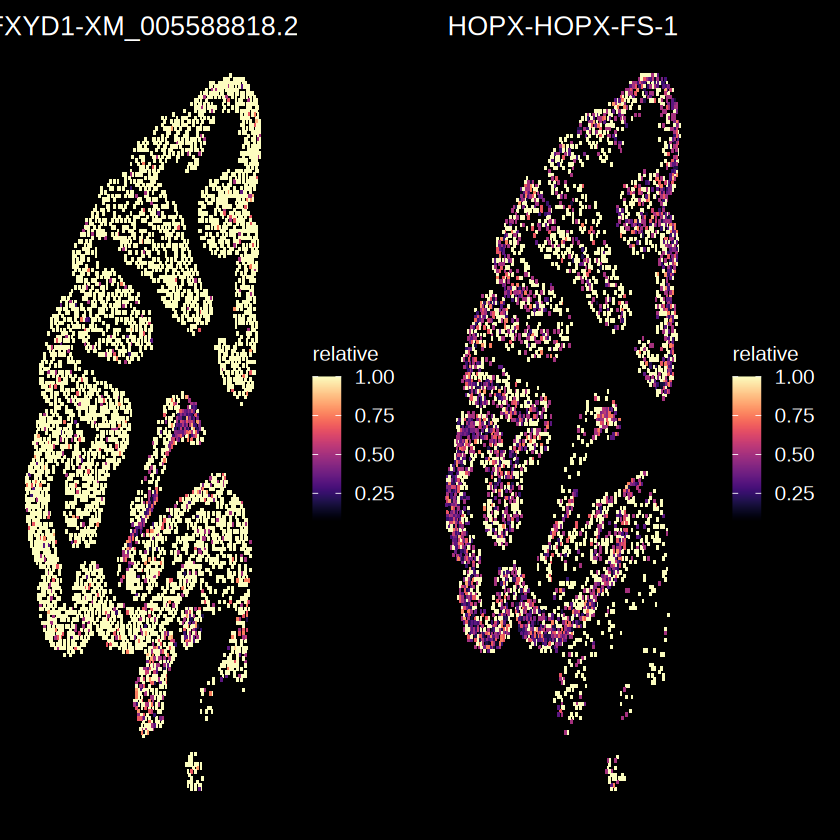

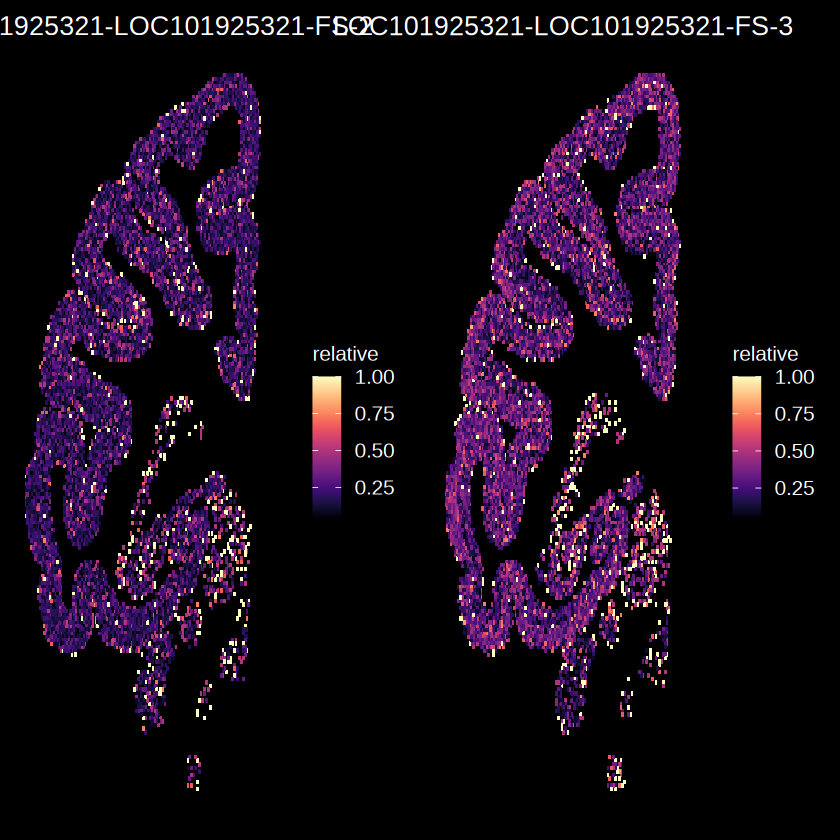

$`1`

$`2`

$`3`

$`4`

$`5`

$`6`

attr(,"class")
[1] "list"      "ggarrange"

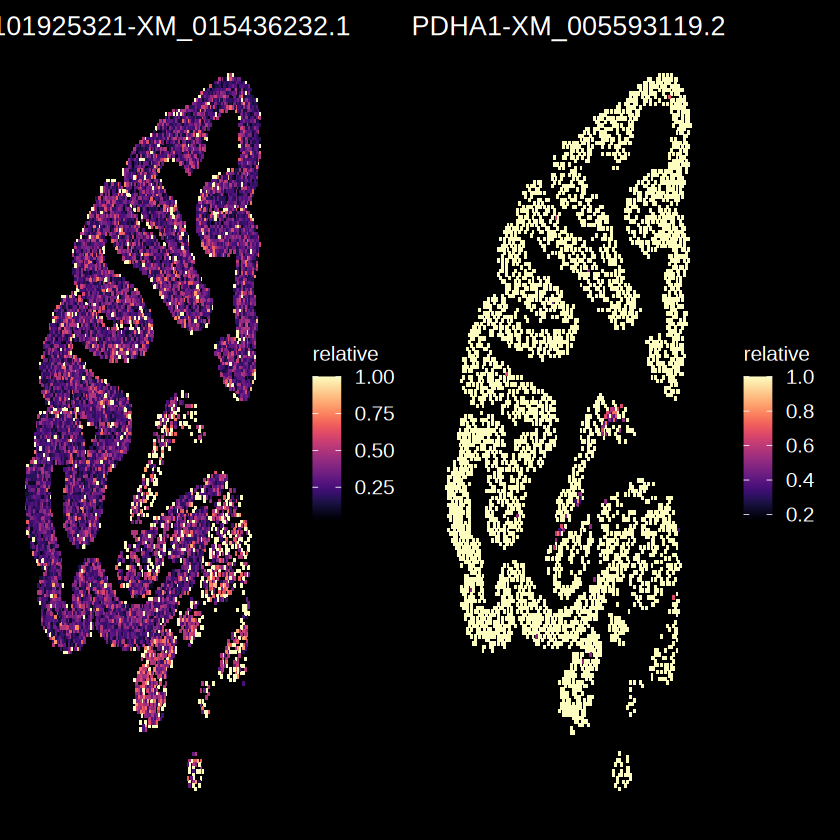

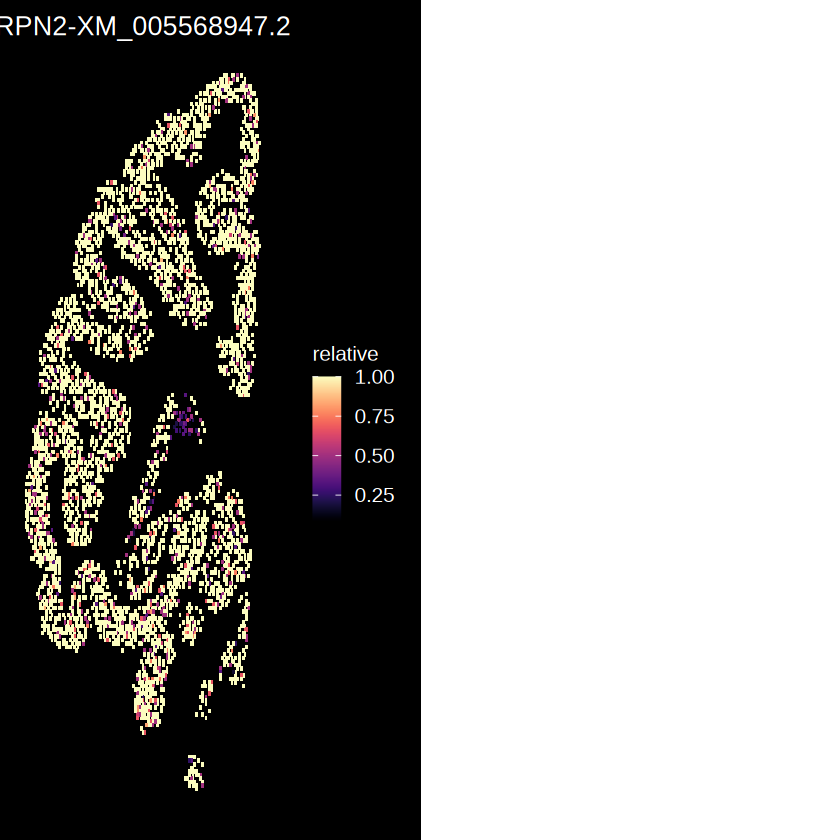

In [306]:
transtl.case = transtl.bl[transtl.bl$transcript_id %in% cordf.fil[cordf.fil$gene_id %in% c("DDRGK1","ARPP19","SEPT11","RCAN2"),]$transcript_id,]
transtl.case = transtl.bl[transtl.bl$transcript_id %in% cordf.fil$transcript_id,]

transtl.case$name = paste0(transtl.case$gene_id,"-",transtl.case$transcript_id)
#transtl.case = merge(transtl.case,moduledf,by = "name")
transtl.case$x = as.numeric(MySplit(transtl.case$blockid,"_",1))
transtl.case$y = as.numeric(MySplit(transtl.case$blockid,"_",2))
#transtl.case = transtl.case[order(transtl.case$module),]
caseid = unique(transtl.case$name)
pcasels1 = list()
for(i in 1:length(caseid)){
    pi = ggplot(transtl.case[transtl.case$name == caseid[i],],aes(x = x,y = y,fill = relative)) + 
                        geom_tile() + scale_fill_viridis(option = "A") + 
                        theme_presentation() + 
                        scale_x_reverse() + scale_y_reverse() + 
                        ggtitle(caseid[i])
    pcasels1[[i]] = pi
}
pcaset1 = ggarrange(plotlist = pcasels1,ncol = 2)
pcaset1

In [307]:
#selcet dominant isoform
isosigi = isosigls$layer
#isosigi.hub = isosigi[isosigi$sig != "N",]
#isosigi.hub[isosigi.hub$gene_id == "ARPP19",]
isosigi.fil = isosigi %>% group_by(gene_id) %>% filter(abs(dr) == max(abs(dr)))

In [ ]:

library(dplyr)
library(igraph)
library(ggraph)
library(tidygraph)


cordf.fil = cordf.bl.fil
cordf.fil$dtu = paste0(cordf.fil$gene_id,"-",cordf.fil$transcript_id)
cordf.fil$corv = abs(cordf.fil$cor)
#cordf.fil = cordf.fil %>% group_by(gene_id) %>% mutate(transnum = length(unique(transcript_id)))
cordf.fil = cordf.fil[cordf.fil$gene_id != cordf.fil$SF,]
#cordf.fil = cordf.fil[cordf.fil$transnum == 1 | cordf.fil$transcript_id %in% isosigi.fil$transcript_id,]
network_edges <- cordf.fil[,c("dtu","SF","corv","cor","padj")] %>%
  filter(padj < 0.05 & abs(cor) > 0.25) %>% 
  select(from = SF, to = dtu, weight = cor) 
#network_edges


g <- graph_from_data_frame(network_edges, directed = TRUE)

E(g)$width <- abs(E(g)$weight) * 2 
E(g)$color <- ifelse(E(g)$weight > 0, "red", "blue") 
E(g)$weight <- abs(E(g)$weight)
summary(g)


cluster_fast_greedy <- cluster_fast_greedy(as.undirected(g)) 
membership_fg <- membership(cluster_fast_greedy)

cluster_walktrap <- cluster_edge_betweenness(g)
membership_wt <- membership(cluster_walktrap)
#cluster_walktrap <- cluster_leiden(as.undirected(g), objective_function = "modularity")


V(g)$module <- as.character(membership_fg) 

g_tidy <- as_tbl_graph(g)


Attaching package: 'igraph'


The following object is masked from 'package:vegan':

    diversity


The following object is masked from 'package:permute':

    permute


The following objects are masked from 'package:lubridate':

    %--%, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:tibble':

    as_data_frame


The following object is masked from 'package:Seurat':

    components


The following object is masked from 'package:BiocIO':

    path


The following object is masked from 'package:Biostrings':

    union


The following object is masked from 'package:XVector':

    path


The following object is masked from 'package:khroma':

    compare


The following object is masked from 'package:circlize':

    degree


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects

IGRAPH cc0ae7f DNW- 24 27 -- 
+ attr: name (v/c), weight (e/n), width (e/n), color (e/c)


Warning message in cluster_edge_betweenness(g):
"At core/community/edge_betweenness.c:492 : Membership vector will be selected based on the highest modularity score."


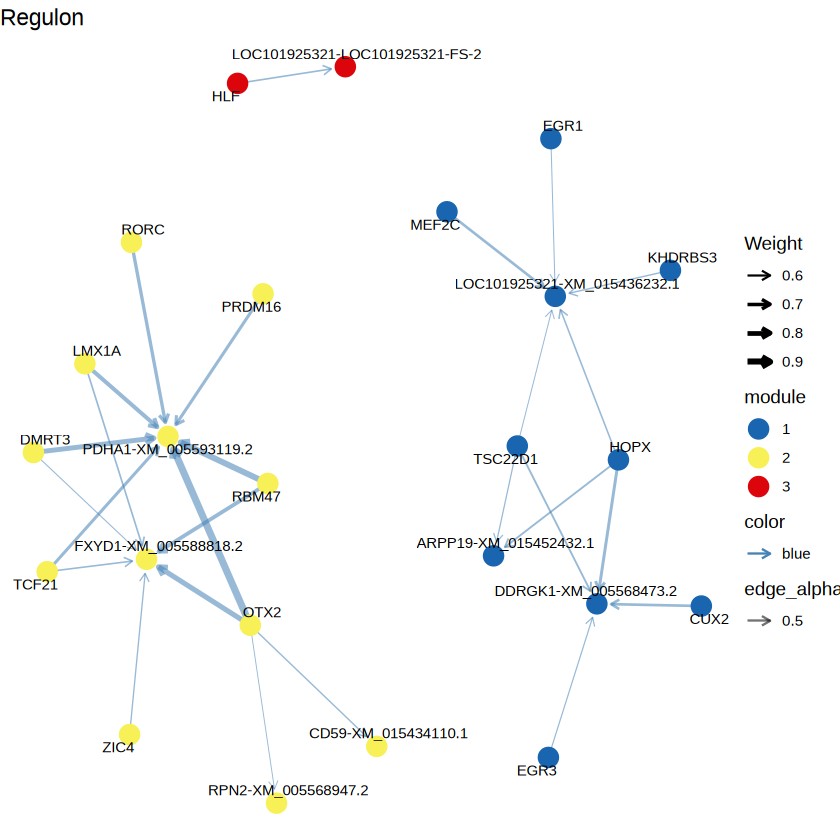

In [ ]:
pg = ggraph(g_tidy, layout = "fr") +
  geom_edge_link(aes(edge_width = width, edge_color = color, alpha = 0.5),
                 arrow = arrow(length = unit(2, 'mm')), 
                 end_cap = circle(3, 'mm')) +
  scale_edge_width_continuous(range = c(0.2, 1.5)) +
  scale_edge_color_manual(values = c("red" = "tomato", "blue" = "steelblue")) +
  geom_node_point(aes(color = module), size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3) + 
  scale_color_discreterainbow() +
  theme_void() +
  labs(title = "Regulon",
       edge_width = "Weight")
pg

In [ ]:
set.seed(123) 
#E(g)$weight <- abs(E(g)$weight)
#g_tidy <- as_tbl_graph(g)
pg = ggraph(g_tidy, layout = "fr") + 
  geom_edge_link(aes(edge_width = width, edge_color = color, alpha = 0.5),
                 arrow = arrow(length = unit(2, 'mm')), 
                 end_cap = circle(3, 'mm')) +
  scale_edge_width_continuous(range = c(0.2, 1.5)) +
  scale_edge_color_manual(values = c("red" = "tomato", "blue" = "steelblue")) +
  geom_node_point(aes(color = module), size = 5) + 
  geom_node_text(aes(label = name), repel = TRUE, size = 3) + 
  scale_color_discreterainbow() +
  theme_void() +
  labs(title = "Regulon",
       edge_width = "Weight")
pg
ggexport(pg,filename = "result/figure_revision/regulon_bin200_network_graph_fil_25_10_20.pdf",width = 10,height = 10)

#plot no text
pgn = ggraph(g_tidy, layout = "fr") + 
  geom_edge_link(aes(edge_width = width, edge_color = color, alpha = 0.5),
                 arrow = arrow(length = unit(2, 'mm')), 
                 end_cap = circle(3, 'mm')) +
  scale_edge_width_continuous(range = c(0.2, 1.5)) +
  scale_edge_color_manual(values = c("red" = "tomato", "blue" = "steelblue")) +
  geom_node_point(aes(color = module), size = 5) + 
  scale_color_discreterainbow() +
  theme_void() +
  labs(title = "Regulon",
       edge_width = "Weight")
pgn
ggexport(pgn,filename = "result/figure_revision/regulon_bin200_network_graph_notext_fil_25_12_11.pdf",
         width = 10,height = 10)


In [310]:
moduledf = as.data.frame(g_tidy)
qsave(g_tidy,file = "result/figure_revision/regulon_bin200_network_fil_12_19.qs")

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to result/figure_revision/regulon_bin400_network_graph_isoform_ratio_cases_25_12_19.p

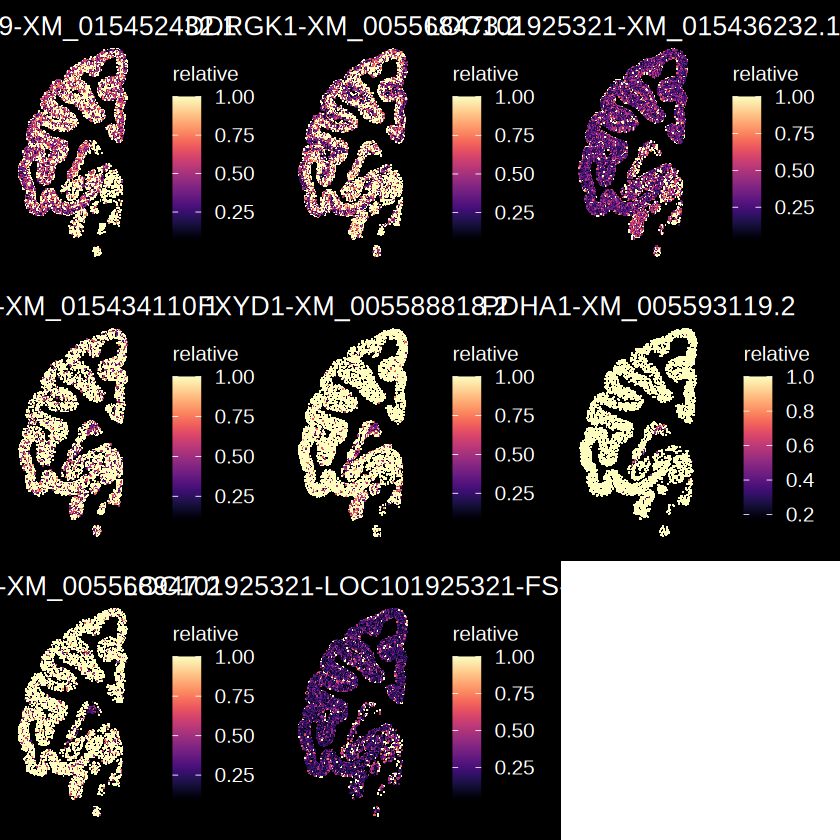

In [311]:
transtl.case = transtl.bl
transtl.case$name = paste0(transtl.case$gene_id,"-",transtl.case$transcript_id)
transtl.case = merge(transtl.case,moduledf,by = "name")
transtl.case$x = as.numeric(MySplit(transtl.case$blockid,"_",1))
transtl.case$y = as.numeric(MySplit(transtl.case$blockid,"_",2))
transtl.case = transtl.case[order(transtl.case$module),]
caseid = unique(transtl.case$name)
pcasels1 = list()
for(i in 1:length(caseid)){
    pi = ggplot(transtl.case[transtl.case$name == caseid[i],],aes(x = x,y = y,fill = relative)) + 
                        geom_tile() + scale_fill_viridis(option = "A") + 
                        theme_presentation() + 
                        scale_x_reverse() + scale_y_reverse() + 
                        ggtitle(caseid[i])
    pcasels1[[i]] = pi
}
pcaset1 = ggarrange(plotlist = pcasels1,nrow = 3,ncol = 3)
pcaset1
ggexport(pcaset1,filename = "result/figure_revision/regulon_bin400_network_graph_isoform_ratio_cases_25_12_19.pdf",
         width = 9,height = 10)

[1] 24

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the ele

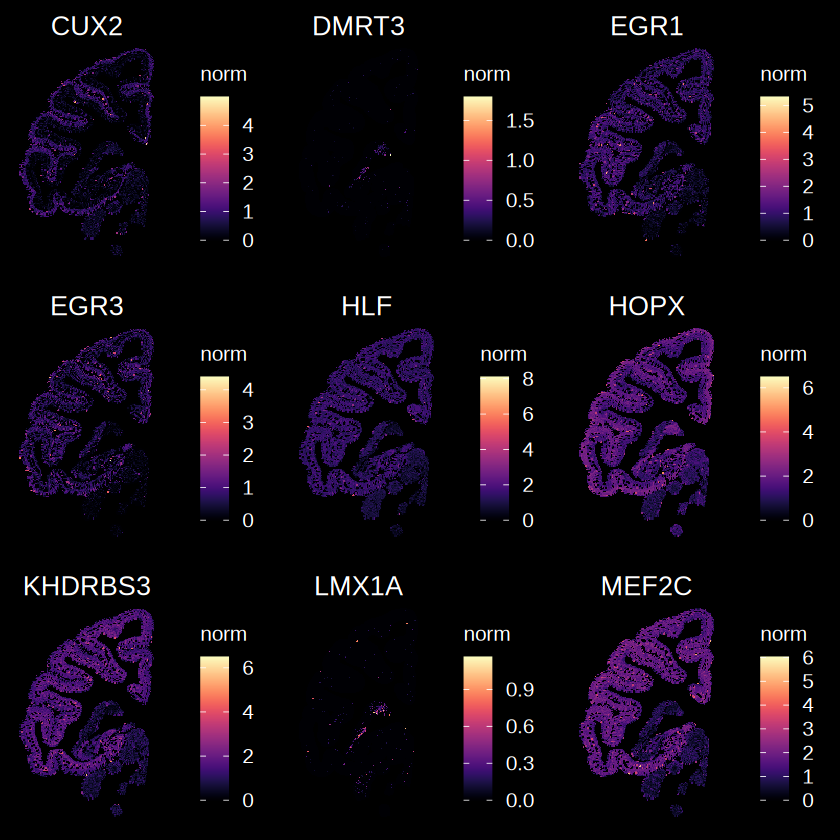

$`1`

$`2`

$`3`

attr(,"class")
[1] "list"      "ggarrange"

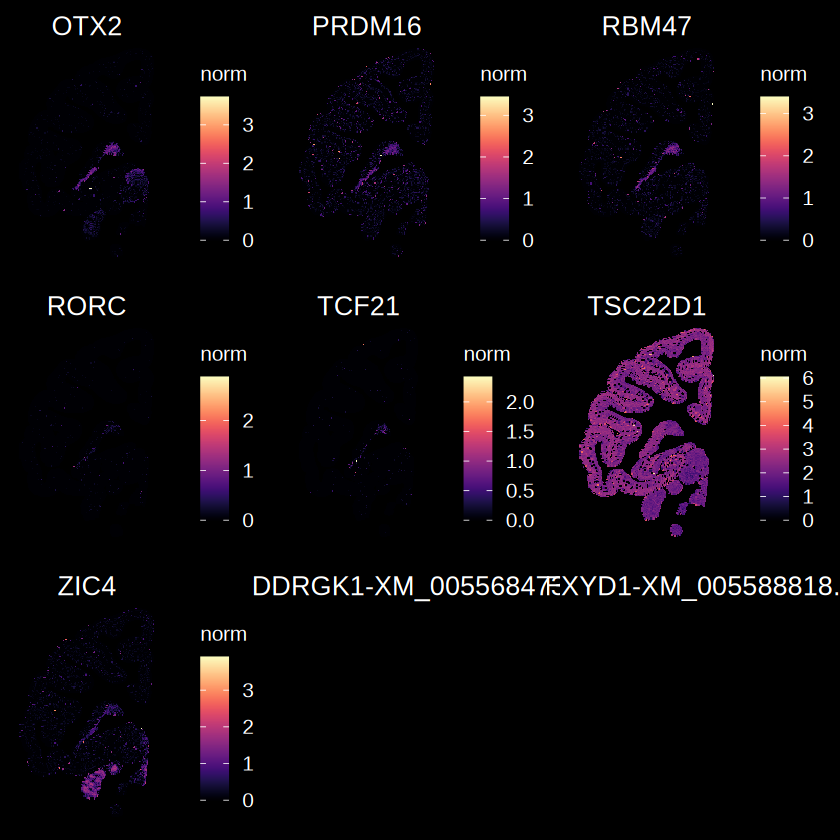

file saved to result/figure_revision/regulon_bin200_network_graph_gene_norm_cases_25_12_19.pdf



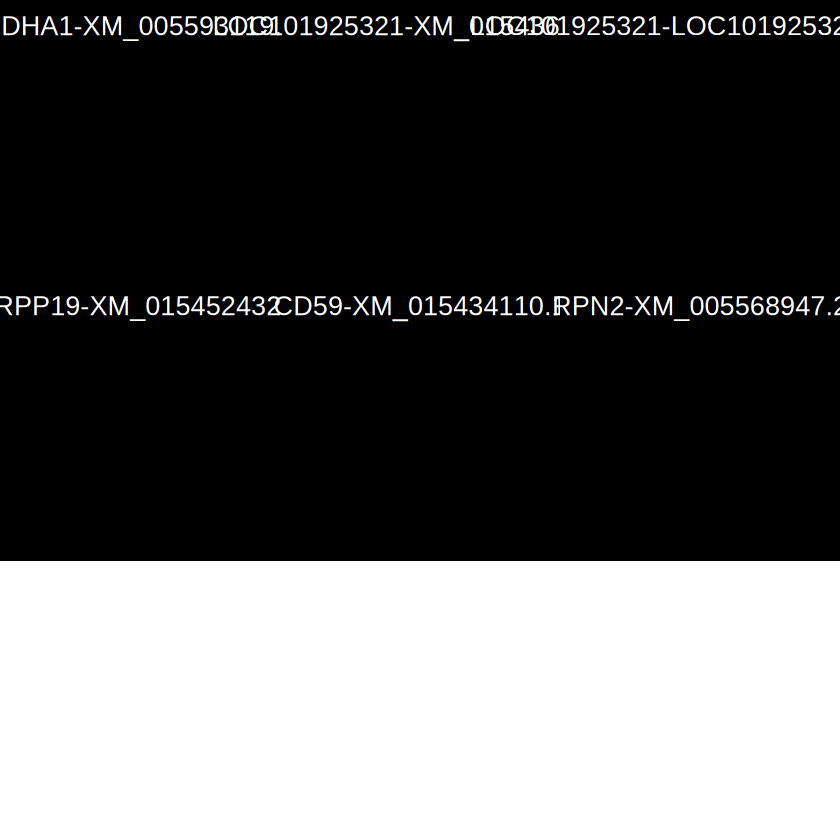

In [318]:
#show case plot
# genedf = melt(genemx.bl.hub)
# head(genedf)
# colnames(genedf) = c("Metacell","gene_id","norm")
# genedf$Metacell = as.character(genedf$Metacell)
# genedf$gene_id = as.character(genedf$gene_id)
# genedf$coord = MySplit(genedf$Metacell,"-",5)
# genedf = merge(genedf,moduledf,by.x = "gene_id",by.y = "name")
# genedf[genedf$module == "1",]
# genedf = genedf %>% group_by(coord,module) %>% summarise(norm = mean(norm))
# genedf = genedf[!is.na(genedf$norm),]
# genedf$x = as.numeric(MySplit(genedf$coord,"_",1))
# genedf$y = as.numeric(MySplit(genedf$coord,"_",2))
# head(genedf)
# ggplot(genedf,aes(x = x,y = y,fill = norm)) + geom_tile() + scale_fill_viridis(option = "A") + theme_presentation() + 
#                         scale_x_reverse() + scale_y_reverse() + facet_wrap(~module)
# moduleid = unique(genedf$module)
geneids = unique(moduledf$name)
pcasels = list()
length(geneids)
for(i in 1:length(geneids)){
    pi = ggplot(genedf[genedf$gene_id == geneids[i],],aes(x = x,y = y,fill = norm)) + geom_tile() + scale_fill_viridis(option = "A") + 
                        theme_presentation() + 
                        scale_x_reverse() + scale_y_reverse() + ggtitle(paste0(geneids[i]))
    pcasels[[i]] = pi
}
# length(moduleid)
pcaset = ggarrange(plotlist = pcasels,nrow = 3,ncol = 3)
pcaset
ggexport(pcaset,filename = "result/figure_revision/regulon_bin200_network_graph_gene_norm_cases_25_12_19.pdf",
         width = 9,height = 10)

In [326]:
moduledf[moduledf$module  == "2",]$name

[1] "DMRT3"                "LMX1A"                "OTX2"                
 [4] "PRDM16"               "RBM47"                "RORC"                
 [7] "TCF21"                "ZIC4"                 "FXYD1-XM_005588818.2"
[10] "PDHA1-XM_005593119.2" "CD59-XM_015434110.1"  "RPN2-XM_005568947.2"

[1] 3

Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
Warning message in plot_theme(plot):
"The `panel.margin` theme element is not defined in the element hierarchy."
file saved to result/figure_revision/regulon_bin200_network_graph_gene_module_norm_cases_25_12_19.pdf



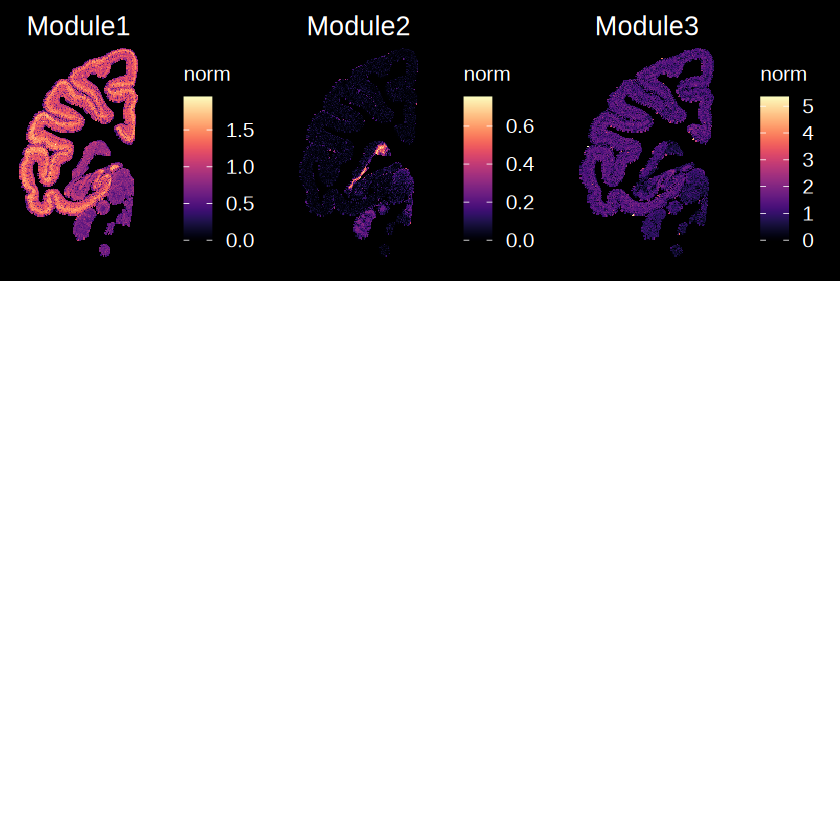

In [321]:
#show case plot
# genedf = melt(genemx.bl.hub)
# head(genedf)
# colnames(genedf) = c("Metacell","gene_id","norm")
# genedf$Metacell = as.character(genedf$Metacell)
# genedf$gene_id = as.character(genedf$gene_id)
# genedf$coord = MySplit(genedf$Metacell,"-",5)
# genedf = merge(genedf,moduledf,by.x = "gene_id",by.y = "name")
# # genedf[genedf$module == "1",]
# genedf = genedf %>% group_by(coord,module) %>% summarise(norm = mean(norm))
# genedf = genedf[!is.na(genedf$norm),]
genedf$x = as.numeric(MySplit(genedf$coord,"_",1))
genedf$y = as.numeric(MySplit(genedf$coord,"_",2))
# head(genedf)
# ggplot(genedf,aes(x = x,y = y,fill = norm)) + geom_tile() + scale_fill_viridis(option = "A") + theme_presentation() + 
#                         scale_x_reverse() + scale_y_reverse() + facet_wrap(~module)
moduleid = unique(genedf$module)
pcasels = list()
for(i in 1:length(moduleid)){
    pi = ggplot(genedf[genedf$module == moduleid[i],],aes(x = x,y = y,fill = norm)) + geom_tile() + scale_fill_viridis(option = "A") + 
                        theme_presentation() + 
                        scale_x_reverse() + scale_y_reverse() + ggtitle(paste0("Module",moduleid[i]))
    pcasels[[i]] = pi
}
length(moduleid)
pcaset = ggarrange(plotlist = pcasels,nrow = 3,ncol = 3)
pcaset
ggexport(pcaset,filename = "result/figure_revision/regulon_bin200_network_graph_gene_module_norm_cases_25_12_19.pdf",
         width = 9,height = 10)

In [ ]:
genedf = melt(genemx.bl.hub)
head(genedf)
colnames(genedf) = c("Metacell","gene_id","norm")
genedf$Metacell = as.character(genedf$Metacell)
genedf$gene_id = as.character(genedf$gene_id)
genedf$coord = MySplit(genedf$Metacell,"-",5)
genedf = merge(genedf,moduledf,by.x = "gene_id",by.y = "name")
genedf[genedf$module == "1",]
genedf = genedf %>% group_by(coord,module) %>% summarise(norm = mean(norm))
genedf = genedf[!is.na(genedf$norm),]
genedf$x = as.numeric(MySplit(genedf$coord,"_",1))
genedf$y = as.numeric(MySplit(genedf$coord,"_",2))
# head(genedf)
# ggplot(genedf,aes(x = x,y = y,fill = norm)) + geom_tile() + scale_fill_viridis(option = "A") + theme_presentation() + 
#                         scale_x_reverse() + scale_y_reverse() + facet_wrap(~module)
moduleid = unique(genedf$module)
pcasels = list()
for(i in 1:length(moduleid)){
    pi = ggplot(genedf[genedf$module == moduleid[i],],aes(x = x,y = y,fill = norm)) + geom_tile() + scale_fill_viridis(option = "A") + 
                        theme_presentation() + 
                        scale_x_reverse() + scale_y_reverse() + ggtitle(paste0("Module",moduleid[i]))
    pcasels[[i]] = pi
}
length(moduleid)
pcaset = ggarrange(plotlist = pcasels,nrow = 3,ncol = 3)
pcaset
ggexport(pcaset,filename = "result/figure_revision/regulon_bin400_network_graph_gene_norm_cases_25_10_20.pdf",
         width = 9,height = 10)

In [35]:
cordfl = dcast(cordf.fil,gene_id~SF,value.var = "cor",fun.aggregate = sum)
rownames(cordfl) = cordfl$gene_id;cordfl = cordfl[,-1]
dim(cordfl)
cordfl[,]
Heatmap(as.matrix(cordfl),show_row_dend = FALSE,column_split = 8,row_split = 5)

[1] 140 946

In [169]:
library(ComplexHeatmap)
pdf("result/figure_revision/isoform_TF_RBP_SF_DTU_cor_heatmap.pdf",width = 10, height = 6)
#cordf.fil$transcript_id = paste0(cordf.fil$gene_id,"-",cordf.fil$transcript_id)
cordfl = dcast(cordf.fil,gene_id~SF,value.var = "cor",fun.aggregate = sum)
rownames(cordfl) = cordfl$gene_id;cordfl = cordfl[,-1]
Heatmap(as.matrix(cordfl),show_row_dend = FALSE,column_split = 8,row_split = 5)
dev.off()

pdf 
  2

In [144]:
#calculate SF gene and DTU correlation
isosigi1 = isosigls$layer
isosigi2 = isosigls$subcortical
mklsi1 = mkls$layer
mklsi2 = mkls$subcortical
isosigi = rbind(isosigi1,isosigi2)
mklsi = rbind(mklsi1,mklsi2)
mklsi = mklsi[mklsi$gene %in% refsp$gene_id,]

CalSpdtucor = function(isosigi,mklsi){
    mklsi = dcast(mklsi,cluster~gene,value.var = "avg_log2FC",fill = 0)
    rownames(mklsi) = mklsi$cluster;mklsi = mklsi[,-1]
    #mklsi[is.na(mklsi)] = 0
    mklsi = mklsi[,colSums(mklsi != 0) > 2]
    isosigi.hub = isosigi[isosigi$sig!= "N",]
    isosigi.hub = isosigi[isosigi$transcript_id %in% isosigi.hub$transcript_id,]
    isosigi.hub = merge(isosigi.hub[,c("gene_id","transcript_id","areatr","dr")],mklsi,by.x = "areatr",by.y = "row.names")
    transls = unique(isosigi.hub$transcript_id)
    print(length(transls))
    res = NULL
    for(i in 1:length(transls)){
        dfi = isosigi.hub[isosigi.hub$transcript_id %in% transls[i],]
        for(j in 5:ncol(isosigi.hub)){
            cori = cor(dfi$dr,unlist(dfi[,j]))
            resi = data.frame("gene_id" = dfi$gene_id[1],
                         "transid" = dfi$transcript_id[1],
                         "sp" = colnames(dfi)[j],"cor" = cori)
            res = rbind(res,resi)
        }
    }
    res = res[!is.na(res$cor),]
    return(res)
}
#res = CalSpdtucor(isosigi,mklsi)


In [150]:
mklsi = rbind(mklsi1,mklsi2)
mklsi = mklsi[!mklsi$gene %in% refsp$gene_id,]
genehub = unique(isosigi[isosigi$sig!= "N",]$gene_id)
mklsi.hub = mklsi[mklsi$gene %in% genehub,]
length(unique(mklsi.hub$gene))
randomg = sample(unique(mklsi.hub$gene),size = 100)
length(randomg)
mklsi.rand = mklsi[mklsi$gene %in% randomg,]
res.ct = CalSpdtucor(isosigi,mklsi.rand)

[1] 2685

[1] 100

[1] 4923


Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warning message in cor(dfi$dr, unlist(dfi[, j])):
"the standard deviation is zero"
Warn

### GLMM model for RBP gene

In [10]:
cordf.bl = qread(file = "result/figure_revision/SF_DTU_cor_analysis_bin200_celltype_25_12_11.qs")
head(cordf.bl)
nrow(cordf.bl)
cordf.bl$padj = p.adjust(cordf.bl$pvalue)
cordf.bl = cordf.bl[!is.na(cordf.bl$cor),]
cordf.fil = cordf.bl[cordf.bl$padj < 0.05,]
nrow(cordf.fil)

gene_id transcript_id  cor          pvalue     SF  
1 ACTL6B  XM_005549245.2 -0.017117812 0.20176202 AAR2
2 ACYP2   NM_001285168.1  0.009465395 0.43721723 AAR2
3 AGAP3   AGAP3-FS-1     -0.007082468 0.52902731 AAR2
4 AK1     XM_005582146.2 -0.023200093 0.07903179 AAR2
5 AK1     XM_005582147.1 -0.026278433 0.05215773 AAR2
6 AKT3    XM_005539655.2 -0.007354374 0.53501093 AAR2

[1] 483061

[1] 15123

In [14]:
cordf.fil = cordf.fil[abs(cordf.fil$cor) > 0.1,]
nrow(cordf.fil)

[1] 2741

In [6]:
genemx.bl.hub = qread("result/figure_revision/ngscount_bin200_genemx_RBP_25_12_12.qs")
transtl.bl = qread(file = "data/spatial_isoform_ratio_fs_bin200_metacell_filter_25_12_11.qs")

In [10]:
blockid = MySplit(row.names(genemx.bl.hub),"-",5)
genemx.bl.hub = genemx.bl.hub[blockid != "NA",]
blockid = blockid[blockid != "NA"]
coordinates = data.frame("x" = as.numeric(MySplit(blockid,"_",1)),
                        "y" = as.numeric(MySplit(blockid,"_",2)))
rownames(coordinates) = rownames(genemx.bl.hub)
head(coordinates)

x     y    
cb-cb-NA-Cerebellum-15400_87400 15400 87400
cb-cb-NA-Cerebellum-15400_87800 15400 87800
cb-cb-NA-Cerebellum-15400_88200 15400 88200
cb-cb-NA-Cerebellum-15400_88600 15400 88600
cb-cb-NA-Cerebellum-15800_87000 15800 87000
cb-cb-NA-Cerebellum-15800_87400 15800 87400

In [12]:
transtl.bl$x = as.numeric(MySplit(transtl.bl$blockid,"_",1))
transtl.bl$y = as.numeric(MySplit(transtl.bl$blockid,"_",2))
data_long = merge(transtl.bl[,c("gene_id","transcript_id","metacell","relative","x","y")], genemx.bl.hub,by.x = "metacell",by.y = "row.names")
qsave(data_long,file = "data/spatial_isoform_ratio_fs_bin200_metacell_filter_for_GLMM_25_12_11.qs")

In [7]:
data_long = qread("data/spatial_isoform_ratio_fs_bin200_metacell_filter_for_GLMM_25_12_11.qs")
head(data_long)

metacell                        gene_id transcript_id  relative x     y    
1 cb-cb-NA-Cerebellum-15400_87400 RALBP1  XM_005587184.2 1        15400 87400
2 cb-cb-NA-Cerebellum-15400_87400 TPM3    XM_005541710.2 1        15400 87400
3 cb-cb-NA-Cerebellum-15400_87400 JMJD4   XM_005541049.2 1        15400 87400
4 cb-cb-NA-Cerebellum-15400_87400 SNRPN   XM_005558943.2 1        15400 87400
5 cb-cb-NA-Cerebellum-15400_87400 RPSA    XM_015445275.1 1        15400 87400
6 cb-cb-NA-Cerebellum-15400_87400 ZRANB2  XM_005543027.2 1        15400 87400
  AAR2 ACIN1    ACO1 ADNP ⋯ ZSCAN26 ZSCAN29 ZSCAN30 ZSCAN31 ZSCAN32  ZSCAN4
1 0    2.254784 0    0    ⋯ 0       0       0       0       2.032999 0     
2 0    2.254784 0    0    ⋯ 0       0       0       0       2.032999 0     
3 0    2.254784 0    0    ⋯ 0       0       0       0       2.032999 0     
4 0    2.254784 0    0    ⋯ 0       0       0       0       2.032999 0     
5 0    2.254784 0    0    ⋯ 0       0       0       0       2.032999 0     
6 0    2.254784 0    0    ⋯ 0       0       0       0       2.032999 0     
  ZSCAN5A ZSCAN9 ZXDC ZZZ3   
1 0       0      0    1.34662
2 0       0      0    1.34662
3 0       0      0    1.34662
4 0       0      0    1.34662
5 0       0      0    1.34662
6 0       0      0    1.34662

In [15]:
data_long = data_long[,colnames(data_long) %in% c("metacell","gene_id","transcript_id","relative","x","y",cordf.fil$SF)]
dim(data_long)

[1] 5519140     318

In [16]:
data_long = data_long[data_long$transcript_id %in% cordf.fil$transcript_id,]
dim(data_long)

[1] 1161166     318

In [25]:
colnames(data_long)[7]
cordf.fil[cordf.fil$SF == 'ADNP',]
unique(cordf.fil[cordf.fil$SF == 'ADNP',]$transcript_id)

[1] "ADNP"

gene_id      transcript_id     cor        pvalue       SF   padj        
1 LOC101925321 LOC101925321-FS-2 -0.1071589 4.900647e-29 ADNP 2.360965e-23

[1] "LOC101925321-FS-2"

In [ ]:
library(mgcv)
library(spdep)
cmpdf = data_long
{
   # cmpdf = merge(transtl[,c("gene_id","transcript_id","metacell","relative")], genemx.hub,by.x = "metacell",by.x = "row.names")
  results <- list()
  for(i in 1:(ncol(cmpdf) - 6)) {
    cmpdfi = cmpdf[,c(1:6,i+6)]
    genei = colnames(cmpdfi)[7]
    colnames(cmpdfi)[7] = "SF"
    cmpdfi = cmpdfi[!is.na(cmpdfi$SF) & !is.na(cmpdfi$relative),]
    cmpdfi = cmpdfi[!is.nan(cmpdfi$SF) & !is.nan(cmpdfi$relative),]

    transhub = unique(cordf.fil[cordf.fil$SF == genei,]$transcript_id)
    for(transcript in transhub) {
      cmpdfj <- cmpdfi[cmpdfi$transcript_id == transcript, ]
      if(nrow(cmpdfj) < 100) next
      gam_model <- tryCatch({
        gam(relative ~ s(SF, bs="tp", k = 5) + s(x, y, bs="gp"), 
            data = cmpdfj, family = betar(), method = "REML")
      }, error = function(e) {

        return(NULL)
      })
      print(i)
      if(!is.null(gam_model)) {
        results[[paste(genei, transcript, sep="_")]] <- summary(gam_model)
      }
    }
  }

}

qsave(results,file = "data/spatial_isoform_ratio_fs_bin200_metacell_filter_for_GLMM_result_list_25_12_11.qs")

Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 1


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 2


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 2


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 2


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 3


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 3


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 3


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 3


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 3


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 4


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 4


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 5


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 5


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 6


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 7


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 8


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 9


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 10


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 11


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 12


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 12


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 13


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 14


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 15


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 16


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 17


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 18


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 19


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 19


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 19


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 19


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 19


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 19


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 20


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 20


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 20


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 20


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 20


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 21


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 21


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 21


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 21


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 21


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 21


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 21


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 22


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 22


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 22


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 22


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 22


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 23


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 24


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 24


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 25


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 25


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 25


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 26


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 27


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 28


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 29


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 29


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 29


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 30


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 30


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 31


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 32


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 32


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 33


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 33


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 33


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 34


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 34
[1] 34


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 34


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 34


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 34


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 35


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 35


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 35


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 35


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 35


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 36


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 36


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 37


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 38


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 38


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 38


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 38


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 39


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 40


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 40


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 41


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 41


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 41


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 41


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 42


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 42


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 42


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 42


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 42


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 42


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 42


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 43


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 44


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 44


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 44


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 44


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 45


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 46


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 46


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 46


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 46


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 46


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 46


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 47


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 48


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 49


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 50


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 51


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 52


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 52


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 52


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 52


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 52


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 52


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 53


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 54


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 55


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 56


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 57


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 57


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 57


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 57


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 58


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 59


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 60


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 61


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 62


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 63


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 64


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 65


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 65


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 65


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 65


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 65


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 66


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 66


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 66


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 66


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 67


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 67


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 67


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 67


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 67


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 68


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 68


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 69


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 69


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 69


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 70


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 70


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 70


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 71


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 71


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 71


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 71


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 72


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 72


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 72


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 72


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 72


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 73


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 73


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 73


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 73


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 73


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 74


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 74


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 74


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 74


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 74


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 74


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 75


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 76


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 76


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 76


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 77


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 78


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 79


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 79


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 79


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 79


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 79


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 80


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 80


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 81


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 81


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 82


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 83


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 83


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 83


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 83


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 84


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 85


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 86


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 87


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 88


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 89


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 89


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 90


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 90


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 91


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 91


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 91


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 92


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 92


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 92


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 92


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 92


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 92


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


[1] 93


Warning message in family$saturated.ll(y, prior.weights, theta):
"saturated likelihood may be inaccurate"


In [ ]:

extract_essential_metrics <- function(summ, model_name) {

  # summ <- summary(model)

  data.frame(
    name = model_name,
    adj_r_sq = ifelse(is.null(summ$r.sq), NA, round(summ$r.sq, 4)),
    deviance_explained = ifelse(is.null(summ$dev.expl), NA, round(summ$dev.expl * 100, 1)),
    reml = ifelse(is.null(summ$sp.criterion), NA, round(-summ$sp.criterion, 1)),
    n = ifelse(is.null(summ$n), NA, summ$n),

    sf_edf = ifelse(!is.null(summ$s.table) && nrow(summ$s.table) >= 1, 
                   round(summ$s.table[1, "edf"], 3), NA),
    sf_p_value = ifelse(!is.null(summ$s.table) && nrow(summ$s.table) >= 1, 
                       summ$s.table[1, "p-value"], NA),
    

    spatial_edf = ifelse(!is.null(summ$s.table) && nrow(summ$s.table) >= 2, 
                        round(summ$s.table[2, "edf"], 3), NA),
    spatial_p_value = ifelse(!is.null(summ$s.table) && nrow(summ$s.table) >= 2, 
                            summ$s.table[2, "p-value"], NA),
    

    extraction_time = Sys.time(),
    
    stringsAsFactors = FALSE
  )
}


create_summary_dataframe <- function(results) {
  if (!is.list(results) || length(results) == 0) {
    stop("results必须是非空列表")
  }
  
  if (is.null(names(results))) {
    model_names <- sapply(1:length(results), function(i) {
      if (!is.null(names(results)[i]) && names(results)[i] != "") {
        names(results)[i]
      } else {
        if (!is.null(results[[i]]$model_name)) {
          results[[i]]$model_name
        } else {
          paste0("Model_", i)
        }
      }
    })
  } else {
    model_names <- names(results)
  }
  
  message(paste("开始处理", length(results), "个模型..."))
  
  summary_list <- list()
  error_count <- 0
  error_models <- character()
  
  for (i in 1:length(results)) {
    tryCatch({
      model_summary <- extract_essential_metrics(results[[i]], model_names[i])
      summary_list[[i]] <- model_summary
      if (i %% 100 == 0) {
        message(paste("已处理", i, "个模型..."))
      }
    }, error = function(e) {
      error_count <<- error_count + 1
      error_models <<- c(error_models, model_names[i])
      warning(paste("模型", model_names[i], "处理失败:", e$message))

      error_row <- data.frame(
        name = model_names[i],
        adj_r_sq = NA,
        deviance_explained = NA,
        reml = NA,
        n = NA,
        sf_edf = NA,
        sf_p_value = NA,
        spatial_edf = NA,
        spatial_p_value = NA,
        # family = NA,
        extraction_time = Sys.time(),
        error = conditionMessage(e),
        stringsAsFactors = FALSE
      )
      summary_list[[i]] <- error_row
    })
  }

  final_df <- do.call(rbind, summary_list)

  return(final_df)
}


summary_df <- create_summary_dataframe(results)

head(summary_df)

str(summary_df)

summary(summary_df[, c("adj_r_sq", "deviance_explained", "n")])

开始处理 2740 个模型...

已处理 100 个模型...

已处理 200 个模型...

已处理 300 个模型...

已处理 400 个模型...

已处理 500 个模型...

已处理 600 个模型...

已处理 700 个模型...

已处理 800 个模型...

已处理 900 个模型...

已处理 1000 个模型...

已处理 1100 个模型...

已处理 1200 个模型...

已处理 1300 个模型...

已处理 1400 个模型...

已处理 1500 个模型...

已处理 1600 个模型...

已处理 1700 个模型...

已处理 1800 个模型...

已处理 1900 个模型...

已处理 2000 个模型...

已处理 2100 个模型...

已处理 2200 个模型...

已处理 2300 个模型...

已处理 2400 个模型...

已处理 2500 个模型...

已处理 2600 个模型...

已处理 2700 个模型...


所有 2740 个模型处理完成！



name                   adj_r_sq deviance_explained reml     n     sf_edf
1 ADNP_LOC101925321-FS-2  0.0331  272.5                7128.0 10832 3.984 
2 AFF2_XM_005554942.2     0.0088   -1.0               99032.0  4970 1.052 
3 AFF2_XM_005560220.2     0.0508   -6.7               43502.5  4787 2.909 
4 AFF2_XM_005575915.2     0.0031   -0.1              153862.5  6292 1.028 
5 AFF3_LOC101925321-FS-2 -0.0080  202.6                6930.6 10832 3.993 
6 AFF3_LOC101925321-FS-3 -0.0682  615.1                7398.5 11317 3.992 
  sf_p_value   spatial_edf spatial_p_value extraction_time    
1 0.000000e+00 29.174      0.0000000000    2025-12-15 12:41:52
2 7.401209e-04  7.168      0.0008588995    2025-12-15 12:41:52
3 5.768212e-07 16.828      0.0000000000    2025-12-15 12:41:52
4 1.186697e-02  3.493      0.1885525221    2025-12-15 12:41:52
5 0.000000e+00 28.970      0.0000000000    2025-12-15 12:41:52
6 0.000000e+00 29.226      0.0000000000    2025-12-15 12:41:52

'data.frame':	2740 obs. of  10 variables:
 $ name              : chr  "ADNP_LOC101925321-FS-2" "AFF2_XM_005554942.2" "AFF2_XM_005560220.2" "AFF2_XM_005575915.2" ...
 $ adj_r_sq          : num  0.0331 0.0088 0.0508 0.0031 -0.008 -0.0682 0.0114 0.0257 0.0512 0.0781 ...
 $ deviance_explained: num  272.5 -1 -6.7 -0.1 202.6 ...
 $ reml              : num  7128 99032 43502 153862 6931 ...
 $ n                 : int  10832 4970 4787 6292 10832 11317 5359 12811 11666 8768 ...
 $ sf_edf            : num  3.98 1.05 2.91 1.03 3.99 ...
 $ sf_p_value        : num  0.00 7.40e-04 5.77e-07 1.19e-02 0.00 ...
 $ spatial_edf       : num  29.17 7.17 16.83 3.49 28.97 ...
 $ spatial_p_value   : num  0 0.000859 0 0.188553 0 ...
 $ extraction_time   : POSIXct, format: "2025-12-15 12:41:52" "2025-12-15 12:41:52" ...


    adj_r_sq        deviance_explained        n        
 Min.   :-0.13820   Min.   :-6543.200   Min.   : 4588  
 1st Qu.: 0.02328   1st Qu.:  -14.500   1st Qu.: 5713  
 Median : 0.04620   Median :   -6.300   Median : 7784  
 Mean   : 0.04560   Mean   :   -1.036   Mean   : 7960  
 3rd Qu.: 0.06953   3rd Qu.:   -2.100   3rd Qu.:10380  
 Max.   : 0.13930   Max.   : 2473.000   Max.   :14445  

In [41]:
nrow(summary_df)
nrow(summary_df[summary_df$sf_p_value < 0.01,])
nrow(summary_df[summary_df$spatial_p_value < 0.01 & summary_df$sf_p_value > 0.01,])

[1] 2740

[1] 2544

[1] 93

In [45]:
genean = unique(transtl.bl[,c("gene_id","transcript_id")])
split_result <- strsplit(summary_df$name, "_", fixed = TRUE)
summary_df$SF_gene <- sapply(split_result, function(x) x[1])
summary_df$transcript_id <- sapply(split_result, function(x) paste(x[-1], collapse = "_"))
summary_df = merge(summary_df,genean,by = "transcript_id")
head(summary_df)

transcript_id name               adj_r_sq deviance_explained reml    n   
1 CABP1-FS-1    KHDRBS3_CABP1-FS-1 0.0284   -4.5               58215.1 5356
2 CABP1-FS-1    MEF2C_CABP1-FS-1   0.0285   -4.5               58209.6 5356
3 CABP1-FS-1    ETS2_CABP1-FS-1    0.0288   -4.6               58213.6 5356
4 CABP1-FS-1    EGR1_CABP1-FS-1    0.0249   -4.4               58197.6 5356
5 CABP1-FS-1    ELAVL4_CABP1-FS-1  0.0272   -4.5               58206.0 5356
6 CABP1-FS-1    GTF3A_CABP1-FS-1   0.0304   -4.6               58221.5 5356
  sf_edf sf_p_value spatial_edf spatial_p_value extraction_time     SF_gene
1 3.662  0          10.848      0               2025-12-15 12:41:52 KHDRBS3
2 3.785  0          12.795      0               2025-12-15 12:41:53 MEF2C  
3 3.391  0          12.758      0               2025-12-15 12:41:52 ETS2   
4 3.481  0          10.570      0               2025-12-15 12:41:52 EGR1   
5 3.543  0          13.217      0               2025-12-15 12:41:52 ELAVL4 
6 3.665  0          12.911      0               2025-12-15 12:41:52 GTF3A  
  gene_id
1 CABP1  
2 CABP1  
3 CABP1  
4 CABP1  
5 CABP1  
6 CABP1

In [121]:
# summary_df[summary_df$spatial_p_value < 0.01 & summary_df$gene_id == "ARPP19",]
summary_df$spatial_fdr = p.adjust(summary_df$spatial_p_value)
summary_df$sf_fdr = p.adjust(summary_df$sf_p_value)
summary_df.hub = summary_df[summary_df$spatial_fdr < 0.01 & summary_df$sf_fdr < 0.01 & abs(summary_df$adj_r_sq) > 0.1,]
nrow(summary_df.hub)
# nrow(summary_df.hub)
summary_df.hub[summary_df.hub$gene_id == "DDRGK1",]
summary_df.hub[summary_df.hub$gene_id == "ARPP19",]

[1] 65

transcript_id  name                   adj_r_sq deviance_explained reml   
1469 XM_005568473.2 CUX2_XM_005568473.2    0.1162   -5.9               87017.3
1491 XM_005568473.2 TSC22D1_XM_005568473.2 0.1067   -5.8               86973.7
1497 XM_005568473.2 HOPX_XM_005568473.2    0.1128   -5.9               86995.8
     n    sf_edf sf_p_value spatial_edf spatial_p_value extraction_time    
1469 7844 3.802  0          22.463      0               2025-12-15 12:41:52
1491 7844 3.969  0          25.186      0               2025-12-15 12:41:53
1497 7844 3.970  0          22.256      0               2025-12-15 12:41:52
     SF_gene gene_id spatial_fdr sf_fdr
1469 CUX2    DDRGK1  0           0     
1491 TSC22D1 DDRGK1  0           0     
1497 HOPX    DDRGK1  0           0

transcript_id  name                   adj_r_sq deviance_explained reml   
2624 XM_015452432.1 TSC22D1_XM_015452432.1 0.1031   -6.8               86040.9
2672 XM_015452432.1 CUX2_XM_015452432.1    0.1025   -6.8               86017.2
2681 XM_015452432.1 MEF2C_XM_015452432.1   0.1007   -6.7               86021.9
     n    sf_edf sf_p_value spatial_edf spatial_p_value extraction_time    
2624 8768 3.967  0          25.197      0               2025-12-15 12:41:53
2672 8768 3.825  0          25.798      0               2025-12-15 12:41:52
2681 8768 3.947  0          26.252      0               2025-12-15 12:41:53
     SF_gene gene_id spatial_fdr sf_fdr
2624 TSC22D1 ARPP19  0           0     
2672 CUX2    ARPP19  0           0     
2681 MEF2C   ARPP19  0           0

In [ ]:
genedf = melt(genemx.bl.hub)
colnames(genedf) = c("Metacell","gene_id","norm")
genedf$Metacell = as.character(genedf$Metacell)
genedf$gene_id = as.character(genedf$gene_id)
# genedf = genedf[genedf$Metacell %in% transtl.bl$metacell,]
genedf$coord = MySplit(genedf$Metacell,"-",5)
genedf = genedf[genedf$coord != "NA",]
genedf$x = as.numeric(MySplit(genedf$coord,"_",1))
genedf$y = as.numeric(MySplit(genedf$coord,"_",2))

In [ ]:
#show case plot
genedf = merge(genedf,moduledf,by.x = "gene_id",by.y = "name")
genedf[genedf$module == "1",]
genedf = genedf %>% group_by(coord,module) %>% summarise(norm = mean(norm))
genedf = genedf[!is.na(genedf$norm),]

# head(genedf)
# ggplot(genedf,aes(x = x,y = y,fill = norm)) + geom_tile() + scale_fill_viridis(option = "A") + theme_presentation() + 
#                         scale_x_reverse() + scale_y_reverse() + facet_wrap(~module)
moduleid = unique(genedf$module)
pcasels = list()
for(i in 1:length(moduleid)){
    pi = ggplot(genedf[genedf$module == moduleid[i],],aes(x = x,y = y,fill = norm)) + geom_tile() + scale_fill_viridis(option = "A") + 
                        theme_presentation() + 
                        scale_x_reverse() + scale_y_reverse() + ggtitle(paste0("Module",moduleid[i]))
    pcasels[[i]] = pi
}
length(moduleid)
pcaset = ggarrange(plotlist = pcasels,nrow = 3,ncol = 3)
pcaset
ggexport(pcaset,filename = "result/figure_revision/regulon_bin400_network_graph_gene_norm_cases_25_10_20.pdf",
         width = 9,height = 10)

In [ ]:
#case
transtl.case = transtl.bl[transtl.bl$transcript_id %in% cordf.fil[cordf.fil$gene_id %in% c("DDRGK1","ARPP19","SEPT11","RCAN2"),]$transcript_id,]
transtl.case$name = paste0(transtl.case$gene_id,"-",transtl.case$transcript_id)
#transtl.case = merge(transtl.case,moduledf,by = "name")
transtl.case$x = as.numeric(MySplit(transtl.case$blockid,"_",1))
transtl.case$y = as.numeric(MySplit(transtl.case$blockid,"_",2))
#transtl.case = transtl.case[order(transtl.case$module),]
caseid = unique(transtl.case$name)
pcasels1 = list()
for(i in 1:length(caseid)){
    pi = ggplot(transtl.case[transtl.case$name == caseid[i],],aes(x = x,y = y,fill = relative)) + 
                        geom_tile() + scale_fill_viridis(option = "A") + 
                        theme_presentation() + 
                        scale_x_reverse() + scale_y_reverse() + 
                        ggtitle(caseid[i])
    pcasels1[[i]] = pi
}
pcaset1 = ggarrange(plotlist = pcasels1,ncol = 2)
pcaset1